# Lab 04 : Named Entity Recognition with sequence to sequence models

## Necessary Packages

In [2]:
import requests
import os
import json
import joblib
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import random
import numpy as np
from torch.optim import AdamW
from torch import nn
from math import ceil
from tqdm.notebook import trange,tqdm
from torch.utils.data import Dataset,DataLoader
from typing import Any,Optional,Callable
from torch.nn.utils.rnn import pad_sequence
from torch import Tensor
from trainer import Trainer
from torchmetrics.classification import MulticlassAccuracy,MulticlassF1Score,MulticlassAUROC,MulticlassPrecision,MulticlassRecall
from torchmetrics import Metric
from nltk.stem import WordNetLemmatizer

In [56]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/abdelnour/nltk_data...


True

## Global

In [3]:
DATASET_NAME = "conll2003"
DATA_DIR = os.path.join(".", "data")
FIGURES_DIR = os.path.join(".", "figures")
DOWNLOAD_DATASET = False
HUGGING_DATASETS_URL = "https://datasets-server.huggingface.co"
VOCAB_PATH = os.path.join(DATA_DIR, "vocab.pkl")
GLOVE_EMBEDDINGS_DIR = os.path.join('..','TP-2','glove.6B')
FAST_TEXT_SKIP_GRAM_DIR = os.path.join('.','24')
WEIGHTS_DIR = os.path.join(".", "weights")
HISTORIES_DIR = os.path.join(".", "histories")

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
BATCH_SIZE = 32

## Reproducibility

In [78]:
SEED = 8

In [79]:
def seed_everything():
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [80]:
seed_everything()

## Download the dataset

In [5]:
def download_dataset(name : str, dst : str):

    ### Global
    length = 100

    ### Get all the available splits
    splits_url = f"{HUGGING_DATASETS_URL}/splits?dataset={name}"

    response = requests.get(splits_url)
    json_response = json.loads(response.content)

    splits = [item['split'] for item in json_response['splits']]

    ### Create the data folder and sub-folders
    if not os.path.exists(dst):
        os.mkdir(dst)

    ### Get Some global informations
    res = requests.get(f"{HUGGING_DATASETS_URL}/rows?dataset={name}&config={name}&split=train&offset=0&length={length}")
    res = json.loads(res.content)
    
    tags = [item['type']['feature']['names'] for item in res['features'] if item['name'] == 'ner_tags'][0]

    ### Start Downloading the data
    for split in splits:

        print(f"--- Processing split : {split}. ---")

        ### Get the total number of row/pages
        split_path = os.path.join(dst, f"{split}.json")

        res = requests.get(f"{HUGGING_DATASETS_URL}/rows?dataset={name}&config={name}&split={split}&offset=0&length={length}")
        res = json.loads(res.content)

        num_rows_total = res['num_rows_total']
        num_pages = ceil(num_rows_total / length)

        print(f"--- Total number of rows : {num_rows_total}. ---")
        print(f"--- Total number of pages : {num_pages} ---")

        dataset = {}
        dataset['tags'] = tags
        dataset['rows'] = []

        for i in trange(num_pages):

            res = requests.get(f"{HUGGING_DATASETS_URL}/rows?dataset={name}&config={name}&split={split}&offset={length * i}&length={length}")
            res = json.loads(res.content)

            if res.get('rows') is None:
                continue

            rows = res['rows']

            for row in rows:

                row = row['row']

                dataset['rows'].append({
                    "tokens" : row["tokens"],
                    "ner_tags" : row["ner_tags"]
                })
        
        with open(split_path, "w") as f:
            json.dump(dataset, fp=f)
            print(f"--- Split were saved to : {f.name} ---")
        

In [6]:
if DOWNLOAD_DATASET:    
    download_dataset(DATASET_NAME, DATA_DIR)

## Data Loading

In [6]:
class Connl2003Dataset(Dataset):

    def __init__(self, 
        root : str, 
        split : str,
        tokens_transform : Optional[Callable] = None,
        ner_transform : Optional[Callable] = None
    ):

        self.filename = os.path.join(root, f"{split}.json")
        self.tags = None
        self.tokens = None
        self.ner_tags = None
        self.tokens_transform = tokens_transform
        self.ner_transform = ner_transform
        
        with open(self.filename, "r") as f:

            content = json.load(f)

            self.tags = content["tags"]
            self.tokens = [row["tokens"] for row in content["rows"]]
            self.ner_tags = [row["ner_tags"] for row in content["rows"]]

    def __getitem__(self, index) -> Any:

        tokens = self.tokens[index]
        ner_tags = self.ner_tags[index]

        if self.tokens_transform:
            tokens = self.tokens_transform(tokens)

        if self.ner_transform:
            ner_tags = self.ner_tags(ner_tags)

        tokens = torch.tensor(tokens)
        ner_tags = torch.tensor(ner_tags)

        return tokens,ner_tags
    
    def __len__(self) -> int:
        return len(self.tokens)

In [7]:
train_data = Connl2003Dataset(DATA_DIR, split="train")
test_data = Connl2003Dataset(DATA_DIR, split="test")
val_data = Connl2003Dataset(DATA_DIR, split="validation")

## Visualization

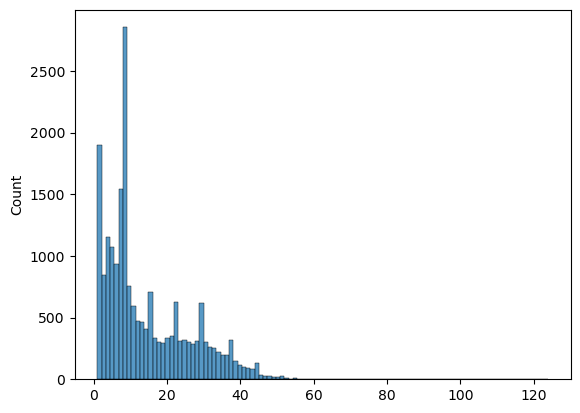

In [44]:
lengths = [len(tokens) for tokens in train_data.tokens + val_data.tokens + test_data.tokens]
ax = sns.histplot(x=lengths)
ax.get_figure().savefig(os.path.join(FIGURES_DIR, "length_hist.png"))

In [41]:
tags_counts = pd.Series([item for row in train_data.ner_tags + val_data.ner_tags + test_data.ner_tags for item in row])
tags_counts = tags_counts.to_frame(name="tag_id")
tags_counts["count"] = 1
tags_counts = tags_counts.groupby(by="tag_id").sum()
tags_counts = tags_counts.reset_index()
tags_counts["tag_name"] = tags_counts["tag_id"].apply(lambda x : train_data.tags[x])

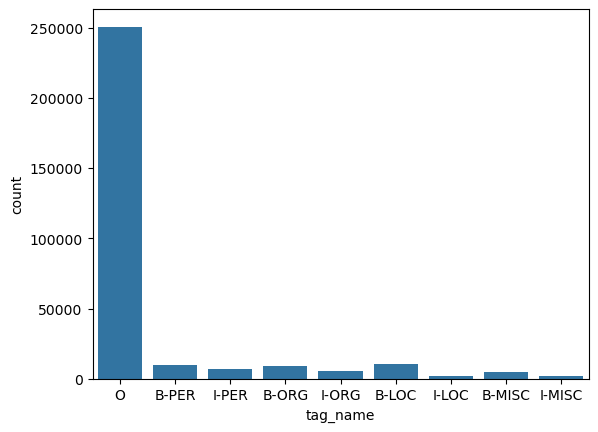

In [45]:
ax = sns.barplot(data=tags_counts,x="tag_name", y="count")
ax.get_figure().savefig(os.path.join(FIGURES_DIR, "classes_barplot.png"))

## Tokenization

In [9]:
class Vocab:

    def __init__(self,
        min_freq : int = 1,
        unk_token : str = '<unk>',
        pad_token : str = '<pad>'
    ) -> None:
        
        self.min_freq = 1
        self.unk_token = unk_token
        self.pad_token = pad_token

        self.str2idx = {}
        self.counts = {}
        self.idx2str = {}
        self.count = 0

        self.update(self.unk_token)
        self.update(self.pad_token)

        self.min_freq = min_freq

        self.unk_idx = self.str2idx[self.unk_token]
        self.pad_idx = self.str2idx[self.pad_token]

    def update(self, word : str) -> bool:

        if word not in self.counts:
            self.counts[word] = 1
        else:
            self.counts[word] += 1

        if word not in self.str2idx and self.counts[word] >= self.min_freq:

            self.str2idx[word] = self.count
            self.idx2str[self.count] = word
            self.count += 1

            return True
        
        return False

    def __getitem__(self, word_or_idx : str | int) -> int | str:

        if isinstance(word_or_idx, str):
            return self.str2idx.get(word_or_idx, self.unk_idx)
        else:
            return self.idx2str.get(word_or_idx, self.unk_token)

    def __len__(self) -> int:
        return self.count

In [10]:
class Tokenizer:

    def __init__(self,
        min_freq : int = 1,
        unk_token : str = '<unk>',
        preprocessor : Optional[Callable] = None
    ) -> None:
        self.vocab = Vocab(min_freq = min_freq,unk_token = unk_token)
        self.preprocessor = preprocessor

    def fit(self, docs : list[list[str]]):

        for doc in tqdm(docs):

            doc = doc if self.preprocessor is None else self.preprocessor(doc)

            for word in doc:
                self.vocab.update(word)

        return self
    
    def __call__(self, doc : list[str]) -> list[int]:
        doc = doc if self.preprocessor is None else self.preprocessor(doc)
        return [self.vocab[token] for token in doc]
    
    def save(self, fname : str):
        return joblib.dump(self, filename=fname)
    
    def load(fname : str):
        return joblib.load(filename=fname)

In [51]:
class TextPreprocessor(Callable):

    def __init__(self,
        lower : bool = True,
        lemmatize : bool = False
    ):
        self.lower = lower
        self.lemmatize = lemmatize
        self.lemmatizer = WordNetLemmatizer()

    def __call__(self, doc : list[str]):

        if self.lower:
            doc = [word.lower() for word in doc]
        

        if self.lemmatize:
            doc = [self.lemmatizer.lemmatize(word) for word in doc]

        return doc


In [12]:
tokenizer = Tokenizer(preprocessor=TextPreprocessor())

In [13]:
tokenizer.fit(train_data.tokens)

  0%|          | 0/14041 [00:00<?, ?it/s]

In [14]:
print(len(tokenizer.vocab))

21011


In [15]:
tokenizer.save(VOCAB_PATH)

['./data/vocab.pkl']

## Sequences indexing & padding

In [16]:
train_data = Connl2003Dataset(DATA_DIR, split="train", tokens_transform=tokenizer)
val_data = Connl2003Dataset(DATA_DIR, split="validation", tokens_transform=tokenizer)
test_data = Connl2003Dataset(DATA_DIR, split="test", tokens_transform=tokenizer)

In [17]:
MAX_LEN = max([len(row[0]) for row in train_data])

In [18]:
print(MAX_LEN)

113


In [19]:
next(iter(val_data))

(tensor([2002,  637, 2046,  211,  776,  155,  383,  118, 2091, 1799,   10]),
 tensor([0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0]))

In [20]:
class Collate:

    def __init__(self, max_len : int, tokens_pad_idx : int, tags_pad_token : int = 0):
        self.max_len = max_len
        self.tokens_pad_idx = tokens_pad_idx
        self.tags_pad_token = tags_pad_token

    def __call__(self, batch : tuple[list[Tensor], list[Tensor]]):
        
        tokens = pad_sequence([row[0] for row in batch], batch_first=True, padding_value=self.tokens_pad_idx)
        tags = pad_sequence([row[1] for row in batch], batch_first=True, padding_value=self.tags_pad_token)

        if tokens.size(-1) > self.max_len:

            tokens = tokens[:,:self.max_len]
            tags = tags[:,:self.max_len]

        elif tokens.size(-1) < self.max_len:

            padded_tokens = torch.zeros(tokens.size(0), self.max_len).fill_(self.tokens_pad_idx).long()
            padded_tokens[:,:tokens.size(-1)] = tokens
            tokens = padded_tokens

            padded_tags = torch.zeros(tags.size(0), self.max_len).fill_(self.tags_pad_token).long()
            padded_tags[:,:tags.size(-1)] = tags
            tags = padded_tags

        return tokens,tags

In [21]:
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=Collate(MAX_LEN, tokenizer.vocab.pad_idx))
val_dataloader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=Collate(MAX_LEN, tokenizer.vocab.pad_idx))
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=Collate(MAX_LEN, tokenizer.vocab.pad_idx))

In [22]:
x, y = next(iter(train_dataloader))

print("\nDimensions : \n")

print(x.shape, y.shape)

print("\nFirst data point : \n")

print(x[0])
print(y[0])


Dimensions : 

torch.Size([32, 113]) torch.Size([32, 113])

First data point : 

tensor([2623,   39, 2580,   70,  498, 1657,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Model

In [23]:
class NamedEntityRecognitionModel(nn.Module):

    RECCUREN_UNIT_CLASS_MAP = {
        'rnn' : nn.RNN,
        'lstm' : nn.LSTM,
        'gru' : nn.GRU
    }

    def __init__(self,
        name : str,
        embedding_dim : int,
        max_len : int,
        num_classes : int,
        hidden_dim : int,
        vocab_size : int | None,
        pad_idx : int | None = None,
        num_layers : int = 1,
        dropout_rate : float = 0.1,
        recurent_dropout : float = 0.1,
        embeddings : torch.Tensor | None = None,
        reccurent_unit : str = 'lstm'
    ):
        
        super().__init__()
        
        self.name = name
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.max_len = max_len
        self.num_classes = num_classes
        self.hidden_dim = hidden_dim
        self.pad_idx = pad_idx
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.recurent_dropout = recurent_dropout
        self.reccurent_unit = reccurent_unit
        self.embeddings = embeddings

        self._verify_params()

        if embeddings is None:
            self.embedding = nn.Embedding(num_embeddings=vocab_size,embedding_dim=embedding_dim,padding_idx=pad_idx)
        else:

            self.embedding_dim = self.embeddings.shape[-1]

            self.embedding = nn.Embedding.from_pretrained(
                embeddings=embeddings,
                freeze=True,
                padding_idx=pad_idx
            )

        self.dropout = nn.Dropout(p=dropout_rate)

        self.bi_lstm = NamedEntityRecognitionModel.RECCUREN_UNIT_CLASS_MAP[reccurent_unit](
            input_size=embedding_dim, 
            hidden_size=hidden_dim, 
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=recurent_dropout
        )

        self.fc = nn.Linear(in_features=2 * hidden_dim, out_features=num_classes)

    def _verify_params(self):

        if self.reccurent_unit not in NamedEntityRecognitionModel.RECCUREN_UNIT_CLASS_MAP.keys():
            raise Exception(f"reccurent_unit must be one of {','.join(NamedEntityRecognitionModel.RECCUREN_UNIT_CLASS_MAP.keys())}")
        
        if self.embeddings is not None and self.embedding_dim is not None and self.embeddings.shape[-1] != self.embedding_dim:
            raise Exception(
                f"When embeddings and embedding_dim are both not None, embedding_dim must be equal to self.embeddings.shape[-1]"
            )
            

    def forward(self, x : torch.Tensor) -> torch.Tensor:

        x = self.embedding(x)
        x = self.dropout(x)
        x,_ = self.bi_lstm(x)
        x = self.fc(x)

        return x

### Vectorization

In [24]:
def load_subset(
    filename : str,
    vocab : Vocab,
    size : int,
    skip_first_line : bool = False,
    drop_last_item : bool = False,
) -> torch.Tensor:
    
    embeddings = torch.zeros(len(vocab), size)

    with open(filename, "r") as f:

        if skip_first_line:
            f.readline()

        for line in f:

            line = line.split(' ')
            word = line[0]
            vector = line[1:]

            if drop_last_item:
                vector = vector[:-1]

            if word in vocab.str2idx:
                idx = vocab.str2idx[word]
                vector = torch.tensor([float(item) for item in vector])
                embeddings[idx] = vector

    return embeddings

In [25]:
embeddings_glove_50d = load_subset(os.path.join(GLOVE_EMBEDDINGS_DIR,"glove.6B.50d.txt"), tokenizer.vocab, 50)
embeddings_glove_100d = load_subset(os.path.join(GLOVE_EMBEDDINGS_DIR,"glove.6B.100d.txt"), tokenizer.vocab, 100)
embeddings_glove_200d = load_subset(os.path.join(GLOVE_EMBEDDINGS_DIR,"glove.6B.200d.txt"), tokenizer.vocab, 200)
embeddings_glove_300d = load_subset(os.path.join(GLOVE_EMBEDDINGS_DIR,"glove.6B.300d.txt"), tokenizer.vocab, 300)

In [26]:
embeddings_fast_text_skip_gram_300d = load_subset(
    os.path.join(os.path.join(FAST_TEXT_SKIP_GRAM_DIR, 'model.txt')), 
    tokenizer.vocab, 
    300,
    skip_first_line=True,
    drop_last_item=True
)

In [27]:
print((embeddings_glove_50d.sum(axis=1) == 0).sum())
print((embeddings_glove_100d.sum(axis=1) == 0).sum())
print((embeddings_glove_200d.sum(axis=1) == 0).sum())
print((embeddings_glove_300d.sum(axis=1) == 0).sum())
print((embeddings_fast_text_skip_gram_300d.sum(axis=1) == 0).sum())

tensor(2596)
tensor(2596)
tensor(2596)
tensor(2596)
tensor(7005)


### Training Utils

In [28]:
class Seq2SeqCrossEntropyLoss(nn.CrossEntropyLoss):

    def forward(self, input : Tensor, target : Tensor) -> Tensor:

        input = input.reshape(-1, input.size(-1))
        target = target.reshape(-1)

        return super().forward(input, target)
        


In [29]:
class Seq2SeqAccuracy:

    def __init__(self, **kwargs) -> None:
        self.acc = MulticlassAccuracy(**kwargs)

    def __call__(self, input : Tensor, target : Tensor) -> Any:

        input = input.reshape(-1, input.size(-1))
        target = target.reshape(-1)

        return self.acc(input, target)
    
    def to(self, device : torch.device):
        self.acc = self.acc.to(device)
        return self

In [30]:
class Seq2SeqF1Score:

    def __init__(self, **kwargs) -> None:
        self.acc = MulticlassF1Score(**kwargs)

    def __call__(self, input : Tensor, target : Tensor) -> Any:

        input = input.reshape(-1, input.size(-1))
        target = target.reshape(-1)

        return self.acc(input, target)
    
    def to(self, device : torch.device):
        self.acc = self.acc.to(device)
        return self

In [31]:
def history2df(history : dict) -> pd.DataFrame:
    
    dfs = []

    for key in history.keys():
        df = pd.DataFrame(history[key])
        df["split"] = [key for _ in range(len(df))]
        dfs.append(df)

    return pd.concat(dfs)    

In [32]:
def train(
    model : NamedEntityRecognitionModel,
    train_loader : DataLoader,
    val_loader : DataLoader,
    device : torch.device,
    num_classes : int,
    learning_rate : float,
    weight_decay : float,
    epochs : int,
) -> None:

    loss = Seq2SeqCrossEntropyLoss().to(device)
    optimizer = AdamW(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    accuracy = Seq2SeqAccuracy(num_classes=num_classes).to(DEVICE)
    f1_score = Seq2SeqF1Score(num_classes=num_classes,average="macro").to(DEVICE)

    trainer = Trainer() \
        .set_device(device) \
        .set_loss(loss) \
        .set_optimizer(optimizer) \
        .add_metric("accuracy", accuracy) \
        .add_metric("f1_score", f1_score) \
        .set_log_every(20) \
    
    trainer.train(model, train_loader, val_loader, epochs=epochs)

    weights_path = os.path.join(WEIGHTS_DIR, f"{model.name}.pt")
    print(f"Model was saved to : {weights_path}")
    torch.save(model.state_dict(), weights_path)

    history_path = os.path.join(HISTORIES_DIR, f"{model.name}.csv")
    print(f"History was saved to : {history_path}")
    history2df(trainer.history).to_csv(history_path)

### Models training

In [33]:
VOCAB_SIZE = len(tokenizer.vocab)
NUM_CLASSES = len(train_data.tags)
PAD_IDX = tokenizer.vocab.pad_idx
LEARNING_RATE = 0.0005
WEIGHT_DECAY = 0.0025
EPOCHS = 100
HIDDEN_DIM = 32
DROPOUT = 0.3

In [34]:
base_configs = {
    "max_len" : MAX_LEN,
    "vocab_size" : VOCAB_SIZE,
    "pad_idx" : PAD_IDX,
    "num_classes" : NUM_CLASSES,
    "hidden_dim" : HIDDEN_DIM,
    "num_layers" : 2,
    "reccurent_unit" : "lstm",
    "dropout_rate" : DROPOUT
}

In [35]:
configs = [
    {
        **base_configs,"embedding_dim" : 64,"embeddings" : None, "name" : "64_lstm_2"
    },
    {
        **base_configs,"embedding_dim" : 50,"embeddings" : embeddings_glove_50d, "name" : "50_lstm_2_glove"
    },
    {
        **base_configs,"embedding_dim" : 100,"embeddings" : embeddings_glove_100d, "name" : "100_lstm_2_glove"
    },
    {
        **base_configs,"embedding_dim" : 200,"embeddings" : embeddings_glove_200d, "name" : "200_lstm_2_glove"
    },
    {
        **base_configs,"embedding_dim" : 300,"embeddings" : embeddings_glove_300d, "name" : "300_lstm_2_glove"
    },
    {
        **base_configs,"embedding_dim" : 300,"embeddings" : embeddings_fast_text_skip_gram_300d, "name" : "300_lstm_2_fasttext"
    },
]

In [36]:
model = NamedEntityRecognitionModel(**configs[0]).to(DEVICE)
train(model, train_dataloader, val_dataloader, DEVICE, NUM_CLASSES, LEARNING_RATE, WEIGHT_DECAY, EPOCHS)

accuracy = 0.125,f1_score = 0.12377827614545822,loss = 0.08284009993076324: 100%|██████████| 439/439 [00:02<00:00, 156.51it/s]             


Epoch 1 : accuracy = 0.11497565486165005,f1_score = 0.11212788523198158,loss = 0.2715893452456709,val_accuracy = 0.11432072907394054,val_f1_score = 0.11296756046951986,val_loss = 0.1017568142098539



accuracy = 0.125,f1_score = 0.1241297721862793,loss = 0.05597209185361862: 100%|██████████| 439/439 [00:02<00:00, 196.72it/s]              


Epoch 2 : accuracy = 0.11481722597041272,f1_score = 0.11357496283388355,loss = 0.08798512129923478,val_accuracy = 0.11383442332347234,val_f1_score = 0.11248326747148644,val_loss = 0.0915269203776238



accuracy = 0.14814814925193787,f1_score = 0.16138404607772827,loss = 0.06404811888933182: 100%|██████████| 439/439 [00:02<00:00, 198.89it/s]


Epoch 3 : accuracy = 0.11884326623553296,f1_score = 0.12051222712684058,loss = 0.07864790719537094,val_accuracy = 0.1336416757720358,val_f1_score = 0.14312252117430463,val_loss = 0.08219920810969437



accuracy = 0.19370710849761963,f1_score = 0.21328105032444,loss = 0.06952588260173798: 100%|██████████| 439/439 [00:02<00:00, 196.14it/s]   


Epoch 4 : accuracy = 0.1611779837069316,f1_score = 0.17513077684035333,loss = 0.0702062519118699,val_accuracy = 0.17672626659566282,val_f1_score = 0.1992357430212638,val_loss = 0.07727349407094367



accuracy = 0.2524939775466919,f1_score = 0.29042959213256836,loss = 0.05474656820297241: 100%|██████████| 439/439 [00:02<00:00, 199.37it/s]  


Epoch 5 : accuracy = 0.2396061857631918,f1_score = 0.26613501077496654,loss = 0.06277329303273307,val_accuracy = 0.2484313831025479,val_f1_score = 0.28348709233835634,val_loss = 0.06853389597552664



accuracy = 0.3462750315666199,f1_score = 0.3669775128364563,loss = 0.047923795878887177: 100%|██████████| 439/439 [00:02<00:00, 199.54it/s]  


Epoch 6 : accuracy = 0.3071144921089902,f1_score = 0.33384734365011404,loss = 0.05592181202626717,val_accuracy = 0.3085262310855529,val_f1_score = 0.3492216139155276,val_loss = 0.061392532278071434



accuracy = 0.3487849235534668,f1_score = 0.36343634128570557,loss = 0.05208412557840347: 100%|██████████| 439/439 [00:02<00:00, 196.89it/s]  


Epoch 7 : accuracy = 0.36665788890289014,f1_score = 0.3918588011099157,loss = 0.04984896855772492,val_accuracy = 0.3282970321529052,val_f1_score = 0.37577806150212006,val_loss = 0.0608566309161046



accuracy = 0.4737624526023865,f1_score = 0.4669697880744934,loss = 0.03956597298383713: 100%|██████████| 439/439 [00:02<00:00, 195.55it/s]   


Epoch 8 : accuracy = 0.41912806706167843,f1_score = 0.44328334567758654,loss = 0.04512926615384282,val_accuracy = 0.4029982119214301,val_f1_score = 0.4589409480492274,val_loss = 0.05534877016336894



accuracy = 0.5187647342681885,f1_score = 0.5627648830413818,loss = 0.040297821164131165: 100%|██████████| 439/439 [00:02<00:00, 180.99it/s] 


Epoch 9 : accuracy = 0.47409653127329227,f1_score = 0.5003726322178417,loss = 0.04122334899877226,val_accuracy = 0.4349336603692934,val_f1_score = 0.5048460376028922,val_loss = 0.05459800742420496



accuracy = 0.6442617177963257,f1_score = 0.66988205909729,loss = 0.02189016342163086: 100%|██████████| 439/439 [00:02<00:00, 197.60it/s]    


Epoch 10 : accuracy = 0.5246932133183664,f1_score = 0.5539977469721253,loss = 0.03811438890398906,val_accuracy = 0.49119885879404407,val_f1_score = 0.5596635131274953,val_loss = 0.047682402564176156



accuracy = 0.6545003652572632,f1_score = 0.693436324596405,loss = 0.03336494043469429: 100%|██████████| 439/439 [00:02<00:00, 195.53it/s]  


Epoch 11 : accuracy = 0.5687772241974746,f1_score = 0.5971648245710447,loss = 0.03527095557905411,val_accuracy = 0.5422849102931864,val_f1_score = 0.6082448778199214,val_loss = 0.04356532116584918



accuracy = 0.531324028968811,f1_score = 0.554003894329071,loss = 0.044154126197099686: 100%|██████████| 439/439 [00:02<00:00, 190.21it/s]   


Epoch 12 : accuracy = 0.6035907969795218,f1_score = 0.6301868822688665,loss = 0.03296010888654713,val_accuracy = 0.5467870662025377,val_f1_score = 0.6205658243567336,val_loss = 0.04574835349750869



accuracy = 0.4727868437767029,f1_score = 0.4673641622066498,loss = 0.038279563188552856: 100%|██████████| 439/439 [00:02<00:00, 197.42it/s] 


Epoch 13 : accuracy = 0.6310957077559686,f1_score = 0.6551228597386823,loss = 0.03131318941355973,val_accuracy = 0.5769411474466324,val_f1_score = 0.6470652158353843,val_loss = 0.042768045511169764



accuracy = 0.6420922875404358,f1_score = 0.6786847114562988,loss = 0.02039332501590252: 100%|██████████| 439/439 [00:02<00:00, 198.53it/s] 


Epoch 14 : accuracy = 0.6492179100632939,f1_score = 0.6708883895689371,loss = 0.02936775190861798,val_accuracy = 0.5994238935264886,val_f1_score = 0.6666065121398252,val_loss = 0.04038698662656779



accuracy = 0.6796392202377319,f1_score = 0.7124022841453552,loss = 0.021479923278093338: 100%|██████████| 439/439 [00:02<00:00, 196.11it/s]


Epoch 15 : accuracy = 0.6703577186903812,f1_score = 0.6906003597657067,loss = 0.027847003919371574,val_accuracy = 0.6099847876558117,val_f1_score = 0.675296912298483,val_loss = 0.039457692344691236



accuracy = 0.6468003988265991,f1_score = 0.7045890092849731,loss = 0.027176911011338234: 100%|██████████| 439/439 [00:02<00:00, 192.48it/s]


Epoch 16 : accuracy = 0.68911120716423,f1_score = 0.7062625407086418,loss = 0.026691867428956923,val_accuracy = 0.6187506078505048,val_f1_score = 0.6844073452201545,val_loss = 0.039525527908813717



accuracy = 0.8113056421279907,f1_score = 0.8195189833641052,loss = 0.017962785437703133: 100%|██████████| 439/439 [00:02<00:00, 194.18it/s]


Epoch 17 : accuracy = 0.6956958429281153,f1_score = 0.7113662561007132,loss = 0.025448694869723162,val_accuracy = 0.6058924513704637,val_f1_score = 0.6784637377542608,val_loss = 0.04333499749647636



accuracy = 0.8661234378814697,f1_score = 0.8099991083145142,loss = 0.016885800287127495: 100%|██████████| 439/439 [00:02<00:00, 193.19it/s]


Epoch 18 : accuracy = 0.7119229981730902,f1_score = 0.7270146452212931,loss = 0.024294097156843046,val_accuracy = 0.6274474499856725,val_f1_score = 0.692622124564414,val_loss = 0.04123015543811169



accuracy = 0.6188778877258301,f1_score = 0.6627751588821411,loss = 0.029646586626768112: 100%|██████████| 439/439 [00:02<00:00, 190.97it/s]


Epoch 19 : accuracy = 0.7307007008641618,f1_score = 0.7447245397980501,loss = 0.0229967720085301,val_accuracy = 0.63933853133052,val_f1_score = 0.7069860907161937,val_loss = 0.0396467858706327



accuracy = 0.730553150177002,f1_score = 0.7396985292434692,loss = 0.01905813068151474: 100%|██████████| 439/439 [00:02<00:00, 193.20it/s]  


Epoch 20 : accuracy = 0.7351194101476995,f1_score = 0.7496746726894161,loss = 0.02194065781064111,val_accuracy = 0.6568469469453774,val_f1_score = 0.7194299931619682,val_loss = 0.037435058166510334



accuracy = 0.6432994604110718,f1_score = 0.6498544812202454,loss = 0.018571365624666214: 100%|██████████| 439/439 [00:02<00:00, 196.83it/s]


Epoch 21 : accuracy = 0.7448943501724469,f1_score = 0.7568573579701313,loss = 0.021335401308164848,val_accuracy = 0.6534664575375763,val_f1_score = 0.7174214881424811,val_loss = 0.03866828502356714



accuracy = 0.889069676399231,f1_score = 0.8364010453224182,loss = 0.015335903503000736: 100%|██████████| 439/439 [00:02<00:00, 199.27it/s] 


Epoch 22 : accuracy = 0.762517691201664,f1_score = 0.7753305585889447,loss = 0.020323302702880665,val_accuracy = 0.6752794063558766,val_f1_score = 0.7357485265124077,val_loss = 0.03654762570216667



accuracy = 0.753200352191925,f1_score = 0.71097731590271,loss = 0.01608303375542164: 100%|██████████| 439/439 [00:02<00:00, 197.88it/s]    


Epoch 23 : accuracy = 0.7679516408329401,f1_score = 0.779678572826342,loss = 0.019489900908031946,val_accuracy = 0.6708716165785696,val_f1_score = 0.7354000330555672,val_loss = 0.03695202188785462



accuracy = 0.8505475521087646,f1_score = 0.8208786845207214,loss = 0.01514904573559761: 100%|██████████| 439/439 [00:02<00:00, 193.19it/s]  


Epoch 24 : accuracy = 0.7792812555960479,f1_score = 0.7899771543189985,loss = 0.018610631139070678,val_accuracy = 0.6566004364513883,val_f1_score = 0.7261718529112199,val_loss = 0.03815722936654792



accuracy = 0.8325980305671692,f1_score = 0.8058662414550781,loss = 0.017442502081394196: 100%|██████████| 439/439 [00:02<00:00, 196.13it/s]


Epoch 25 : accuracy = 0.7849994645303365,f1_score = 0.7933764097902389,loss = 0.017955635750670502,val_accuracy = 0.6730930460434333,val_f1_score = 0.7363771249850591,val_loss = 0.03793882432521558



accuracy = 0.8084251880645752,f1_score = 0.8378868103027344,loss = 0.0127437524497509: 100%|██████████| 439/439 [00:02<00:00, 198.11it/s]  


Epoch 26 : accuracy = 0.7940008704102935,f1_score = 0.8032104734136195,loss = 0.017340330648870295,val_accuracy = 0.694360968821189,val_f1_score = 0.7507756954314662,val_loss = 0.03431832961117228



accuracy = 0.7630536556243896,f1_score = 0.7863473892211914,loss = 0.024959806352853775: 100%|██████████| 439/439 [00:02<00:00, 196.30it/s]


Epoch 27 : accuracy = 0.7986464667428871,f1_score = 0.8066137389604486,loss = 0.016810595541598448,val_accuracy = 0.6918352328094781,val_f1_score = 0.7469266366724875,val_loss = 0.0334630705617076



accuracy = 0.9381983280181885,f1_score = 0.926874041557312,loss = 0.007881252095103264: 100%|██████████| 439/439 [00:02<00:00, 193.76it/s] 


Epoch 28 : accuracy = 0.8079729509245018,f1_score = 0.8147338613833817,loss = 0.016174796605928205,val_accuracy = 0.6948336979337767,val_f1_score = 0.7543698070096034,val_loss = 0.03291733769754715



accuracy = 0.8198964595794678,f1_score = 0.8269503116607666,loss = 0.02005496621131897: 100%|██████████| 439/439 [00:02<00:00, 195.11it/s] 


Epoch 29 : accuracy = 0.8152957235490542,f1_score = 0.8213785988594785,loss = 0.015395580824880366,val_accuracy = 0.6884780087891746,val_f1_score = 0.7498958832493016,val_loss = 0.03605995336364882



accuracy = 0.7086750268936157,f1_score = 0.7357027530670166,loss = 0.018237175419926643: 100%|██████████| 439/439 [00:02<00:00, 198.76it/s]


Epoch 30 : accuracy = 0.8173307267299817,f1_score = 0.8257901904794784,loss = 0.014873527400916896,val_accuracy = 0.7095725916179956,val_f1_score = 0.7598492631725237,val_loss = 0.032031300587250906



accuracy = 0.8904780149459839,f1_score = 0.8843411803245544,loss = 0.013620243407785892: 100%|██████████| 439/439 [00:02<00:00, 193.93it/s]


Epoch 31 : accuracy = 0.8245942060388031,f1_score = 0.8308280098139561,loss = 0.014314782380387357,val_accuracy = 0.7071380182808521,val_f1_score = 0.7647816217413136,val_loss = 0.03427007120540913



accuracy = 0.8392670750617981,f1_score = 0.8591153621673584,loss = 0.012668859213590622: 100%|██████████| 439/439 [00:02<00:00, 193.85it/s]


Epoch 32 : accuracy = 0.829452591632113,f1_score = 0.8350278187992904,loss = 0.013938533408983116,val_accuracy = 0.7064730548391155,val_f1_score = 0.7583534629905925,val_loss = 0.03267322256978528



accuracy = 0.6305935382843018,f1_score = 0.6614929437637329,loss = 0.024619562551379204: 100%|██████████| 439/439 [00:02<00:00, 193.75it/s]


Epoch 33 : accuracy = 0.8328729376434465,f1_score = 0.8388360281196977,loss = 0.0132588675576591,val_accuracy = 0.7166074543607002,val_f1_score = 0.7676040039342993,val_loss = 0.03274561385350192



accuracy = 0.8514272570610046,f1_score = 0.8635997176170349,loss = 0.012130546383559704: 100%|██████████| 439/439 [00:02<00:00, 193.93it/s] 


Epoch 34 : accuracy = 0.8381885989380318,f1_score = 0.8443277509446024,loss = 0.013124748841691805,val_accuracy = 0.7183632225382561,val_f1_score = 0.7678802638661628,val_loss = 0.03280749454108231



accuracy = 0.937970757484436,f1_score = 0.8915824294090271,loss = 0.005385981872677803: 100%|██████████| 439/439 [00:02<00:00, 197.24it/s] 


Epoch 35 : accuracy = 0.8433153045476162,f1_score = 0.8454822880260494,loss = 0.012656522921662023,val_accuracy = 0.7076369450957167,val_f1_score = 0.7652029751562605,val_loss = 0.03474265114203388



accuracy = 0.8343818783760071,f1_score = 0.8695300817489624,loss = 0.020719556137919426: 100%|██████████| 439/439 [00:02<00:00, 194.61it/s]


Epoch 36 : accuracy = 0.8503124021451945,f1_score = 0.8542832345245639,loss = 0.012103318169942139,val_accuracy = 0.7184936088674209,val_f1_score = 0.7697386753325369,val_loss = 0.03245344308807569



accuracy = 0.9433469772338867,f1_score = 0.9288376569747925,loss = 0.0055741057731211185: 100%|██████████| 439/439 [00:02<00:00, 194.92it/s]


Epoch 37 : accuracy = 0.8546469086666585,f1_score = 0.8590816312335889,loss = 0.011788409430817924,val_accuracy = 0.7092956275332207,val_f1_score = 0.7645192742347717,val_loss = 0.03283003558788229



accuracy = 0.9388956427574158,f1_score = 0.946700394153595,loss = 0.008958256803452969: 100%|██████████| 439/439 [00:02<00:00, 191.41it/s]  


Epoch 38 : accuracy = 0.8562736964714555,f1_score = 0.8599255848039528,loss = 0.011453397044326456,val_accuracy = 0.7278881254149419,val_f1_score = 0.7800935612005346,val_loss = 0.03423594969196939



accuracy = 0.862972617149353,f1_score = 0.8535612225532532,loss = 0.008797206915915012: 100%|██████████| 439/439 [00:02<00:00, 198.31it/s] 


Epoch 39 : accuracy = 0.860575452480881,f1_score = 0.8640301223496369,loss = 0.011081328727983803,val_accuracy = 0.7227294924212437,val_f1_score = 0.7758378620241203,val_loss = 0.03246693805261862



accuracy = 0.9402074813842773,f1_score = 0.9353926181793213,loss = 0.006811090745031834: 100%|██████████| 439/439 [00:02<00:00, 195.23it/s] 


Epoch 40 : accuracy = 0.8647071573891781,f1_score = 0.868252608526269,loss = 0.010709269208820846,val_accuracy = 0.7302594406932008,val_f1_score = 0.7795015801401699,val_loss = 0.03242613231836289



accuracy = 0.8056660294532776,f1_score = 0.8439244627952576,loss = 0.0073223114013671875: 100%|██████████| 439/439 [00:02<00:00, 195.67it/s]


Epoch 41 : accuracy = 0.8699638028894308,f1_score = 0.8744205577226869,loss = 0.0103289023299483,val_accuracy = 0.7178797184252271,val_f1_score = 0.7769767688769921,val_loss = 0.033773728372419584



accuracy = 0.8359814286231995,f1_score = 0.8428676128387451,loss = 0.01436601672321558: 100%|██████████| 439/439 [00:02<00:00, 189.68it/s] 


Epoch 42 : accuracy = 0.8689841508593809,f1_score = 0.8719761038967037,loss = 0.010080940909004837,val_accuracy = 0.7247332054025987,val_f1_score = 0.7795546335332534,val_loss = 0.03416189349566897



accuracy = 0.8579628467559814,f1_score = 0.7965714335441589,loss = 0.00996319204568863: 100%|██████████| 439/439 [00:02<00:00, 197.90it/s]  


Epoch 43 : accuracy = 0.8784697266265852,f1_score = 0.8809884464822217,loss = 0.009775089112997208,val_accuracy = 0.7223631383157244,val_f1_score = 0.7769761640651554,val_loss = 0.033937998782551174



accuracy = 0.8247740268707275,f1_score = 0.8510286211967468,loss = 0.010404307395219803: 100%|██████████| 439/439 [00:02<00:00, 194.76it/s] 


Epoch 44 : accuracy = 0.8766068015120295,f1_score = 0.8800438370954474,loss = 0.009503895829215323,val_accuracy = 0.7352372425443986,val_f1_score = 0.7881587539233413,val_loss = 0.03365260430191662



accuracy = 0.896264910697937,f1_score = 0.8601378202438354,loss = 0.009980451315641403: 100%|██████████| 439/439 [00:02<00:00, 189.09it/s] 


Epoch 45 : accuracy = 0.8855409904601633,f1_score = 0.8873105907222948,loss = 0.009138591486773961,val_accuracy = 0.734280983022615,val_f1_score = 0.7885414794379589,val_loss = 0.03333565035798386



accuracy = 0.8953388333320618,f1_score = 0.9165692329406738,loss = 0.008088154718279839: 100%|██████████| 439/439 [00:02<00:00, 193.58it/s] 


Epoch 46 : accuracy = 0.8867318087123792,f1_score = 0.8901944089859113,loss = 0.009014040816167967,val_accuracy = 0.734443265433405,val_f1_score = 0.7856276385924396,val_loss = 0.032892530761184355



accuracy = 0.8782576322555542,f1_score = 0.9165749549865723,loss = 0.0074148098938167095: 100%|██████████| 439/439 [00:02<00:00, 192.55it/s]


Epoch 47 : accuracy = 0.8893404395270728,f1_score = 0.8923286650338315,loss = 0.008647581763938919,val_accuracy = 0.7478120513990814,val_f1_score = 0.7929638840404212,val_loss = 0.03194247388427018



accuracy = 0.8072859048843384,f1_score = 0.8316681385040283,loss = 0.008555802516639233: 100%|██████████| 439/439 [00:02<00:00, 183.19it/s] 


Epoch 48 : accuracy = 0.8938291319953553,f1_score = 0.8954306914214393,loss = 0.008552165801163789,val_accuracy = 0.7519229749838511,val_f1_score = 0.7948140192265604,val_loss = 0.02996907626077825



accuracy = 0.956128716468811,f1_score = 0.9168229699134827,loss = 0.0028168833814561367: 100%|██████████| 439/439 [00:02<00:00, 195.26it/s] 


Epoch 49 : accuracy = 0.8911126952508044,f1_score = 0.8944409621332121,loss = 0.0082792341693226,val_accuracy = 0.7500066418273776,val_f1_score = 0.793582480912115,val_loss = 0.03183623555792021



accuracy = 0.837931752204895,f1_score = 0.8454279899597168,loss = 0.004752930719405413: 100%|██████████| 439/439 [00:02<00:00, 186.27it/s]  


Epoch 50 : accuracy = 0.8966629939633242,f1_score = 0.8981640723137214,loss = 0.008063889789588087,val_accuracy = 0.7651881254186818,val_f1_score = 0.8064791828978295,val_loss = 0.030089409245798986



accuracy = 0.9054926633834839,f1_score = 0.9301705360412598,loss = 0.0063477810472249985: 100%|██████████| 439/439 [00:02<00:00, 185.96it/s]


Epoch 51 : accuracy = 0.9034793996050581,f1_score = 0.9036264904267696,loss = 0.007775614240311791,val_accuracy = 0.7452148719161165,val_f1_score = 0.7942702700110043,val_loss = 0.03189457586838627



accuracy = 0.9559082984924316,f1_score = 0.9725089073181152,loss = 0.004401895217597485: 100%|██████████| 439/439 [00:02<00:00, 196.25it/s] 


Epoch 52 : accuracy = 0.9021971881525391,f1_score = 0.9035992314169239,loss = 0.0075415881071664,val_accuracy = 0.743894514499926,val_f1_score = 0.7915384249359954,val_loss = 0.03297351444295297



accuracy = 0.962738573551178,f1_score = 0.901840090751648,loss = 0.008765006437897682: 100%|██████████| 439/439 [00:02<00:00, 195.62it/s]   


Epoch 53 : accuracy = 0.9049440960406171,f1_score = 0.9073163522131622,loss = 0.007444908756790322,val_accuracy = 0.7574408270564734,val_f1_score = 0.8014189396418777,val_loss = 0.030048015993088484



accuracy = 0.9578986763954163,f1_score = 0.9408184289932251,loss = 0.004886607639491558: 100%|██████████| 439/439 [00:02<00:00, 193.34it/s] 


Epoch 54 : accuracy = 0.9054852536707642,f1_score = 0.9065299877273194,loss = 0.0072366052568658915,val_accuracy = 0.7545119599968779,val_f1_score = 0.8014177054751153,val_loss = 0.03133808650697271



accuracy = 0.8799842596054077,f1_score = 0.8840969204902649,loss = 0.015671225264668465: 100%|██████████| 439/439 [00:02<00:00, 195.98it/s] 


Epoch 55 : accuracy = 0.9073924217245845,f1_score = 0.9080479719372708,loss = 0.007000635702646675,val_accuracy = 0.7574067413806915,val_f1_score = 0.80565884884666,val_loss = 0.033549943865806446



accuracy = 0.9814502596855164,f1_score = 0.9496763944625854,loss = 0.002335963537916541: 100%|██████████| 439/439 [00:02<00:00, 195.84it/s] 


Epoch 56 : accuracy = 0.9127049193566915,f1_score = 0.9127252043515511,loss = 0.006972140342989991,val_accuracy = 0.7646067645035538,val_f1_score = 0.8014640983413247,val_loss = 0.029323662640344278



accuracy = 0.9510658979415894,f1_score = 0.9112333059310913,loss = 0.007854018360376358: 100%|██████████| 439/439 [00:02<00:00, 189.97it/s]


Epoch 57 : accuracy = 0.9135007987261362,f1_score = 0.9152078852566609,loss = 0.006727602160196319,val_accuracy = 0.7660622830484428,val_f1_score = 0.8045002134407268,val_loss = 0.030522240700163676



accuracy = 0.9431402683258057,f1_score = 0.9540891647338867,loss = 0.0036796971689909697: 100%|██████████| 439/439 [00:02<00:00, 196.69it/s]


Epoch 58 : accuracy = 0.9163328369820579,f1_score = 0.917894363946415,loss = 0.006419921958668408,val_accuracy = 0.7570759893632403,val_f1_score = 0.8000969635505303,val_loss = 0.031169375057752226



accuracy = 0.960465669631958,f1_score = 0.9180126190185547,loss = 0.005617646500468254: 100%|██████████| 439/439 [00:02<00:00, 198.86it/s]  


Epoch 59 : accuracy = 0.9153468998526658,f1_score = 0.9169094489212731,loss = 0.006301806794807256,val_accuracy = 0.7712306415333468,val_f1_score = 0.8061574358566135,val_loss = 0.029688394308893706



accuracy = 0.9154320955276489,f1_score = 0.9152184724807739,loss = 0.004140794742852449: 100%|██████████| 439/439 [00:02<00:00, 190.05it/s] 


Epoch 60 : accuracy = 0.920516444230134,f1_score = 0.9204301015391165,loss = 0.00621694107412664,val_accuracy = 0.7681355312758801,val_f1_score = 0.808622911864636,val_loss = 0.030859892895700885



accuracy = 0.8997863531112671,f1_score = 0.9227982759475708,loss = 0.006686339154839516: 100%|██████████| 439/439 [00:02<00:00, 195.16it/s] 


Epoch 61 : accuracy = 0.9181871114124741,f1_score = 0.9188105309199636,loss = 0.006094653695845098,val_accuracy = 0.7489043620287203,val_f1_score = 0.8020771157507803,val_loss = 0.035046224728884065



accuracy = 0.9774256348609924,f1_score = 0.9820771217346191,loss = 0.004484488163143396: 100%|██████████| 439/439 [00:02<00:00, 194.90it/s] 


Epoch 62 : accuracy = 0.9265823550267752,f1_score = 0.926439381677632,loss = 0.005772578942903438,val_accuracy = 0.7714506691577387,val_f1_score = 0.8125357563589134,val_loss = 0.03222126526274152



accuracy = 0.9656466245651245,f1_score = 0.9144041538238525,loss = 0.007454973179847002: 100%|██████████| 439/439 [00:02<00:00, 196.39it/s] 


Epoch 63 : accuracy = 0.9269250013562161,f1_score = 0.9285369739445576,loss = 0.0056871346676412434,val_accuracy = 0.7740642159592872,val_f1_score = 0.8141985313565123,val_loss = 0.029925227731320204



accuracy = 0.8788756132125854,f1_score = 0.8862570524215698,loss = 0.012539123184978962: 100%|██████████| 439/439 [00:02<00:00, 192.86it/s] 


Epoch 64 : accuracy = 0.9261419798898806,f1_score = 0.9267864758170004,loss = 0.005671298340178288,val_accuracy = 0.7786890542974659,val_f1_score = 0.8183780423566407,val_loss = 0.0307226665820196



accuracy = 0.9605507254600525,f1_score = 0.9671386480331421,loss = 0.0041826749220490456: 100%|██████████| 439/439 [00:02<00:00, 190.01it/s]


Epoch 65 : accuracy = 0.9315832991806413,f1_score = 0.9313813327113697,loss = 0.005469485283097367,val_accuracy = 0.7654383690918193,val_f1_score = 0.8125559009757697,val_loss = 0.03378480819839181



accuracy = 0.9791666865348816,f1_score = 0.9636952877044678,loss = 0.0033421979751437902: 100%|██████████| 439/439 [00:02<00:00, 195.41it/s]


Epoch 66 : accuracy = 0.9299377012904522,f1_score = 0.9299336761439851,loss = 0.005299857808308833,val_accuracy = 0.7509248142733294,val_f1_score = 0.8024129262741875,val_loss = 0.03576161622471523



accuracy = 0.948853611946106,f1_score = 0.9676074981689453,loss = 0.0027278128545731306: 100%|██████████| 439/439 [00:02<00:00, 196.81it/s] 


Epoch 67 : accuracy = 0.9308387873384567,f1_score = 0.930629846446878,loss = 0.005235124874758218,val_accuracy = 0.7660283604088951,val_f1_score = 0.8097311112226224,val_loss = 0.03430789347518893



accuracy = 0.7052102088928223,f1_score = 0.7180290222167969,loss = 0.007829850539565086: 100%|██████████| 439/439 [00:02<00:00, 197.87it/s] 


Epoch 68 : accuracy = 0.9354619019938493,f1_score = 0.9346697691632838,loss = 0.005066481227710725,val_accuracy = 0.7696002003024606,val_f1_score = 0.8137251389961616,val_loss = 0.03291650709020449



accuracy = 0.9875912070274353,f1_score = 0.9850229620933533,loss = 0.0034443920012563467: 100%|██████████| 439/439 [00:02<00:00, 191.76it/s]


Epoch 69 : accuracy = 0.935395939882361,f1_score = 0.9358693953255586,loss = 0.004916243015280405,val_accuracy = 0.7535911494610357,val_f1_score = 0.8046640888148663,val_loss = 0.036782190468454476



accuracy = 0.7925677299499512,f1_score = 0.7815133929252625,loss = 0.017095312476158142: 100%|██████████| 439/439 [00:02<00:00, 194.41it/s] 


Epoch 70 : accuracy = 0.935190448185306,f1_score = 0.9342612129952207,loss = 0.004825937436922222,val_accuracy = 0.7651754915714264,val_f1_score = 0.8074430805795333,val_loss = 0.03333060866605271



accuracy = 0.9752459526062012,f1_score = 0.9618857502937317,loss = 0.00392903434112668: 100%|██████████| 439/439 [00:02<00:00, 196.85it/s]  


Epoch 71 : accuracy = 0.9375067315231966,f1_score = 0.9376339389685889,loss = 0.0046031911429023084,val_accuracy = 0.7651762652630899,val_f1_score = 0.8102307582602781,val_loss = 0.03500861579132285



accuracy = 0.9844444394111633,f1_score = 0.9866055846214294,loss = 0.001928141457028687: 100%|██████████| 439/439 [00:02<00:00, 196.62it/s] 


Epoch 72 : accuracy = 0.9379403280234283,f1_score = 0.938780863355667,loss = 0.004660070020769636,val_accuracy = 0.7677975542405072,val_f1_score = 0.8069385477140838,val_loss = 0.032783453868629006



accuracy = 0.9596245288848877,f1_score = 0.9675606489181519,loss = 0.004934548866003752: 100%|██████████| 439/439 [00:02<00:00, 191.40it/s] 


Epoch 73 : accuracy = 0.9443740354583584,f1_score = 0.9449918358363975,loss = 0.004501382822960038,val_accuracy = 0.7735528583620109,val_f1_score = 0.8161098255830652,val_loss = 0.031964090999727156



accuracy = 0.9489482641220093,f1_score = 0.9185938835144043,loss = 0.006641586311161518: 100%|██████████| 439/439 [00:02<00:00, 192.89it/s] 


Epoch 74 : accuracy = 0.942688004709865,f1_score = 0.9419667165480333,loss = 0.004400022945776242,val_accuracy = 0.7654552798645169,val_f1_score = 0.8117202327531927,val_loss = 0.036153401458161136



accuracy = 0.9543846845626831,f1_score = 0.9709577560424805,loss = 0.003508661175146699: 100%|██████████| 439/439 [00:02<00:00, 191.76it/s] 


Epoch 75 : accuracy = 0.942894210983789,f1_score = 0.9423331235427248,loss = 0.004331189587739867,val_accuracy = 0.7699966366384544,val_f1_score = 0.8143466500674977,val_loss = 0.03362901257716265



accuracy = 0.9681544899940491,f1_score = 0.9497087597846985,loss = 0.0051229107193648815: 100%|██████████| 439/439 [00:02<00:00, 197.49it/s]


Epoch 76 : accuracy = 0.9464574279709123,f1_score = 0.9463542550462797,loss = 0.004183948708667392,val_accuracy = 0.7683989160201129,val_f1_score = 0.8142154894623101,val_loss = 0.03526855210828431



accuracy = 0.9596846103668213,f1_score = 0.9610205888748169,loss = 0.0029612767975777388: 100%|██████████| 439/439 [00:02<00:00, 193.22it/s]


Epoch 77 : accuracy = 0.9429730906030311,f1_score = 0.9431065215065159,loss = 0.004130582161542613,val_accuracy = 0.7741595109303793,val_f1_score = 0.8188379664047092,val_loss = 0.03313630813842311



accuracy = 0.8416352868080139,f1_score = 0.8582109808921814,loss = 0.004106630105525255: 100%|██████████| 439/439 [00:02<00:00, 194.11it/s] 


Epoch 78 : accuracy = 0.9483993787971879,f1_score = 0.9476657494868668,loss = 0.0040625837131123355,val_accuracy = 0.777821869242425,val_f1_score = 0.816137905214347,val_loss = 0.03328222085667007



accuracy = 0.981450080871582,f1_score = 0.9833316802978516,loss = 0.0023679439909756184: 100%|██████████| 439/439 [00:02<00:00, 195.31it/s] 


Epoch 79 : accuracy = 0.9506894955602485,f1_score = 0.9495670902701879,loss = 0.003970024240646588,val_accuracy = 0.7671281964171166,val_f1_score = 0.8140833290184245,val_loss = 0.037184608716736824



accuracy = 0.9159091114997864,f1_score = 0.9466643333435059,loss = 0.004982180427759886: 100%|██████████| 439/439 [00:02<00:00, 193.54it/s] 


Epoch 80 : accuracy = 0.9468667784149934,f1_score = 0.9468401655520828,loss = 0.0039883610481663626,val_accuracy = 0.7679137704419154,val_f1_score = 0.8168370682819217,val_loss = 0.03772606649983894



accuracy = 1.0,f1_score = 1.0,loss = 0.0008278049062937498: 100%|██████████| 439/439 [00:02<00:00, 192.88it/s]                              


Epoch 81 : accuracy = 0.9524587100893599,f1_score = 0.9521682045182769,loss = 0.003776168312950607,val_accuracy = 0.7734972168417538,val_f1_score = 0.816697920069975,val_loss = 0.034478482096364685



accuracy = 0.8875362873077393,f1_score = 0.8822988271713257,loss = 0.007886117324233055: 100%|██████████| 439/439 [00:02<00:00, 194.14it/s] 


Epoch 82 : accuracy = 0.9490661052202037,f1_score = 0.9492123470491048,loss = 0.003720316550562345,val_accuracy = 0.7746306979188732,val_f1_score = 0.820731872437047,val_loss = 0.03571600876931174



accuracy = 0.9425612092018127,f1_score = 0.955537736415863,loss = 0.004923616535961628: 100%|██████████| 439/439 [00:02<00:00, 194.19it/s]  


Epoch 83 : accuracy = 0.9517537645978645,f1_score = 0.9514801101695433,loss = 0.0035571619819352246,val_accuracy = 0.7722998425072315,val_f1_score = 0.813828740049811,val_loss = 0.038407557068721336



accuracy = 0.9168552756309509,f1_score = 0.9484996795654297,loss = 0.00658336840569973: 100%|██████████| 439/439 [00:02<00:00, 192.90it/s]  


Epoch 84 : accuracy = 0.9498689163790205,f1_score = 0.9495145842806353,loss = 0.0035387229208584136,val_accuracy = 0.7758770105885524,val_f1_score = 0.819187688476899,val_loss = 0.03437033725226773



accuracy = 0.9686063528060913,f1_score = 0.9733849763870239,loss = 0.0038378608878701925: 100%|██████████| 439/439 [00:02<00:00, 191.00it/s]


Epoch 85 : accuracy = 0.9487954515259467,f1_score = 0.9483569492511705,loss = 0.0035920418522602843,val_accuracy = 0.7815186562491399,val_f1_score = 0.8268247235055063,val_loss = 0.03459376879219039



accuracy = 0.8396661281585693,f1_score = 0.8149752616882324,loss = 0.004780251998454332: 100%|██████████| 439/439 [00:02<00:00, 192.68it/s] 


Epoch 86 : accuracy = 0.955275849220693,f1_score = 0.9550774487113084,loss = 0.0035047960568538703,val_accuracy = 0.7886038159622866,val_f1_score = 0.8259129091805103,val_loss = 0.03287162355092518



accuracy = 0.9501041769981384,f1_score = 0.9601263999938965,loss = 0.006198067218065262: 100%|██████████| 439/439 [00:02<00:00, 192.61it/s] 


Epoch 87 : accuracy = 0.9575022583941936,f1_score = 0.9571075051140405,loss = 0.0033785666117406446,val_accuracy = 0.7808427208778905,val_f1_score = 0.8224573135375977,val_loss = 0.03560610392185695



accuracy = 0.9384920597076416,f1_score = 0.946185827255249,loss = 0.0028279756661504507: 100%|██████████| 439/439 [00:02<00:00, 193.83it/s] 


Epoch 88 : accuracy = 0.9559066382518934,f1_score = 0.9550461164911136,loss = 0.0032863899163667384,val_accuracy = 0.779855011140599,val_f1_score = 0.8264187369860855,val_loss = 0.036988307292774025



accuracy = 0.9781249761581421,f1_score = 0.981864869594574,loss = 0.004301598761230707: 100%|██████████| 439/439 [00:02<00:00, 198.90it/s]  


Epoch 89 : accuracy = 0.9586394684461363,f1_score = 0.9584125851987435,loss = 0.003357103496674843,val_accuracy = 0.7810146855373009,val_f1_score = 0.8249620818624309,val_loss = 0.03569294074002434



accuracy = 0.951683521270752,f1_score = 0.9583293199539185,loss = 0.002992854220792651: 100%|██████████| 439/439 [00:02<00:00, 197.07it/s]  


Epoch 90 : accuracy = 0.9555835119684085,f1_score = 0.9546508833867814,loss = 0.003226925367586249,val_accuracy = 0.7799529234568278,val_f1_score = 0.8234651339989082,val_loss = 0.034510087185338434



accuracy = 0.8555566072463989,f1_score = 0.8434470891952515,loss = 0.004030638374388218: 100%|██████████| 439/439 [00:02<00:00, 195.91it/s] 


Epoch 91 : accuracy = 0.957543674932797,f1_score = 0.9571733515463549,loss = 0.0031672523566203484,val_accuracy = 0.7645804455467299,val_f1_score = 0.8095552629115534,val_loss = 0.03737591233506214



accuracy = 0.979844331741333,f1_score = 0.9464291930198669,loss = 0.0046525392681360245: 100%|██████████| 439/439 [00:02<00:00, 195.24it/s] 


Epoch 92 : accuracy = 0.9616174168358631,f1_score = 0.9610181786204797,loss = 0.0030642767127333865,val_accuracy = 0.7790988870695525,val_f1_score = 0.8202216040854361,val_loss = 0.034879037133399765



accuracy = 0.9422274827957153,f1_score = 0.9444239735603333,loss = 0.005485024303197861: 100%|██████████| 439/439 [00:02<00:00, 194.58it/s] 


Epoch 93 : accuracy = 0.9618143994607252,f1_score = 0.9617005430484415,loss = 0.0029564461903381404,val_accuracy = 0.7620341871298996,val_f1_score = 0.8122034365055608,val_loss = 0.039814717793727625



accuracy = 0.9751579761505127,f1_score = 0.9771331548690796,loss = 0.0028735618107020855: 100%|██████████| 439/439 [00:02<00:00, 190.78it/s]


Epoch 94 : accuracy = 0.9631006742121146,f1_score = 0.9620451743890593,loss = 0.003023767038581284,val_accuracy = 0.7733280711314258,val_f1_score = 0.8158332506815592,val_loss = 0.035791705882943725



accuracy = 0.9543534517288208,f1_score = 0.9295341968536377,loss = 0.0033651895355433226: 100%|██████████| 439/439 [00:02<00:00, 195.92it/s]


Epoch 95 : accuracy = 0.9638846475877089,f1_score = 0.9639165158423856,loss = 0.002711108063638278,val_accuracy = 0.7704351024300444,val_f1_score = 0.8201083710380629,val_loss = 0.0393545608511012



accuracy = 0.9674144983291626,f1_score = 0.9666562676429749,loss = 0.003846820443868637: 100%|██████████| 439/439 [00:02<00:00, 195.55it/s] 


Epoch 96 : accuracy = 0.9621063056730735,f1_score = 0.9611018191437515,loss = 0.0027307734173626567,val_accuracy = 0.7643243857458526,val_f1_score = 0.8152343794411304,val_loss = 0.042111712818344436



accuracy = 1.0,f1_score = 1.0,loss = 0.0006186201353557408: 100%|██████████| 439/439 [00:02<00:00, 196.83it/s]                              


Epoch 97 : accuracy = 0.9635080866227117,f1_score = 0.9624021335723459,loss = 0.0028526349211825536,val_accuracy = 0.7850712099496056,val_f1_score = 0.8279546984270507,val_loss = 0.03804216360417651



accuracy = 0.9916666746139526,f1_score = 0.9910600185394287,loss = 0.0007408361998386681: 100%|██████████| 439/439 [00:02<00:00, 194.78it/s]


Epoch 98 : accuracy = 0.9633958814899036,f1_score = 0.9629114118143747,loss = 0.002734190169568036,val_accuracy = 0.7986774012154224,val_f1_score = 0.8288698751552432,val_loss = 0.03070890466116515



accuracy = 0.9721909761428833,f1_score = 0.9470586776733398,loss = 0.001767646404914558: 100%|██████████| 439/439 [00:02<00:00, 193.59it/s] 


Epoch 99 : accuracy = 0.9594365447963289,f1_score = 0.9596552783644552,loss = 0.0026580208607796573,val_accuracy = 0.789248477010166,val_f1_score = 0.8256049366558299,val_loss = 0.033829981424644884



accuracy = 0.9891660809516907,f1_score = 0.9914159178733826,loss = 0.001861753175035119: 100%|██████████| 439/439 [00:02<00:00, 194.19it/s] 


Epoch 100 : accuracy = 0.9624551461334924,f1_score = 0.9620569177260432,loss = 0.002692869637208696,val_accuracy = 0.7810431748044258,val_f1_score = 0.8232554658955219,val_loss = 0.03584819350975985

Model was saved to : ./weights/64_lstm_2.pt
History was saved to : ./histories/64_lstm_2.csv


In [37]:
model = NamedEntityRecognitionModel(**configs[1]).to(DEVICE)
train(model, train_dataloader, val_dataloader, DEVICE, NUM_CLASSES, LEARNING_RATE, WEIGHT_DECAY, EPOCHS)

accuracy = 0.1111111119389534,f1_score = 0.11008775979280472,loss = 0.07258707284927368: 100%|██████████| 439/439 [00:02<00:00, 218.85it/s]


Epoch 1 : accuracy = 0.11559778185463712,f1_score = 0.11429447144405717,loss = 0.24849997773970178,val_accuracy = 0.11486539135084432,val_f1_score = 0.11350587689701248,val_loss = 0.08962835502975128



accuracy = 0.14723491668701172,f1_score = 0.1682794839143753,loss = 0.07325372099876404: 100%|██████████| 439/439 [00:01<00:00, 228.21it/s]  


Epoch 2 : accuracy = 0.14141742216427397,f1_score = 0.15127451575291184,loss = 0.07147468858163014,val_accuracy = 0.20774603313675113,val_f1_score = 0.24062282606667162,val_loss = 0.0691500496046216



accuracy = 0.25619810819625854,f1_score = 0.26660627126693726,loss = 0.062033820897340775: 100%|██████████| 439/439 [00:01<00:00, 230.81it/s]


Epoch 3 : accuracy = 0.28186185926131074,f1_score = 0.2899237631868936,loss = 0.05528796395045071,val_accuracy = 0.3227233926163,val_f1_score = 0.34193092818353693,val_loss = 0.05480254140189465



accuracy = 0.471522718667984,f1_score = 0.5024449229240417,loss = 0.03936021402478218: 100%|██████████| 439/439 [00:01<00:00, 231.40it/s]    


Epoch 4 : accuracy = 0.4082867531678671,f1_score = 0.4138313484354823,loss = 0.04407365258638842,val_accuracy = 0.43615467817175624,val_f1_score = 0.47037429552452237,val_loss = 0.04357586852183529



accuracy = 0.5207285284996033,f1_score = 0.5273427963256836,loss = 0.017802061513066292: 100%|██████████| 439/439 [00:01<00:00, 229.68it/s]  


Epoch 5 : accuracy = 0.49282812427279615,f1_score = 0.5059718229640318,loss = 0.03699609377593277,val_accuracy = 0.5064119191146365,val_f1_score = 0.5530042952182246,val_loss = 0.037818090168430525



accuracy = 0.6091059446334839,f1_score = 0.6569821834564209,loss = 0.029509417712688446: 100%|██████████| 439/439 [00:01<00:00, 233.38it/s]


Epoch 6 : accuracy = 0.5552598925006145,f1_score = 0.5744888271313322,loss = 0.03221970453332253,val_accuracy = 0.55996800374751,val_f1_score = 0.6092696823910171,val_loss = 0.03408228550288899



accuracy = 0.718417227268219,f1_score = 0.7664259076118469,loss = 0.023097258061170578: 100%|██████████| 439/439 [00:01<00:00, 223.33it/s]  


Epoch 7 : accuracy = 0.606050681619818,f1_score = 0.6290691103913518,loss = 0.029282577539495022,val_accuracy = 0.6229722301165262,val_f1_score = 0.674306172950595,val_loss = 0.03032443637722263



accuracy = 0.794093906879425,f1_score = 0.8258465528488159,loss = 0.029290905222296715: 100%|██████████| 439/439 [00:01<00:00, 229.58it/s] 


Epoch 8 : accuracy = 0.6357297805012766,f1_score = 0.6582227903916786,loss = 0.027579419454877904,val_accuracy = 0.6559305559186375,val_f1_score = 0.7068547793463165,val_loss = 0.028966268688878593



accuracy = 0.8490954637527466,f1_score = 0.8356237411499023,loss = 0.013601145707070827: 100%|██████████| 439/439 [00:01<00:00, 228.79it/s]


Epoch 9 : accuracy = 0.6675077543035998,f1_score = 0.6896197907202336,loss = 0.026023522694011755,val_accuracy = 0.6510127125417485,val_f1_score = 0.7035496404357985,val_loss = 0.027739143355146927



accuracy = 0.7116385698318481,f1_score = 0.74373459815979,loss = 0.027128413319587708: 100%|██████████| 439/439 [00:01<00:00, 227.02it/s]  


Epoch 10 : accuracy = 0.6839771980169422,f1_score = 0.7038395040942216,loss = 0.02489684644136111,val_accuracy = 0.6836529219267415,val_f1_score = 0.7287095592302435,val_loss = 0.026368297253023174



accuracy = 0.6857552528381348,f1_score = 0.7200900316238403,loss = 0.016320805996656418: 100%|██████████| 439/439 [00:01<00:00, 230.99it/s]


Epoch 11 : accuracy = 0.6965035458089007,f1_score = 0.7160149205790022,loss = 0.024077880713910475,val_accuracy = 0.6828217494721506,val_f1_score = 0.7327165521827399,val_loss = 0.02634211513670344



accuracy = 0.6349278092384338,f1_score = 0.671210527420044,loss = 0.023862425237894058: 100%|██████████| 439/439 [00:01<00:00, 231.35it/s] 


Epoch 12 : accuracy = 0.7002491550456419,f1_score = 0.7200343489375364,loss = 0.023258111446009682,val_accuracy = 0.682834804058075,val_f1_score = 0.7365791926196977,val_loss = 0.025723621011802963



accuracy = 0.6278537511825562,f1_score = 0.6629206538200378,loss = 0.02630850113928318: 100%|██████████| 439/439 [00:01<00:00, 236.52it/s] 


Epoch 13 : accuracy = 0.712745825291223,f1_score = 0.731543556500676,loss = 0.022673089409370087,val_accuracy = 0.7139038636403925,val_f1_score = 0.7544270695424548,val_loss = 0.02353022694952932



accuracy = 0.6307802200317383,f1_score = 0.6465914845466614,loss = 0.04075586423277855: 100%|██████████| 439/439 [00:01<00:00, 228.79it/s] 


Epoch 14 : accuracy = 0.7231570424550215,f1_score = 0.7410524949125928,loss = 0.021914875756414577,val_accuracy = 0.7127457114995694,val_f1_score = 0.7561118602752686,val_loss = 0.02349515534553896



accuracy = 0.8071231842041016,f1_score = 0.8581861257553101,loss = 0.015556422993540764: 100%|██████████| 439/439 [00:01<00:00, 231.22it/s]


Epoch 15 : accuracy = 0.7259271356673882,f1_score = 0.7451332743727265,loss = 0.02126617219239677,val_accuracy = 0.7158041400652305,val_f1_score = 0.7631639429167205,val_loss = 0.023652731897492035



accuracy = 0.6705542206764221,f1_score = 0.6655965447425842,loss = 0.027229787781834602: 100%|██████████| 439/439 [00:01<00:00, 225.97it/s]


Epoch 16 : accuracy = 0.7339620773504426,f1_score = 0.7507050676878058,loss = 0.020993547743199083,val_accuracy = 0.7122043675067378,val_f1_score = 0.762790687528311,val_loss = 0.023568606551955727



accuracy = 0.6991572976112366,f1_score = 0.7701469659805298,loss = 0.026523210108280182: 100%|██████████| 439/439 [00:01<00:00, 232.76it/s]


Epoch 17 : accuracy = 0.7408612974683896,f1_score = 0.7573966967760838,loss = 0.02048178956841791,val_accuracy = 0.7343374677732879,val_f1_score = 0.7721397193039164,val_loss = 0.022073812161882717



accuracy = 0.6284216642379761,f1_score = 0.6518299579620361,loss = 0.019236164167523384: 100%|██████████| 439/439 [00:01<00:00, 225.34it/s]


Epoch 18 : accuracy = 0.7415172841934516,f1_score = 0.7580487546182167,loss = 0.02018230017126116,val_accuracy = 0.7391035334736693,val_f1_score = 0.7794818048383675,val_loss = 0.02182586794244308



accuracy = 0.7739492058753967,f1_score = 0.7821236848831177,loss = 0.015698300674557686: 100%|██████████| 439/439 [00:01<00:00, 229.36it/s]


Epoch 19 : accuracy = 0.7474259203278666,f1_score = 0.7642465559659624,loss = 0.019684804241747886,val_accuracy = 0.7322332543485305,val_f1_score = 0.775144592219708,val_loss = 0.021877606709798176



accuracy = 0.8497247099876404,f1_score = 0.8788443803787231,loss = 0.00751702394336462: 100%|██████████| 439/439 [00:01<00:00, 230.80it/s] 


Epoch 20 : accuracy = 0.7512266011335855,f1_score = 0.7686771176127475,loss = 0.01945862890346345,val_accuracy = 0.7453681832435084,val_f1_score = 0.7811100588125341,val_loss = 0.021208654733046013



accuracy = 0.7174959182739258,f1_score = 0.6881749629974365,loss = 0.018873048946261406: 100%|██████████| 439/439 [00:01<00:00, 231.75it/s]


Epoch 21 : accuracy = 0.7576287424102731,f1_score = 0.7732135144344495,loss = 0.018879747272793686,val_accuracy = 0.7472628594613543,val_f1_score = 0.7794952334142199,val_loss = 0.021011006004889223



accuracy = 0.7974222302436829,f1_score = 0.7617411017417908,loss = 0.013330448418855667: 100%|██████████| 439/439 [00:01<00:00, 225.84it/s]


Epoch 22 : accuracy = 0.761767393160518,f1_score = 0.7758178122358604,loss = 0.018672554313517036,val_accuracy = 0.7644205379719827,val_f1_score = 0.7976546345972547,val_loss = 0.02017338052574618



accuracy = 0.7709000110626221,f1_score = 0.7880556583404541,loss = 0.014375615864992142: 100%|██████████| 439/439 [00:01<00:00, 228.50it/s] 


Epoch 23 : accuracy = 0.7669686406239833,f1_score = 0.7819410426741581,loss = 0.018197057557616865,val_accuracy = 0.7431127984149783,val_f1_score = 0.7799632426570443,val_loss = 0.020946312513129384



accuracy = 0.7663738131523132,f1_score = 0.7733460664749146,loss = 0.018210412934422493: 100%|██████████| 439/439 [00:01<00:00, 233.53it/s]


Epoch 24 : accuracy = 0.7671003776829444,f1_score = 0.7828912589707516,loss = 0.018290740210809033,val_accuracy = 0.7715747292135277,val_f1_score = 0.7990665967557945,val_loss = 0.01971543953279216



accuracy = 0.9494556188583374,f1_score = 0.8748260140419006,loss = 0.009361719712615013: 100%|██████████| 439/439 [00:01<00:00, 227.63it/s]


Epoch 25 : accuracy = 0.7690079653453176,f1_score = 0.7844903773218733,loss = 0.01781616088719975,val_accuracy = 0.7496994768871981,val_f1_score = 0.7900113954263575,val_loss = 0.02066988018615281



accuracy = 0.6598140001296997,f1_score = 0.6741055846214294,loss = 0.017277730628848076: 100%|██████████| 439/439 [00:01<00:00, 224.45it/s]


Epoch 26 : accuracy = 0.7755981260117203,f1_score = 0.7901420358373256,loss = 0.017627736767817603,val_accuracy = 0.7546177050646614,val_f1_score = 0.7893039893870261,val_loss = 0.019951163645030235



accuracy = 0.7419635057449341,f1_score = 0.7662842273712158,loss = 0.019515974447131157: 100%|██████████| 439/439 [00:01<00:00, 231.18it/s]


Epoch 27 : accuracy = 0.7761145067106346,f1_score = 0.7908525726246671,loss = 0.017532711675717308,val_accuracy = 0.7643176165281558,val_f1_score = 0.7995548265821794,val_loss = 0.02013148119052251



accuracy = 0.7204337120056152,f1_score = 0.7948227524757385,loss = 0.02184738963842392: 100%|██████████| 439/439 [00:01<00:00, 228.31it/s] 


Epoch 28 : accuracy = 0.7802651024896626,f1_score = 0.7942665709449924,loss = 0.017170404979284504,val_accuracy = 0.789304352274128,val_f1_score = 0.8080282018465155,val_loss = 0.019203256989153577



accuracy = 0.7458146214485168,f1_score = 0.7618004679679871,loss = 0.01925951987504959: 100%|██████████| 439/439 [00:01<00:00, 231.10it/s] 


Epoch 29 : accuracy = 0.7790958627481396,f1_score = 0.7939005882430457,loss = 0.01709197814404489,val_accuracy = 0.772344172000885,val_f1_score = 0.8047672586113799,val_loss = 0.01949061334187932



accuracy = 0.778529167175293,f1_score = 0.7106544375419617,loss = 0.01268463023006916: 100%|██████████| 439/439 [00:01<00:00, 225.60it/s]  


Epoch 30 : accuracy = 0.7812911200088901,f1_score = 0.7955150799762144,loss = 0.016952012581771966,val_accuracy = 0.7703971985508414,val_f1_score = 0.8028034748984318,val_loss = 0.019327204154037377



accuracy = 0.8762483596801758,f1_score = 0.8679735660552979,loss = 0.014621226117014885: 100%|██████████| 439/439 [00:01<00:00, 231.47it/s]


Epoch 31 : accuracy = 0.7836084394357199,f1_score = 0.7981439784067367,loss = 0.016645162569991143,val_accuracy = 0.7715670244366515,val_f1_score = 0.8068588031273262,val_loss = 0.01924388055853984



accuracy = 0.805347204208374,f1_score = 0.8258948922157288,loss = 0.023640435189008713: 100%|██████████| 439/439 [00:01<00:00, 232.88it/s] 


Epoch 32 : accuracy = 0.7912561420970734,f1_score = 0.8049657650308891,loss = 0.01630942573758152,val_accuracy = 0.7812624147125319,val_f1_score = 0.8090508989259309,val_loss = 0.019054473797772444



accuracy = 0.8312627077102661,f1_score = 0.8088322877883911,loss = 0.013852475211024284: 100%|██████████| 439/439 [00:01<00:00, 233.17it/s]


Epoch 33 : accuracy = 0.7877245427264168,f1_score = 0.8008373349837127,loss = 0.01626735113684198,val_accuracy = 0.7747992838130278,val_f1_score = 0.8047593639177435,val_loss = 0.019133344703518292



accuracy = 0.8136128783226013,f1_score = 0.8477524518966675,loss = 0.01056730467826128: 100%|██████████| 439/439 [00:01<00:00, 230.67it/s] 


Epoch 34 : accuracy = 0.7906754342733049,f1_score = 0.8030534015972685,loss = 0.016127243933982825,val_accuracy = 0.7794600690112394,val_f1_score = 0.8112745483716329,val_loss = 0.01928425858746849



accuracy = 0.6973378658294678,f1_score = 0.7426913380622864,loss = 0.023028671741485596: 100%|██████████| 439/439 [00:01<00:00, 228.06it/s]


Epoch 35 : accuracy = 0.7972590718291072,f1_score = 0.8094561732711444,loss = 0.016005041857370957,val_accuracy = 0.7843191027641296,val_f1_score = 0.812176047002568,val_loss = 0.01848570908438049



accuracy = 0.63294517993927,f1_score = 0.6675233840942383,loss = 0.02072928287088871: 100%|██████████| 439/439 [00:01<00:00, 224.90it/s]   


Epoch 36 : accuracy = 0.791864704298267,f1_score = 0.8056119024617797,loss = 0.01579393220191359,val_accuracy = 0.7740870679126066,val_f1_score = 0.809449575695337,val_loss = 0.019199853918204706



accuracy = 0.7114086747169495,f1_score = 0.742142379283905,loss = 0.01560180727392435: 100%|██████████| 439/439 [00:01<00:00, 232.13it/s]  


Epoch 37 : accuracy = 0.7963541300801862,f1_score = 0.8101004301008168,loss = 0.01564002857630508,val_accuracy = 0.7716694310599682,val_f1_score = 0.8078891973869473,val_loss = 0.018611541045281815



accuracy = 0.8800292015075684,f1_score = 0.8940898180007935,loss = 0.012746144086122513: 100%|██████████| 439/439 [00:01<00:00, 234.54it/s]


Epoch 38 : accuracy = 0.8025525145758801,f1_score = 0.8171456366573759,loss = 0.015442182269617745,val_accuracy = 0.7877050807663039,val_f1_score = 0.8136524972962398,val_loss = 0.018223262026759925



accuracy = 0.8254518508911133,f1_score = 0.8640966415405273,loss = 0.02386465296149254: 100%|██████████| 439/439 [00:01<00:00, 228.09it/s] 


Epoch 39 : accuracy = 0.7991410541371495,f1_score = 0.8127967280787596,loss = 0.015387305199616251,val_accuracy = 0.7931265486221687,val_f1_score = 0.8185886512784397,val_loss = 0.018424852440754574



accuracy = 0.7710317373275757,f1_score = 0.8105812072753906,loss = 0.008962377905845642: 100%|██████████| 439/439 [00:01<00:00, 229.57it/s]


Epoch 40 : accuracy = 0.8029576697490753,f1_score = 0.8166779909698729,loss = 0.015256734261531086,val_accuracy = 0.7790009116425234,val_f1_score = 0.8147939355934367,val_loss = 0.018834022143125243



accuracy = 0.7767238616943359,f1_score = 0.8186194896697998,loss = 0.013364431448280811: 100%|██████████| 439/439 [00:01<00:00, 235.44it/s]


Epoch 41 : accuracy = 0.8065994987455207,f1_score = 0.8184716197787222,loss = 0.01506696838104847,val_accuracy = 0.7882789513644051,val_f1_score = 0.8214669940518398,val_loss = 0.018604439021289058



accuracy = 0.8825581073760986,f1_score = 0.9026271104812622,loss = 0.013525145128369331: 100%|██████████| 439/439 [00:01<00:00, 233.87it/s]


Epoch 42 : accuracy = 0.8047075617829325,f1_score = 0.817654849320718,loss = 0.015087381373361127,val_accuracy = 0.7810778582797331,val_f1_score = 0.8114517810297948,val_loss = 0.01839277082962879



accuracy = 0.9115615487098694,f1_score = 0.9232359528541565,loss = 0.00699961744248867: 100%|██████████| 439/439 [00:01<00:00, 231.37it/s] 


Epoch 43 : accuracy = 0.8084663068515021,f1_score = 0.8212660677340687,loss = 0.014959713203857965,val_accuracy = 0.7905278100686914,val_f1_score = 0.8181147072829452,val_loss = 0.018484229176286972



accuracy = 0.8492652773857117,f1_score = 0.8637739419937134,loss = 0.008576465770602226: 100%|██████████| 439/439 [00:01<00:00, 229.52it/s]


Epoch 44 : accuracy = 0.8103768672106749,f1_score = 0.8219387619533408,loss = 0.01486198472470079,val_accuracy = 0.8019658724466959,val_f1_score = 0.8236971398194631,val_loss = 0.018113539020037827



accuracy = 0.7922043204307556,f1_score = 0.8412362337112427,loss = 0.015611281618475914: 100%|██████████| 439/439 [00:01<00:00, 235.71it/s]


Epoch 45 : accuracy = 0.8109732354420465,f1_score = 0.8229977848318009,loss = 0.01467205030983632,val_accuracy = 0.7849933808925105,val_f1_score = 0.8164078774405461,val_loss = 0.018078642262730236



accuracy = 0.9100055694580078,f1_score = 0.9056135416030884,loss = 0.00765050295740366: 100%|██████████| 439/439 [00:01<00:00, 227.82it/s] 


Epoch 46 : accuracy = 0.812460995752339,f1_score = 0.8235074777266431,loss = 0.014529752553544582,val_accuracy = 0.796551407552233,val_f1_score = 0.8176737527052561,val_loss = 0.017742722728928805



accuracy = 0.8474193215370178,f1_score = 0.8706421256065369,loss = 0.014147751033306122: 100%|██████████| 439/439 [00:01<00:00, 228.97it/s]


Epoch 47 : accuracy = 0.8147009297492563,f1_score = 0.8269646289951438,loss = 0.014477561307532166,val_accuracy = 0.7790604525921392,val_f1_score = 0.813097357749939,val_loss = 0.018711822705489455



accuracy = 0.717063307762146,f1_score = 0.7279201149940491,loss = 0.029970988631248474: 100%|██████████| 439/439 [00:01<00:00, 229.27it/s] 


Epoch 48 : accuracy = 0.8126859932391138,f1_score = 0.8250339658493876,loss = 0.014286475593398127,val_accuracy = 0.7928673350343517,val_f1_score = 0.8218098364624322,val_loss = 0.018058629893679536



accuracy = 0.8406467437744141,f1_score = 0.8604254722595215,loss = 0.010636169463396072: 100%|██████████| 439/439 [00:01<00:00, 230.43it/s] 


Epoch 49 : accuracy = 0.8167363470399027,f1_score = 0.830265555675046,loss = 0.014289473784357683,val_accuracy = 0.7973911797299105,val_f1_score = 0.8234811512862935,val_loss = 0.017648543509672963



accuracy = 0.8949858546257019,f1_score = 0.8587303161621094,loss = 0.008583989925682545: 100%|██████████| 439/439 [00:01<00:00, 230.40it/s]


Epoch 50 : accuracy = 0.8164428492884973,f1_score = 0.8276333071647852,loss = 0.014278327777837498,val_accuracy = 0.8044300476710001,val_f1_score = 0.8233197296366972,val_loss = 0.017801173465034247



accuracy = 0.6886458396911621,f1_score = 0.7165101766586304,loss = 0.016889188438653946: 100%|██████████| 439/439 [00:01<00:00, 227.49it/s]


Epoch 51 : accuracy = 0.821430882044425,f1_score = 0.8333094202847579,loss = 0.01396218924475558,val_accuracy = 0.8025709115991405,val_f1_score = 0.8294562083833358,val_loss = 0.01765982215931895



accuracy = 0.9319800734519958,f1_score = 0.961418628692627,loss = 0.006186759565025568: 100%|██████████| 439/439 [00:01<00:00, 232.00it/s] 


Epoch 52 : accuracy = 0.8222890080786511,f1_score = 0.8332814616331479,loss = 0.013813206388197143,val_accuracy = 0.7856915347716388,val_f1_score = 0.8143739156863269,val_loss = 0.017936645066548212



accuracy = 0.7049959897994995,f1_score = 0.7502070665359497,loss = 0.0068372939713299274: 100%|██████████| 439/439 [00:01<00:00, 227.56it/s]


Epoch 53 : accuracy = 0.8197553537972696,f1_score = 0.8307318075099676,loss = 0.013886124874170284,val_accuracy = 0.8053123354911804,val_f1_score = 0.8343439803403967,val_loss = 0.018170941306058976



accuracy = 0.8496729135513306,f1_score = 0.8762643337249756,loss = 0.009800804778933525: 100%|██████████| 439/439 [00:01<00:00, 225.90it/s]


Epoch 54 : accuracy = 0.8215955808113811,f1_score = 0.8329810350793913,loss = 0.013796445492502293,val_accuracy = 0.8061260131059909,val_f1_score = 0.8196616575998419,val_loss = 0.017769474305632506



accuracy = 0.7739740610122681,f1_score = 0.7766197919845581,loss = 0.022694088518619537: 100%|██████████| 439/439 [00:01<00:00, 226.83it/s]


Epoch 55 : accuracy = 0.8186975589917298,f1_score = 0.8299802612335101,loss = 0.013617418088010409,val_accuracy = 0.7915130713406731,val_f1_score = 0.8200277610152376,val_loss = 0.017723837287585233



accuracy = 0.8818373084068298,f1_score = 0.9068377614021301,loss = 0.009176474995911121: 100%|██████████| 439/439 [00:01<00:00, 230.06it/s] 


Epoch 56 : accuracy = 0.8217851391957398,f1_score = 0.833782924063385,loss = 0.013678235558746277,val_accuracy = 0.8025434163271212,val_f1_score = 0.8291825430065978,val_loss = 0.017632791977923584



accuracy = 0.9207748770713806,f1_score = 0.9054284691810608,loss = 0.00815544743090868: 100%|██████████| 439/439 [00:01<00:00, 226.98it/s] 


Epoch 57 : accuracy = 0.8226164374373225,f1_score = 0.8350228660470532,loss = 0.013519726419961398,val_accuracy = 0.8008240811965045,val_f1_score = 0.8252754678913191,val_loss = 0.017754109498734277



accuracy = 0.9295297861099243,f1_score = 0.9598735570907593,loss = 0.00801760982722044: 100%|██████████| 439/439 [00:01<00:00, 227.78it/s] 


Epoch 58 : accuracy = 0.8221493691952734,f1_score = 0.8335925078609266,loss = 0.013420851877837491,val_accuracy = 0.8027021557677025,val_f1_score = 0.8279606314266429,val_loss = 0.017639577863555328



accuracy = 0.8012657165527344,f1_score = 0.8325248956680298,loss = 0.02602417953312397: 100%|██████████| 439/439 [00:01<00:00, 233.52it/s] 


Epoch 59 : accuracy = 0.8312650204791023,f1_score = 0.8416684341865139,loss = 0.013307573105121595,val_accuracy = 0.8064505504626854,val_f1_score = 0.8273507339112899,val_loss = 0.017607992912149605



accuracy = 0.8432891368865967,f1_score = 0.8701190948486328,loss = 0.015445473603904247: 100%|██████████| 439/439 [00:01<00:00, 231.54it/s]


Epoch 60 : accuracy = 0.823833501420423,f1_score = 0.8364330678159936,loss = 0.01328704586138011,val_accuracy = 0.8091783225536346,val_f1_score = 0.8357909841864717,val_loss = 0.01763005157380237



accuracy = 0.7510417103767395,f1_score = 0.7572208642959595,loss = 0.015841398388147354: 100%|██████████| 439/439 [00:01<00:00, 226.84it/s]


Epoch 61 : accuracy = 0.8273832906623093,f1_score = 0.8383950607380183,loss = 0.013337718702615122,val_accuracy = 0.7990722650406408,val_f1_score = 0.8218518068977431,val_loss = 0.01728789758978083



accuracy = 0.8865501880645752,f1_score = 0.8683687448501587,loss = 0.01074616052210331: 100%|██████████| 439/439 [00:01<00:00, 225.81it/s] 


Epoch 62 : accuracy = 0.8304594631618682,f1_score = 0.8412321370120472,loss = 0.013166978060011169,val_accuracy = 0.8146570406708062,val_f1_score = 0.8377024724202997,val_loss = 0.017552868125266304



accuracy = 0.6894112825393677,f1_score = 0.6806668043136597,loss = 0.018449272960424423: 100%|██████████| 439/439 [00:01<00:00, 230.87it/s]


Epoch 63 : accuracy = 0.8346909621310397,f1_score = 0.8439539911263625,loss = 0.013022815580066115,val_accuracy = 0.7999549899615493,val_f1_score = 0.8267683030343523,val_loss = 0.017633455814611093



accuracy = 0.809312105178833,f1_score = 0.8309639096260071,loss = 0.008117243647575378: 100%|██████████| 439/439 [00:01<00:00, 227.49it/s] 


Epoch 64 : accuracy = 0.8315387483609836,f1_score = 0.8426424514731405,loss = 0.013054238201133855,val_accuracy = 0.8102359701605404,val_f1_score = 0.8254351960677727,val_loss = 0.01712108595643704



accuracy = 0.8962347507476807,f1_score = 0.8794240951538086,loss = 0.015103286132216454: 100%|██████████| 439/439 [00:01<00:00, 227.81it/s] 


Epoch 65 : accuracy = 0.8351818509145316,f1_score = 0.845376178724076,loss = 0.01270742364151399,val_accuracy = 0.7995269958879433,val_f1_score = 0.82539183251998,val_loss = 0.018121160484631273



accuracy = 0.9808272123336792,f1_score = 0.9430762529373169,loss = 0.008320893160998821: 100%|██████████| 439/439 [00:01<00:00, 225.98it/s]


Epoch 66 : accuracy = 0.8300483093717919,f1_score = 0.841468010106228,loss = 0.013000016104947597,val_accuracy = 0.7989873173190098,val_f1_score = 0.8292579960589316,val_loss = 0.01807488279654553



accuracy = 0.7225934267044067,f1_score = 0.7583892345428467,loss = 0.010308117605745792: 100%|██████████| 439/439 [00:01<00:00, 233.00it/s] 


Epoch 67 : accuracy = 0.8386982396957815,f1_score = 0.8480330040351677,loss = 0.012761901252625132,val_accuracy = 0.7967606332956576,val_f1_score = 0.8232279788045322,val_loss = 0.01725409751502322



accuracy = 0.7614216804504395,f1_score = 0.7920808792114258,loss = 0.01541041024029255: 100%|██████████| 439/439 [00:01<00:00, 225.25it/s] 


Epoch 68 : accuracy = 0.8316865871598889,f1_score = 0.8413730967017675,loss = 0.013088482104831614,val_accuracy = 0.799057731441423,val_f1_score = 0.823138166292041,val_loss = 0.01771834664338944



accuracy = 0.9698412418365479,f1_score = 0.9809393882751465,loss = 0.003451049095019698: 100%|██████████| 439/439 [00:01<00:00, 225.32it/s]


Epoch 69 : accuracy = 0.832979196296466,f1_score = 0.8434964144148425,loss = 0.012801515600900749,val_accuracy = 0.8133248055682463,val_f1_score = 0.8350079269970164,val_loss = 0.017283290222871537



accuracy = 0.9112035036087036,f1_score = 0.918663740158081,loss = 0.0068719773553311825: 100%|██████████| 439/439 [00:01<00:00, 231.70it/s]


Epoch 70 : accuracy = 0.8383818327158622,f1_score = 0.8491622175605531,loss = 0.0125985479296306,val_accuracy = 0.8002173164311577,val_f1_score = 0.8280490438143412,val_loss = 0.017868003114035316



accuracy = 0.6866281628608704,f1_score = 0.7262024283409119,loss = 0.02293524146080017: 100%|██████████| 439/439 [00:01<00:00, 231.33it/s] 


Epoch 71 : accuracy = 0.8312860820994019,f1_score = 0.841691002758869,loss = 0.0126346638654242,val_accuracy = 0.8021895289421082,val_f1_score = 0.8314364540810678,val_loss = 0.018019875858490374



accuracy = 0.9190331101417542,f1_score = 0.9032665491104126,loss = 0.009334253147244453: 100%|██████████| 439/439 [00:01<00:00, 224.93it/s]


Epoch 72 : accuracy = 0.8365667553317302,f1_score = 0.8471722126278628,loss = 0.01277369517272928,val_accuracy = 0.807037694197075,val_f1_score = 0.8315179330461165,val_loss = 0.017092496133865973



accuracy = 0.8389437198638916,f1_score = 0.8033806085586548,loss = 0.012107581831514835: 100%|██████████| 439/439 [00:01<00:00, 226.09it/s] 


Epoch 73 : accuracy = 0.8388306875978353,f1_score = 0.8486958657962043,loss = 0.012471599446541729,val_accuracy = 0.8080010425810721,val_f1_score = 0.8316764521832559,val_loss = 0.017494260958925475



accuracy = 0.8110175132751465,f1_score = 0.801409125328064,loss = 0.0063897063955664635: 100%|██████████| 439/439 [00:01<00:00, 228.86it/s]


Epoch 74 : accuracy = 0.8420728658217775,f1_score = 0.850893298694376,loss = 0.012477556866718826,val_accuracy = 0.8054599779493669,val_f1_score = 0.8358868307927075,val_loss = 0.01741638255314719



accuracy = 0.6873049736022949,f1_score = 0.7390738725662231,loss = 0.01651759073138237: 100%|██████████| 439/439 [00:01<00:00, 228.32it/s] 


Epoch 75 : accuracy = 0.8398972389909836,f1_score = 0.8508720946474879,loss = 0.012341324077677279,val_accuracy = 0.8079475024167229,val_f1_score = 0.8336305752688763,val_loss = 0.01719819712817815



accuracy = 0.6747916340827942,f1_score = 0.7131813168525696,loss = 0.011740542948246002: 100%|██████████| 439/439 [00:01<00:00, 226.55it/s]


Epoch 76 : accuracy = 0.8356054159123153,f1_score = 0.8462266536399824,loss = 0.012463519507212934,val_accuracy = 0.818981827474108,val_f1_score = 0.835696794238745,val_loss = 0.016978294942436703



accuracy = 0.8904405832290649,f1_score = 0.9192693829536438,loss = 0.008674184791743755: 100%|██████████| 439/439 [00:01<00:00, 229.65it/s]


Epoch 77 : accuracy = 0.8446151289690057,f1_score = 0.854652024618857,loss = 0.012299020039044949,val_accuracy = 0.8035593850939882,val_f1_score = 0.8261991301003624,val_loss = 0.01703348513418699



accuracy = 0.9022254943847656,f1_score = 0.8599865436553955,loss = 0.010357707738876343: 100%|██████████| 439/439 [00:01<00:00, 233.03it/s] 


Epoch 78 : accuracy = 0.8426442307871946,f1_score = 0.850732898114754,loss = 0.012278021070342468,val_accuracy = 0.8048198421796163,val_f1_score = 0.8326748954314812,val_loss = 0.017982513502276705



accuracy = 0.9360948801040649,f1_score = 0.9452292919158936,loss = 0.011532166972756386: 100%|██████████| 439/439 [00:01<00:00, 229.20it/s] 


Epoch 79 : accuracy = 0.8454843432322179,f1_score = 0.8537918317019261,loss = 0.012114749976342591,val_accuracy = 0.8179098081355002,val_f1_score = 0.8392453544280108,val_loss = 0.01731301924925955



accuracy = 0.8955005407333374,f1_score = 0.9123713970184326,loss = 0.00812679622322321: 100%|██████████| 439/439 [00:01<00:00, 231.29it/s]  


Epoch 80 : accuracy = 0.8423928352314681,f1_score = 0.8522082011900621,loss = 0.011937922808174087,val_accuracy = 0.811490972252453,val_f1_score = 0.8337494596546772,val_loss = 0.017364463179974872



accuracy = 0.9017723798751831,f1_score = 0.9160047769546509,loss = 0.008018175140023232: 100%|██████████| 439/439 [00:01<00:00, 226.85it/s]


Epoch 81 : accuracy = 0.8465420272464361,f1_score = 0.8548806448189165,loss = 0.011988142009395979,val_accuracy = 0.8079494991723228,val_f1_score = 0.8323272606905769,val_loss = 0.01709300462229579



accuracy = 0.9192529916763306,f1_score = 0.9316378831863403,loss = 0.011594874784350395: 100%|██████████| 439/439 [00:01<00:00, 230.63it/s]


Epoch 82 : accuracy = 0.8471124880949294,f1_score = 0.8555180351663559,loss = 0.01187412567587319,val_accuracy = 0.8140593071778616,val_f1_score = 0.8377358890047261,val_loss = 0.017186759587596443



accuracy = 0.8781706094741821,f1_score = 0.9187986254692078,loss = 0.011531831696629524: 100%|██████████| 439/439 [00:01<00:00, 229.16it/s] 


Epoch 83 : accuracy = 0.8439533654812528,f1_score = 0.855072242659697,loss = 0.011986873707689498,val_accuracy = 0.8095314607900732,val_f1_score = 0.8344015882295721,val_loss = 0.017212585902170223



accuracy = 0.8546730875968933,f1_score = 0.8562911748886108,loss = 0.011332266964018345: 100%|██████████| 439/439 [00:01<00:00, 228.82it/s] 


Epoch 84 : accuracy = 0.8438145294276348,f1_score = 0.8537005167072618,loss = 0.011990380360997348,val_accuracy = 0.8161509849277198,val_f1_score = 0.8365059050859189,val_loss = 0.016724165241398355



accuracy = 0.8659218549728394,f1_score = 0.9019037485122681,loss = 0.00930223148316145: 100%|██████████| 439/439 [00:01<00:00, 229.07it/s] 


Epoch 85 : accuracy = 0.8460678394400177,f1_score = 0.8548420474849692,loss = 0.011957435265654414,val_accuracy = 0.8097559663594938,val_f1_score = 0.8319454736569348,val_loss = 0.017309859189588356



accuracy = 0.8031693696975708,f1_score = 0.8201311230659485,loss = 0.015690717846155167: 100%|██████████| 439/439 [00:01<00:00, 225.20it/s]


Epoch 86 : accuracy = 0.842083476127416,f1_score = 0.8513689149756638,loss = 0.011951456053271584,val_accuracy = 0.8210566710023319,val_f1_score = 0.8370213531980327,val_loss = 0.017079588769953333



accuracy = 0.8739176392555237,f1_score = 0.8709731101989746,loss = 0.011250815354287624: 100%|██████████| 439/439 [00:01<00:00, 226.53it/s]


Epoch 87 : accuracy = 0.8480046519114379,f1_score = 0.8567493522628836,loss = 0.011795216137628179,val_accuracy = 0.8183818231610691,val_f1_score = 0.839090589799133,val_loss = 0.01720914809380238



accuracy = 0.9601700305938721,f1_score = 0.9678013324737549,loss = 0.006255675572901964: 100%|██████████| 439/439 [00:01<00:00, 224.64it/s]


Epoch 88 : accuracy = 0.8476335165983995,f1_score = 0.8566623146821807,loss = 0.011766441333466177,val_accuracy = 0.7950958866699069,val_f1_score = 0.8289884755424425,val_loss = 0.01845356763121398



accuracy = 0.9388740658760071,f1_score = 0.9161152839660645,loss = 0.008255616761744022: 100%|██████████| 439/439 [00:01<00:00, 225.62it/s]


Epoch 89 : accuracy = 0.8463452816824164,f1_score = 0.8550284537476125,loss = 0.011893902346279668,val_accuracy = 0.7969165759928086,val_f1_score = 0.8245978302815381,val_loss = 0.018333988875954176



accuracy = 0.8887403011322021,f1_score = 0.9250073432922363,loss = 0.013316521421074867: 100%|██████████| 439/439 [00:01<00:00, 228.67it/s] 


Epoch 90 : accuracy = 0.8479928139402003,f1_score = 0.8572483802710688,loss = 0.011537245005381915,val_accuracy = 0.8186390183719934,val_f1_score = 0.8287848853597454,val_loss = 0.01707658820840366



accuracy = 0.863133430480957,f1_score = 0.8847579956054688,loss = 0.008233821950852871: 100%|██████████| 439/439 [00:01<00:00, 224.84it/s] 


Epoch 91 : accuracy = 0.8476655510400585,f1_score = 0.8563342471872213,loss = 0.011684079899013483,val_accuracy = 0.810831112020156,val_f1_score = 0.8294171539007449,val_loss = 0.01715744776633002



accuracy = 0.8696774244308472,f1_score = 0.9070404767990112,loss = 0.007350001018494368: 100%|██████████| 439/439 [00:01<00:00, 228.77it/s]


Epoch 92 : accuracy = 0.8519480609948108,f1_score = 0.8605647905812448,loss = 0.011588227851867913,val_accuracy = 0.8180092210863151,val_f1_score = 0.835603571989957,val_loss = 0.017005680329805494



accuracy = 0.8449053168296814,f1_score = 0.8638637065887451,loss = 0.00827951729297638: 100%|██████████| 439/439 [00:01<00:00, 231.48it/s]  


Epoch 93 : accuracy = 0.8485212009697134,f1_score = 0.8572717505869941,loss = 0.011558148757488826,val_accuracy = 0.8092737530960756,val_f1_score = 0.8322197006029242,val_loss = 0.017440903525543856



accuracy = 0.7905518412590027,f1_score = 0.7944753170013428,loss = 0.010222234763205051: 100%|██████████| 439/439 [00:01<00:00, 225.21it/s]


Epoch 94 : accuracy = 0.8531581930527654,f1_score = 0.8616099322303824,loss = 0.01159182645842976,val_accuracy = 0.8116567876993441,val_f1_score = 0.8353812402369929,val_loss = 0.01754442504013651



accuracy = 0.7957925200462341,f1_score = 0.8105910420417786,loss = 0.01438000425696373: 100%|██████████| 439/439 [00:01<00:00, 227.05it/s]  


Epoch 95 : accuracy = 0.84732728884269,f1_score = 0.856634663150631,loss = 0.011583946766713656,val_accuracy = 0.8158186183256262,val_f1_score = 0.8327787121136984,val_loss = 0.017136646672060676



accuracy = 0.9329752922058105,f1_score = 0.9283207654953003,loss = 0.006122063845396042: 100%|██████████| 439/439 [00:01<00:00, 225.01it/s]


Epoch 96 : accuracy = 0.8513166259524491,f1_score = 0.8595622347536283,loss = 0.011499607469886541,val_accuracy = 0.8058047990004221,val_f1_score = 0.8318051257554222,val_loss = 0.017722936913224997



accuracy = 0.9035086631774902,f1_score = 0.91179358959198,loss = 0.010014485567808151: 100%|██████████| 439/439 [00:01<00:00, 229.46it/s]  


Epoch 97 : accuracy = 0.8551531053892844,f1_score = 0.8642971170790374,loss = 0.011400077990542648,val_accuracy = 0.8021573640552222,val_f1_score = 0.8303641139292249,val_loss = 0.017975875413885303



accuracy = 0.7550018429756165,f1_score = 0.7850804328918457,loss = 0.009336712770164013: 100%|██████████| 439/439 [00:01<00:00, 223.06it/s] 


Epoch 98 : accuracy = 0.8502526166498797,f1_score = 0.8593944392606174,loss = 0.011250067416075744,val_accuracy = 0.8176955715113995,val_f1_score = 0.8407377460423637,val_loss = 0.017211049197095575



accuracy = 0.8930239677429199,f1_score = 0.9237102270126343,loss = 0.00994181353598833: 100%|██████████| 439/439 [00:01<00:00, 223.42it/s] 


Epoch 99 : accuracy = 0.8530242832755174,f1_score = 0.862103512998594,loss = 0.01144758846233164,val_accuracy = 0.8108468400497063,val_f1_score = 0.8337734476024029,val_loss = 0.017372966732592414



accuracy = 0.9597457647323608,f1_score = 0.9005799293518066,loss = 0.008160444907844067: 100%|██████████| 439/439 [00:01<00:00, 229.65it/s]


Epoch 100 : accuracy = 0.8524194904231808,f1_score = 0.8619607898803399,loss = 0.011348906839754355,val_accuracy = 0.8163612496619131,val_f1_score = 0.8417924601657718,val_loss = 0.01800236890238582

Model was saved to : ./weights/50_lstm_2_glove.pt
History was saved to : ./histories/50_lstm_2_glove.csv


In [38]:
model = NamedEntityRecognitionModel(**configs[2]).to(DEVICE)
train(model, train_dataloader, val_dataloader, DEVICE, NUM_CLASSES, LEARNING_RATE, WEIGHT_DECAY, EPOCHS)

accuracy = 0.1111111119389534,f1_score = 0.1097896546125412,loss = 0.08391710370779037: 100%|██████████| 439/439 [00:01<00:00, 229.19it/s] 


Epoch 1 : accuracy = 0.11473925679005631,f1_score = 0.11108831483099062,loss = 0.2789341206312315,val_accuracy = 0.1139122323662627,val_f1_score = 0.11256222814029339,val_loss = 0.08970104398972847



accuracy = 0.1626320332288742,f1_score = 0.1901436150074005,loss = 0.06519442796707153: 100%|██████████| 439/439 [00:01<00:00, 227.12it/s]   


Epoch 2 : accuracy = 0.13432430565900302,f1_score = 0.1391940926263164,loss = 0.07108174365412673,val_accuracy = 0.18463240023337157,val_f1_score = 0.20784950972187752,val_loss = 0.0690850639971448



accuracy = 0.30727118253707886,f1_score = 0.2919583022594452,loss = 0.06007276847958565: 100%|██████████| 439/439 [00:01<00:00, 230.07it/s]  


Epoch 3 : accuracy = 0.2655135866313969,f1_score = 0.26992452131045436,loss = 0.05610810025066884,val_accuracy = 0.3166862124321507,val_f1_score = 0.33134911603787365,val_loss = 0.05397233573318112



accuracy = 0.483601450920105,f1_score = 0.4927996098995209,loss = 0.04087824374437332: 100%|██████████| 439/439 [00:01<00:00, 231.32it/s]    


Epoch 4 : accuracy = 0.39942513993497863,f1_score = 0.3997158962800454,loss = 0.0430904124059411,val_accuracy = 0.4250121955193725,val_f1_score = 0.45215799294266046,val_loss = 0.042916392085745055



accuracy = 0.6425395011901855,f1_score = 0.6398000717163086,loss = 0.03479522094130516: 100%|██████████| 439/439 [00:01<00:00, 234.98it/s]   


Epoch 5 : accuracy = 0.5011184148337684,f1_score = 0.5112055608650546,loss = 0.03502294125676087,val_accuracy = 0.49446966367609363,val_f1_score = 0.5415626740923115,val_loss = 0.03759357176136737



accuracy = 0.5518662333488464,f1_score = 0.5774636268615723,loss = 0.0304985623806715: 100%|██████████| 439/439 [00:01<00:00, 228.57it/s]  


Epoch 6 : accuracy = 0.5722738763737516,f1_score = 0.5857755919252279,loss = 0.029455577948285534,val_accuracy = 0.5796826803216747,val_f1_score = 0.6156603711492875,val_loss = 0.031102032400667667



accuracy = 0.5516968965530396,f1_score = 0.5671093463897705,loss = 0.02276046760380268: 100%|██████████| 439/439 [00:02<00:00, 217.63it/s] 


Epoch 7 : accuracy = 0.6230600315373145,f1_score = 0.6379787441945565,loss = 0.025924320538487956,val_accuracy = 0.639369519610031,val_f1_score = 0.6905731243245742,val_loss = 0.028731923267318337



accuracy = 0.7437731027603149,f1_score = 0.7848693132400513,loss = 0.033429525792598724: 100%|██████████| 439/439 [00:02<00:00, 215.75it/s]


Epoch 8 : accuracy = 0.6816548624994543,f1_score = 0.7014296052124614,loss = 0.023294635221005708,val_accuracy = 0.6682809112118739,val_f1_score = 0.7196373863547456,val_loss = 0.026738442768178442



accuracy = 0.7358906269073486,f1_score = 0.7060361504554749,loss = 0.024757318198680878: 100%|██████████| 439/439 [00:01<00:00, 228.24it/s]


Epoch 9 : accuracy = 0.7135870202798779,f1_score = 0.7325494874582746,loss = 0.021421631348397845,val_accuracy = 0.7163377976885029,val_f1_score = 0.7596603065144782,val_loss = 0.023983618774104352



accuracy = 0.6310998201370239,f1_score = 0.6347965002059937,loss = 0.03112122230231762: 100%|██████████| 439/439 [00:01<00:00, 228.48it/s] 


Epoch 10 : accuracy = 0.7322210433271317,f1_score = 0.7494205836554595,loss = 0.02012150652986656,val_accuracy = 0.7297216168805665,val_f1_score = 0.774090053988438,val_loss = 0.023314914684377464



accuracy = 0.8918083906173706,f1_score = 0.889610230922699,loss = 0.013899276033043861: 100%|██████████| 439/439 [00:01<00:00, 221.76it/s] 


Epoch 11 : accuracy = 0.7516346488292234,f1_score = 0.7660064947089193,loss = 0.018907309498145734,val_accuracy = 0.7468100201849844,val_f1_score = 0.7869573399132374,val_loss = 0.021769318099626723



accuracy = 0.8274238109588623,f1_score = 0.8186097145080566,loss = 0.018551936373114586: 100%|██████████| 439/439 [00:01<00:00, 222.05it/s]


Epoch 12 : accuracy = 0.7616829426793683,f1_score = 0.7750347727795125,loss = 0.01822852348730579,val_accuracy = 0.7522591247278101,val_f1_score = 0.7910261195079953,val_loss = 0.021732067543209766



accuracy = 0.7487848997116089,f1_score = 0.742625892162323,loss = 0.01756380870938301: 100%|██████████| 439/439 [00:02<00:00, 219.07it/s]  


Epoch 13 : accuracy = 0.7686932103237422,f1_score = 0.7827551830602398,loss = 0.017430134894059025,val_accuracy = 0.7725671833636714,val_f1_score = 0.8021434545516968,val_loss = 0.02060685871972465



accuracy = 0.7831809520721436,f1_score = 0.8330715894699097,loss = 0.015462365932762623: 100%|██████████| 439/439 [00:01<00:00, 239.55it/s]


Epoch 14 : accuracy = 0.7844953732501402,f1_score = 0.795871544943312,loss = 0.016823803616691897,val_accuracy = 0.7570958914710026,val_f1_score = 0.7932956779704374,val_loss = 0.020369933447891883



accuracy = 0.7992111444473267,f1_score = 0.7813220024108887,loss = 0.013822820968925953: 100%|██████████| 439/439 [00:01<00:00, 236.06it/s]


Epoch 15 : accuracy = 0.7890940300424442,f1_score = 0.8007309047127639,loss = 0.016293022903064287,val_accuracy = 0.7978955857894,val_f1_score = 0.8165423420130038,val_loss = 0.019222581800182954



accuracy = 0.8344674706459045,f1_score = 0.805565595626831,loss = 0.020174382254481316: 100%|██████████| 439/439 [00:01<00:00, 227.91it/s] 


Epoch 16 : accuracy = 0.7997948520547437,f1_score = 0.8103801570069002,loss = 0.015820817192401186,val_accuracy = 0.7657297329575408,val_f1_score = 0.8036258208985422,val_loss = 0.01973776071898493



accuracy = 0.8582998514175415,f1_score = 0.8275638818740845,loss = 0.01057831384241581: 100%|██████████| 439/439 [00:01<00:00, 222.59it/s] 


Epoch 17 : accuracy = 0.798155325691901,f1_score = 0.8073383624026879,loss = 0.015513366684402447,val_accuracy = 0.7796249547425438,val_f1_score = 0.8094428467984293,val_loss = 0.019323685215603487



accuracy = 0.6523653268814087,f1_score = 0.6756097078323364,loss = 0.024766795337200165: 100%|██████████| 439/439 [00:02<00:00, 211.92it/s]


Epoch 18 : accuracy = 0.8013946682825719,f1_score = 0.8097775816102777,loss = 0.015095220102794927,val_accuracy = 0.7738034210953058,val_f1_score = 0.8114102897690791,val_loss = 0.01973809368963189



accuracy = 0.7497404217720032,f1_score = 0.7741751670837402,loss = 0.01664714701473713: 100%|██████████| 439/439 [00:01<00:00, 221.61it/s] 


Epoch 19 : accuracy = 0.8126863321302149,f1_score = 0.8217931119619035,loss = 0.014715622212092874,val_accuracy = 0.7740016445225361,val_f1_score = 0.8074293761861091,val_loss = 0.019122487162331156



accuracy = 0.8082221746444702,f1_score = 0.8077644109725952,loss = 0.01255910936743021: 100%|██████████| 439/439 [00:01<00:00, 223.90it/s]  


Epoch 20 : accuracy = 0.8146273345773475,f1_score = 0.8252909320633612,loss = 0.014369847274179611,val_accuracy = 0.788673248945498,val_f1_score = 0.8192742577954835,val_loss = 0.019275236870253495



accuracy = 0.6380462050437927,f1_score = 0.6772363185882568,loss = 0.02285679429769516: 100%|██████████| 439/439 [00:01<00:00, 227.77it/s] 


Epoch 21 : accuracy = 0.8220746423497558,f1_score = 0.8299684016742576,loss = 0.013909959487812191,val_accuracy = 0.7994490084694881,val_f1_score = 0.8235059573369867,val_loss = 0.017956498079001904



accuracy = 0.7595516443252563,f1_score = 0.7798452973365784,loss = 0.013722768984735012: 100%|██████████| 439/439 [00:02<00:00, 218.28it/s]


Epoch 22 : accuracy = 0.8185979664189941,f1_score = 0.8268907844069878,loss = 0.013674097823017279,val_accuracy = 0.8014588209928251,val_f1_score = 0.820356064567379,val_loss = 0.017593503441186806



accuracy = 0.8357803821563721,f1_score = 0.8533971309661865,loss = 0.019746338948607445: 100%|██████████| 439/439 [00:02<00:00, 212.78it/s] 


Epoch 23 : accuracy = 0.8245064818506089,f1_score = 0.8322210087863079,loss = 0.013441690675498481,val_accuracy = 0.7853318598924899,val_f1_score = 0.8231197326791053,val_loss = 0.01900059307980187



accuracy = 0.7429351806640625,f1_score = 0.7341219186782837,loss = 0.013396086171269417: 100%|██████████| 439/439 [00:01<00:00, 223.18it/s]


Epoch 24 : accuracy = 0.8226332915671051,f1_score = 0.8311640229203435,loss = 0.013364396271760446,val_accuracy = 0.8011130760697758,val_f1_score = 0.8250203331311544,val_loss = 0.017595900569622423



accuracy = 0.6460773944854736,f1_score = 0.6670887470245361,loss = 0.019450755789875984: 100%|██████████| 439/439 [00:01<00:00, 224.17it/s]


Epoch 25 : accuracy = 0.8307011492703118,f1_score = 0.8369877119813802,loss = 0.01286111343524722,val_accuracy = 0.7967813383130466,val_f1_score = 0.8269804166812523,val_loss = 0.017812075093388557



accuracy = 0.8193399310112,f1_score = 0.8563305139541626,loss = 0.011275765486061573: 100%|██████████| 439/439 [00:01<00:00, 233.56it/s]   


Epoch 26 : accuracy = 0.8328475148368262,f1_score = 0.8412814225857241,loss = 0.012723691319698862,val_accuracy = 0.785288132873236,val_f1_score = 0.8192765204345479,val_loss = 0.01859885085301072



accuracy = 0.9493585824966431,f1_score = 0.9641254544258118,loss = 0.008990420959889889: 100%|██████████| 439/439 [00:02<00:00, 218.01it/s] 


Epoch 27 : accuracy = 0.8383560605635676,f1_score = 0.8461826428737076,loss = 0.012369293078848062,val_accuracy = 0.808044411388098,val_f1_score = 0.8347398521853429,val_loss = 0.017504078578021304



accuracy = 0.8590845465660095,f1_score = 0.8492422103881836,loss = 0.008479544892907143: 100%|██████████| 439/439 [00:01<00:00, 227.26it/s]


Epoch 28 : accuracy = 0.8418148788612905,f1_score = 0.8471900155441093,loss = 0.01227259323115467,val_accuracy = 0.8055192185383216,val_f1_score = 0.8314292191290388,val_loss = 0.017764092742593263



accuracy = 0.8896998167037964,f1_score = 0.8978023529052734,loss = 0.011546272784471512: 100%|██████████| 439/439 [00:01<00:00, 232.06it/s]


Epoch 29 : accuracy = 0.8381344530739926,f1_score = 0.8460180175603115,loss = 0.012144795819429642,val_accuracy = 0.8067812954678255,val_f1_score = 0.8279511835060868,val_loss = 0.017437715065099446



accuracy = 0.8532937169075012,f1_score = 0.8792209625244141,loss = 0.004659953992813826: 100%|██████████| 439/439 [00:01<00:00, 234.62it/s]


Epoch 30 : accuracy = 0.845201387763838,f1_score = 0.851032430598839,loss = 0.011955966047543802,val_accuracy = 0.7922837985496894,val_f1_score = 0.8135145294900034,val_loss = 0.017852619851884598



accuracy = 0.7676023840904236,f1_score = 0.7936002016067505,loss = 0.012875725515186787: 100%|██████████| 439/439 [00:01<00:00, 226.37it/s]


Epoch 31 : accuracy = 0.846814993437982,f1_score = 0.85372810469673,loss = 0.011820073041148432,val_accuracy = 0.8110378127472073,val_f1_score = 0.8343648852086535,val_loss = 0.017311152924473088



accuracy = 0.8591338992118835,f1_score = 0.8304245471954346,loss = 0.010977755300700665: 100%|██████████| 439/439 [00:01<00:00, 227.00it/s]


Epoch 32 : accuracy = 0.8470430401300243,f1_score = 0.8536290940499794,loss = 0.011501163128097298,val_accuracy = 0.8095801373322805,val_f1_score = 0.8341607445595312,val_loss = 0.017412900372280504



accuracy = 0.9173659682273865,f1_score = 0.9154070019721985,loss = 0.00917657371610403: 100%|██████████| 439/439 [00:01<00:00, 233.55it/s] 


Epoch 33 : accuracy = 0.851001951444665,f1_score = 0.856233823815348,loss = 0.011477753716777662,val_accuracy = 0.8081197312065199,val_f1_score = 0.8385876107449625,val_loss = 0.01769912183083886



accuracy = 0.9154223203659058,f1_score = 0.8789398074150085,loss = 0.008534333668649197: 100%|██████████| 439/439 [00:01<00:00, 230.61it/s]


Epoch 34 : accuracy = 0.849560539380293,f1_score = 0.857046934222306,loss = 0.011211339638893045,val_accuracy = 0.8153836709611556,val_f1_score = 0.8411309532090729,val_loss = 0.0171060856824339



accuracy = 0.8359103202819824,f1_score = 0.7958554029464722,loss = 0.012533323839306831: 100%|██████████| 439/439 [00:01<00:00, 229.23it/s]


Epoch 35 : accuracy = 0.8512180238486966,f1_score = 0.8574972835651563,loss = 0.011105444997226594,val_accuracy = 0.8046348334527483,val_f1_score = 0.8306454133753683,val_loss = 0.017526093925185064



accuracy = 0.929818868637085,f1_score = 0.8895106911659241,loss = 0.010182403959333897: 100%|██████████| 439/439 [00:01<00:00, 233.54it/s]  


Epoch 36 : accuracy = 0.8582446209933601,f1_score = 0.8644766876800728,loss = 0.010933480707871259,val_accuracy = 0.8249616827450547,val_f1_score = 0.8410226509851568,val_loss = 0.01691423532982156



accuracy = 0.7935696244239807,f1_score = 0.821388840675354,loss = 0.01451357826590538: 100%|██████████| 439/439 [00:01<00:00, 239.14it/s]   


Epoch 37 : accuracy = 0.8584737379893084,f1_score = 0.8644467749736847,loss = 0.010854022479287278,val_accuracy = 0.81576741326089,val_f1_score = 0.8406319664973839,val_loss = 0.01743853673813682



accuracy = 0.6425189971923828,f1_score = 0.6656616926193237,loss = 0.013596244156360626: 100%|██████████| 439/439 [00:01<00:00, 234.51it/s]


Epoch 38 : accuracy = 0.8591018203722317,f1_score = 0.8663635513233976,loss = 0.010662813496973221,val_accuracy = 0.8166367195400537,val_f1_score = 0.8373926457236794,val_loss = 0.01682184254476691



accuracy = 0.8033657670021057,f1_score = 0.8127301931381226,loss = 0.010115114971995354: 100%|██████████| 439/439 [00:01<00:00, 230.52it/s] 


Epoch 39 : accuracy = 0.8644208836121006,f1_score = 0.8692228931229316,loss = 0.01032602961826433,val_accuracy = 0.8111153087195229,val_f1_score = 0.8323385481740914,val_loss = 0.0168294742036903



accuracy = 0.8902150392532349,f1_score = 0.9092545509338379,loss = 0.012810995802283287: 100%|██████████| 439/439 [00:01<00:00, 236.34it/s]


Epoch 40 : accuracy = 0.8592781071510837,f1_score = 0.8656647068221368,loss = 0.010420548000875733,val_accuracy = 0.8072172940946093,val_f1_score = 0.8366851748204699,val_loss = 0.017165750032290816



accuracy = 0.9820723533630371,f1_score = 0.9803470969200134,loss = 0.0036761388182640076: 100%|██████████| 439/439 [00:01<00:00, 229.82it/s]


Epoch 41 : accuracy = 0.8645439540335149,f1_score = 0.8698584812105652,loss = 0.010276640412145228,val_accuracy = 0.8127653739031624,val_f1_score = 0.8385962434843475,val_loss = 0.017167302617784954



accuracy = 0.7830456495285034,f1_score = 0.8140973448753357,loss = 0.01506219431757927: 100%|██████████| 439/439 [00:01<00:00, 232.89it/s] 


Epoch 42 : accuracy = 0.8681135438297767,f1_score = 0.8736106879618825,loss = 0.010055092742013192,val_accuracy = 0.836592202093087,val_f1_score = 0.848103615583158,val_loss = 0.01607943223743681



accuracy = 0.8533756732940674,f1_score = 0.8860555291175842,loss = 0.010439912788569927: 100%|██████████| 439/439 [00:01<00:00, 234.96it/s] 


Epoch 43 : accuracy = 0.8668062280956867,f1_score = 0.8718159388844136,loss = 0.010248740551598658,val_accuracy = 0.8278698173223757,val_f1_score = 0.8424355966203353,val_loss = 0.016663507859715643



accuracy = 0.844897985458374,f1_score = 0.8725922107696533,loss = 0.008795712143182755: 100%|██████████| 439/439 [00:01<00:00, 234.19it/s]  


Epoch 44 : accuracy = 0.8695800605830407,f1_score = 0.8755982499187791,loss = 0.010032681594199686,val_accuracy = 0.8171100633985856,val_f1_score = 0.8430810424627042,val_loss = 0.016951425585384462



accuracy = 0.8414075970649719,f1_score = 0.8655649423599243,loss = 0.012377706356346607: 100%|██████████| 439/439 [00:01<00:00, 231.45it/s] 


Epoch 45 : accuracy = 0.8740080628959899,f1_score = 0.8789209648797072,loss = 0.009738499977294958,val_accuracy = 0.8286339874361076,val_f1_score = 0.8497784394843906,val_loss = 0.016436983018602226



accuracy = 0.8449810743331909,f1_score = 0.8864973187446594,loss = 0.006781911477446556: 100%|██████████| 439/439 [00:01<00:00, 231.98it/s] 


Epoch 46 : accuracy = 0.8706590569915423,f1_score = 0.8743468049175376,loss = 0.009905393244932005,val_accuracy = 0.830783076730429,val_f1_score = 0.8499505543241314,val_loss = 0.01699112029289644



accuracy = 0.8408148884773254,f1_score = 0.8748716711997986,loss = 0.006330037489533424: 100%|██████████| 439/439 [00:01<00:00, 233.66it/s] 


Epoch 47 : accuracy = 0.8701925968797983,f1_score = 0.8745828687737363,loss = 0.009702741022323574,val_accuracy = 0.8173883539788863,val_f1_score = 0.8342350604487401,val_loss = 0.016810655260604677



accuracy = 0.9182600378990173,f1_score = 0.885560154914856,loss = 0.008524678647518158: 100%|██████████| 439/439 [00:01<00:00, 229.87it/s] 


Epoch 48 : accuracy = 0.8707913211918095,f1_score = 0.8753023439496416,loss = 0.00959175839651045,val_accuracy = 0.8314092264455908,val_f1_score = 0.8534795606837553,val_loss = 0.016622887531697165



accuracy = 0.7448412179946899,f1_score = 0.7562294006347656,loss = 0.006536464206874371: 100%|██████████| 439/439 [00:01<00:00, 230.75it/s] 


Epoch 49 : accuracy = 0.8723403891561243,f1_score = 0.8767518010117742,loss = 0.009481312827459603,val_accuracy = 0.81531209396381,val_f1_score = 0.8464309298524669,val_loss = 0.017388511955847636



accuracy = 0.8709965944290161,f1_score = 0.9170135259628296,loss = 0.012668363749980927: 100%|██████████| 439/439 [00:01<00:00, 235.80it/s] 


Epoch 50 : accuracy = 0.8738313754490133,f1_score = 0.8788222970614944,loss = 0.009294088371416261,val_accuracy = 0.8336735326869815,val_f1_score = 0.8489634330366173,val_loss = 0.01632783629283236



accuracy = 0.8968554735183716,f1_score = 0.9039525985717773,loss = 0.0069182864390313625: 100%|██████████| 439/439 [00:01<00:00, 239.48it/s]


Epoch 51 : accuracy = 0.8783572119297905,f1_score = 0.8829544574904822,loss = 0.009465014358085064,val_accuracy = 0.8200184498347488,val_f1_score = 0.8451581924569374,val_loss = 0.01724541360768033



accuracy = 0.832732081413269,f1_score = 0.8645504117012024,loss = 0.016051901504397392: 100%|██████████| 439/439 [00:01<00:00, 230.95it/s] 


Epoch 52 : accuracy = 0.8742995133161001,f1_score = 0.8808383955227759,loss = 0.009148252248851019,val_accuracy = 0.8445487624289942,val_f1_score = 0.8474999444157469,val_loss = 0.016141119798846252



accuracy = 0.7924521565437317,f1_score = 0.80708909034729,loss = 0.016234396025538445: 100%|██████████| 439/439 [00:01<00:00, 228.71it/s]  


Epoch 53 : accuracy = 0.8780668797416947,f1_score = 0.8816491566377783,loss = 0.00924192933930012,val_accuracy = 0.8336543201231489,val_f1_score = 0.8466073999217912,val_loss = 0.01659866806128811



accuracy = 0.9156375527381897,f1_score = 0.8877894878387451,loss = 0.007502723950892687: 100%|██████████| 439/439 [00:01<00:00, 235.39it/s] 


Epoch 54 : accuracy = 0.8773683892024133,f1_score = 0.8818982223171851,loss = 0.009166144500200155,val_accuracy = 0.8320939236996221,val_f1_score = 0.8544804886275646,val_loss = 0.016925567048875725



accuracy = 0.830717146396637,f1_score = 0.8265948295593262,loss = 0.010370238684117794: 100%|██████████| 439/439 [00:01<00:00, 232.76it/s]  


Epoch 55 : accuracy = 0.8811989729388157,f1_score = 0.8853333580195225,loss = 0.008978409184554512,val_accuracy = 0.8311649823890013,val_f1_score = 0.8454616332755369,val_loss = 0.01671258991529398



accuracy = 0.8271545171737671,f1_score = 0.8743804693222046,loss = 0.014717832207679749: 100%|██████████| 439/439 [00:01<00:00, 236.13it/s] 


Epoch 56 : accuracy = 0.8784867622857756,f1_score = 0.8819450714322049,loss = 0.00909035127124153,val_accuracy = 0.8430890516907561,val_f1_score = 0.8575837775772693,val_loss = 0.01617891162487806



accuracy = 0.9999299049377441,f1_score = 0.9926120042800903,loss = 0.0027918992564082146: 100%|██████████| 439/439 [00:01<00:00, 238.00it/s]


Epoch 57 : accuracy = 0.8849328195587106,f1_score = 0.889922052825502,loss = 0.008878528886710152,val_accuracy = 0.8142156349677666,val_f1_score = 0.841838095702377,val_loss = 0.017584610894760665



accuracy = 0.9701277017593384,f1_score = 0.9527422189712524,loss = 0.004993933718651533: 100%|██████████| 439/439 [00:01<00:00, 237.00it/s] 


Epoch 58 : accuracy = 0.8801613933404648,f1_score = 0.8842066115018719,loss = 0.00894889885353896,val_accuracy = 0.833639276378295,val_f1_score = 0.8449473918653002,val_loss = 0.01648511650387709



accuracy = 0.8802111148834229,f1_score = 0.8652647733688354,loss = 0.012977959588170052: 100%|██████████| 439/439 [00:01<00:00, 222.58it/s]


Epoch 59 : accuracy = 0.8895692571420605,f1_score = 0.8926087019112224,loss = 0.008700483357151949,val_accuracy = 0.8219275182368708,val_f1_score = 0.8500127435899248,val_loss = 0.01740724838557927



accuracy = 0.8157095909118652,f1_score = 0.8196579217910767,loss = 0.0036490517668426037: 100%|██████████| 439/439 [00:01<00:00, 229.35it/s]


Epoch 60 : accuracy = 0.8827212812688736,f1_score = 0.8867403729086857,loss = 0.008675609453282147,val_accuracy = 0.8361178730048385,val_f1_score = 0.8536544576579449,val_loss = 0.01644796127106483



accuracy = 0.950365424156189,f1_score = 0.9404347538948059,loss = 0.005874752998352051: 100%|██████████| 439/439 [00:01<00:00, 232.86it/s]  


Epoch 61 : accuracy = 0.8855184627556855,f1_score = 0.8901079066250481,loss = 0.008563322337303982,val_accuracy = 0.8239670705561545,val_f1_score = 0.8462775507394005,val_loss = 0.017561554370046247



accuracy = 0.868100643157959,f1_score = 0.866158664226532,loss = 0.006433703005313873: 100%|██████████| 439/439 [00:01<00:00, 221.65it/s]   


Epoch 62 : accuracy = 0.8836877174963984,f1_score = 0.8876575107998077,loss = 0.008527387845264175,val_accuracy = 0.8282062165877399,val_f1_score = 0.8443054165325913,val_loss = 0.016996207957466442



accuracy = 0.9579933881759644,f1_score = 0.9300937652587891,loss = 0.005978933535516262: 100%|██████████| 439/439 [00:01<00:00, 224.68it/s] 


Epoch 63 : accuracy = 0.8867905740042754,f1_score = 0.8905891444797125,loss = 0.008452847138299673,val_accuracy = 0.8380062252867455,val_f1_score = 0.8534754251732546,val_loss = 0.016280703671167



accuracy = 0.8865885734558105,f1_score = 0.8767911791801453,loss = 0.013998968526721: 100%|██████████| 439/439 [00:01<00:00, 227.25it/s]   


Epoch 64 : accuracy = 0.8836084446765838,f1_score = 0.8877119650058702,loss = 0.0084274583517368,val_accuracy = 0.8326393026931613,val_f1_score = 0.8496223319979275,val_loss = 0.016795190498598067



accuracy = 0.9027367234230042,f1_score = 0.8720052242279053,loss = 0.009975737892091274: 100%|██████████| 439/439 [00:01<00:00, 235.07it/s] 


Epoch 65 : accuracy = 0.8900262277598805,f1_score = 0.8934491344627867,loss = 0.008387169958482621,val_accuracy = 0.8277182818627825,val_f1_score = 0.8513041728851842,val_loss = 0.017597370434041117



accuracy = 1.0,f1_score = 1.0,loss = 0.0015038085402920842: 100%|██████████| 439/439 [00:01<00:00, 229.30it/s]                              


Epoch 66 : accuracy = 0.8884772522574406,f1_score = 0.8927727873884735,loss = 0.008408715495264799,val_accuracy = 0.8431520257510391,val_f1_score = 0.8462096178064159,val_loss = 0.016383321617967357



accuracy = 0.8813308477401733,f1_score = 0.8871687650680542,loss = 0.007737043313682079: 100%|██████████| 439/439 [00:01<00:00, 225.04it/s] 


Epoch 67 : accuracy = 0.8877952705754778,f1_score = 0.8920484478489956,loss = 0.008439422934050915,val_accuracy = 0.8175365317101572,val_f1_score = 0.8474327986146889,val_loss = 0.018240041199925484



accuracy = 0.9528619647026062,f1_score = 0.9724552631378174,loss = 0.003112729173153639: 100%|██████████| 439/439 [00:01<00:00, 229.66it/s]


Epoch 68 : accuracy = 0.887112918774468,f1_score = 0.8907253026690732,loss = 0.008170085514424653,val_accuracy = 0.85129848706956,val_f1_score = 0.856751332096025,val_loss = 0.016072584224828317



accuracy = 0.8024383783340454,f1_score = 0.7834233045578003,loss = 0.011022070422768593: 100%|██████████| 439/439 [00:01<00:00, 232.98it/s] 


Epoch 69 : accuracy = 0.8889881023513428,f1_score = 0.8925282105226452,loss = 0.008143836109430142,val_accuracy = 0.8343425130142885,val_f1_score = 0.8530848131460302,val_loss = 0.01725163026804141



accuracy = 0.7695398926734924,f1_score = 0.8107243776321411,loss = 0.013246346265077591: 100%|██████████| 439/439 [00:01<00:00, 228.52it/s] 


Epoch 70 : accuracy = 0.890287389652061,f1_score = 0.8944226272556939,loss = 0.00803914439444407,val_accuracy = 0.8178631452953115,val_f1_score = 0.8437251933649474,val_loss = 0.01745920275411039



accuracy = 0.8593134880065918,f1_score = 0.7804216742515564,loss = 0.016959449276328087: 100%|██████████| 439/439 [00:01<00:00, 228.80it/s] 


Epoch 71 : accuracy = 0.8877546416599821,f1_score = 0.8905822345499026,loss = 0.00825488424100457,val_accuracy = 0.8314048782283184,val_f1_score = 0.8449686192998699,val_loss = 0.016684593116937606



accuracy = 0.9480854272842407,f1_score = 0.9419758915901184,loss = 0.005332528613507748: 100%|██████████| 439/439 [00:01<00:00, 233.55it/s] 


Epoch 72 : accuracy = 0.8961302009421763,f1_score = 0.900050146840428,loss = 0.007917731144605523,val_accuracy = 0.8310726436914182,val_f1_score = 0.8514067302731907,val_loss = 0.017376525074188763



accuracy = 0.9716060757637024,f1_score = 0.9739540815353394,loss = 0.003187593538314104: 100%|██████████| 439/439 [00:01<00:00, 226.76it/s] 


Epoch 73 : accuracy = 0.8937697330477026,f1_score = 0.897425795063071,loss = 0.008024989423641176,val_accuracy = 0.8440593855053771,val_f1_score = 0.8527105748653412,val_loss = 0.01606142141527551



accuracy = 0.8029296398162842,f1_score = 0.7941935062408447,loss = 0.00840024370700121: 100%|██████████| 439/439 [00:01<00:00, 229.88it/s]  


Epoch 74 : accuracy = 0.8944275312651806,f1_score = 0.8980271645178828,loss = 0.00790011216801483,val_accuracy = 0.8288236827242608,val_f1_score = 0.8484450695561427,val_loss = 0.01724744902458042



accuracy = 0.8453171253204346,f1_score = 0.8786048889160156,loss = 0.013261254876852036: 100%|██████████| 439/439 [00:01<00:00, 231.37it/s] 


Epoch 75 : accuracy = 0.8934049086310054,f1_score = 0.8958927220527023,loss = 0.007976974441790805,val_accuracy = 0.8367460001917446,val_f1_score = 0.8543166576647291,val_loss = 0.016782514835415662



accuracy = 0.9067845344543457,f1_score = 0.8909391164779663,loss = 0.00810509454458952: 100%|██████████| 439/439 [00:01<00:00, 235.72it/s]  


Epoch 76 : accuracy = 0.8961599474615822,f1_score = 0.899904754954753,loss = 0.007824267988392324,val_accuracy = 0.8467846799130533,val_f1_score = 0.8536136144516515,val_loss = 0.016336880021673793



accuracy = 0.8373510837554932,f1_score = 0.8582161664962769,loss = 0.019814645871520042: 100%|██████████| 439/439 [00:01<00:00, 230.74it/s] 


Epoch 77 : accuracy = 0.9023008102164997,f1_score = 0.9045982223708429,loss = 0.007689210535599882,val_accuracy = 0.8378009948075986,val_f1_score = 0.8502867630883759,val_loss = 0.016488987564419706



accuracy = 0.9241796731948853,f1_score = 0.9375476837158203,loss = 0.008985661901533604: 100%|██████████| 439/439 [00:01<00:00, 233.33it/s] 


Epoch 78 : accuracy = 0.8988388970935535,f1_score = 0.9015043965776309,loss = 0.007765467406742716,val_accuracy = 0.8340653420663348,val_f1_score = 0.8523025156236163,val_loss = 0.016512900143496545



accuracy = 0.9483233690261841,f1_score = 0.9283778071403503,loss = 0.005265478510409594: 100%|██████████| 439/439 [00:01<00:00, 231.54it/s] 


Epoch 79 : accuracy = 0.8964483615749246,f1_score = 0.9000995698170673,loss = 0.007726895380266656,val_accuracy = 0.8460089406546425,val_f1_score = 0.8567135813189488,val_loss = 0.01702878675788787



accuracy = 0.9505856037139893,f1_score = 0.9653846025466919,loss = 0.0039611258544027805: 100%|██████████| 439/439 [00:01<00:00, 231.78it/s]


Epoch 80 : accuracy = 0.8972851207696224,f1_score = 0.9003733354440311,loss = 0.007511311260811509,val_accuracy = 0.8330892815309412,val_f1_score = 0.8522271005546346,val_loss = 0.01745715785963351



accuracy = 0.9297727942466736,f1_score = 0.9207111597061157,loss = 0.0064962818287312984: 100%|██████████| 439/439 [00:01<00:00, 229.14it/s]


Epoch 81 : accuracy = 0.9005584590527355,f1_score = 0.9024263145168713,loss = 0.00746228259877813,val_accuracy = 0.8462307534965814,val_f1_score = 0.853384254025478,val_loss = 0.01669909901843936



accuracy = 0.9530801773071289,f1_score = 0.9546396136283875,loss = 0.006163246463984251: 100%|██████████| 439/439 [00:01<00:00, 228.91it/s] 


Epoch 82 : accuracy = 0.9017831943844337,f1_score = 0.9050368301417671,loss = 0.007533290712237103,val_accuracy = 0.8364504067336812,val_f1_score = 0.8549459377924601,val_loss = 0.017640415487774445



accuracy = 0.9591525793075562,f1_score = 0.9434382915496826,loss = 0.003372847568243742: 100%|██████████| 439/439 [00:01<00:00, 234.04it/s]


Epoch 83 : accuracy = 0.9022712475346542,f1_score = 0.9049072633571669,loss = 0.007402982253577043,val_accuracy = 0.8376453559772641,val_f1_score = 0.8568588915993186,val_loss = 0.017134232731882994



accuracy = 0.9293042421340942,f1_score = 0.8915339708328247,loss = 0.009753085672855377: 100%|██████████| 439/439 [00:01<00:00, 225.16it/s] 


Epoch 84 : accuracy = 0.908262222937408,f1_score = 0.9096672172426906,loss = 0.007376303199407112,val_accuracy = 0.8348672875002319,val_f1_score = 0.8504175835964727,val_loss = 0.01705518316057529



accuracy = 0.90911865234375,f1_score = 0.8678232431411743,loss = 0.014686518348753452: 100%|██████████| 439/439 [00:01<00:00, 230.36it/s]  


Epoch 85 : accuracy = 0.9003870897249643,f1_score = 0.9044137686694673,loss = 0.007438776105565946,val_accuracy = 0.8306921580258537,val_f1_score = 0.8511356150402742,val_loss = 0.01717950186610003



accuracy = 0.7969262599945068,f1_score = 0.7972701787948608,loss = 0.010463136248290539: 100%|██████████| 439/439 [00:01<00:00, 234.81it/s] 


Epoch 86 : accuracy = 0.9027440758392317,f1_score = 0.9033042996239282,loss = 0.007310307991891412,val_accuracy = 0.8421621030452204,val_f1_score = 0.8571602316463695,val_loss = 0.016555981333915365



accuracy = 0.9722222685813904,f1_score = 0.9799960851669312,loss = 0.0029197910334914923: 100%|██████████| 439/439 [00:01<00:00, 231.08it/s]


Epoch 87 : accuracy = 0.8991946241307096,f1_score = 0.902732024703319,loss = 0.007384044266197669,val_accuracy = 0.8398192700217751,val_f1_score = 0.8523882288558811,val_loss = 0.016952345850786157



accuracy = 0.9413580298423767,f1_score = 0.9229828715324402,loss = 0.005265558138489723: 100%|██████████| 439/439 [00:01<00:00, 229.75it/s] 


Epoch 88 : accuracy = 0.9014717292948573,f1_score = 0.9045650066981826,loss = 0.0073643670577008555,val_accuracy = 0.837151858736487,val_f1_score = 0.8536110964475894,val_loss = 0.01766002933750404



accuracy = 0.7513030767440796,f1_score = 0.7735223770141602,loss = 0.005710284225642681: 100%|██████████| 439/439 [00:01<00:00, 233.28it/s] 


Epoch 89 : accuracy = 0.9014135635795245,f1_score = 0.9039373000010271,loss = 0.007268376147495434,val_accuracy = 0.8408710623488707,val_f1_score = 0.8507697833519355,val_loss = 0.01686689922330426



accuracy = 0.8766496777534485,f1_score = 0.9076860547065735,loss = 0.009241284802556038: 100%|██████████| 439/439 [00:01<00:00, 234.81it/s] 


Epoch 90 : accuracy = 0.9032720742844775,f1_score = 0.9059881855795215,loss = 0.007223998499527183,val_accuracy = 0.8393348186623817,val_f1_score = 0.8497363562677421,val_loss = 0.016648012843421277



accuracy = 0.8354572653770447,f1_score = 0.8592974543571472,loss = 0.010535464622080326: 100%|██████████| 439/439 [00:01<00:00, 232.57it/s]


Epoch 91 : accuracy = 0.9038127313170726,f1_score = 0.9075503452492195,loss = 0.007132716829610611,val_accuracy = 0.8393231338145686,val_f1_score = 0.8545738476164201,val_loss = 0.01688589205892355



accuracy = 0.9392547607421875,f1_score = 0.9417916536331177,loss = 0.007737327832728624: 100%|██████████| 439/439 [00:01<00:00, 232.64it/s] 


Epoch 92 : accuracy = 0.9053110758644574,f1_score = 0.9078469344315062,loss = 0.0071063444446899625,val_accuracy = 0.8412650087300468,val_f1_score = 0.8556659005436242,val_loss = 0.016780136358540726



accuracy = 0.9854756593704224,f1_score = 0.979373037815094,loss = 0.005106359254568815: 100%|██████████| 439/439 [00:01<00:00, 237.00it/s]  


Epoch 93 : accuracy = 0.904482174299844,f1_score = 0.9074990860693547,loss = 0.007139256677499087,val_accuracy = 0.832317087580176,val_f1_score = 0.8536135040077508,val_loss = 0.01715933656840421



accuracy = 0.9543651342391968,f1_score = 0.9581698179244995,loss = 0.0038867811672389507: 100%|██████████| 439/439 [00:01<00:00, 229.86it/s]


Epoch 94 : accuracy = 0.9051299008258654,f1_score = 0.908045143635778,loss = 0.007032247552444526,val_accuracy = 0.8368849333594827,val_f1_score = 0.8547201653321584,val_loss = 0.01760674468424244



accuracy = 0.925837516784668,f1_score = 0.9058920741081238,loss = 0.010243906639516354: 100%|██████████| 439/439 [00:01<00:00, 234.28it/s]  


Epoch 95 : accuracy = 0.9073862085852916,f1_score = 0.9100478013175495,loss = 0.007039934318779983,val_accuracy = 0.8373670408538744,val_f1_score = 0.8532941014158959,val_loss = 0.01757716660059112



accuracy = 0.9745646119117737,f1_score = 0.9438779950141907,loss = 0.005935747642070055: 100%|██████████| 439/439 [00:01<00:00, 219.86it/s]


Epoch 96 : accuracy = 0.9104709961962862,f1_score = 0.9127132115983203,loss = 0.0068313476182987115,val_accuracy = 0.8398241798082987,val_f1_score = 0.853927962920245,val_loss = 0.01689654237855518



accuracy = 0.9245407581329346,f1_score = 0.9406314492225647,loss = 0.005297226831316948: 100%|██████████| 439/439 [00:01<00:00, 222.83it/s] 


Epoch 97 : accuracy = 0.9056584195558466,f1_score = 0.9087952937515016,loss = 0.007015839127340016,val_accuracy = 0.8419551311754713,val_f1_score = 0.8559488186649248,val_loss = 0.017087166651846



accuracy = 0.9308732748031616,f1_score = 0.9559345245361328,loss = 0.005130185279995203: 100%|██████████| 439/439 [00:01<00:00, 222.87it/s]


Epoch 98 : accuracy = 0.9083727724459828,f1_score = 0.9102688491480225,loss = 0.0068277304871156306,val_accuracy = 0.8360602142764073,val_f1_score = 0.8541936874389648,val_loss = 0.017279282536394165



accuracy = 0.9043200612068176,f1_score = 0.9198221564292908,loss = 0.007194907870143652: 100%|██████████| 439/439 [00:01<00:00, 225.09it/s] 


Epoch 99 : accuracy = 0.9061406277849897,f1_score = 0.9091357826371942,loss = 0.006901853182989519,val_accuracy = 0.847510903489356,val_f1_score = 0.8612611615190319,val_loss = 0.017051066189785215



accuracy = 0.8255006670951843,f1_score = 0.8602168560028076,loss = 0.013334915973246098: 100%|██████████| 439/439 [00:01<00:00, 231.68it/s]


Epoch 100 : accuracy = 0.9079247854293615,f1_score = 0.9117170439222679,loss = 0.006953729356369662,val_accuracy = 0.8463699361857246,val_f1_score = 0.8510533057007135,val_loss = 0.016446032650385273

Model was saved to : ./weights/100_lstm_2_glove.pt
History was saved to : ./histories/100_lstm_2_glove.csv


In [39]:
model = NamedEntityRecognitionModel(**configs[3]).to(DEVICE)
train(model, train_dataloader, val_dataloader, DEVICE, NUM_CLASSES, LEARNING_RATE, WEIGHT_DECAY, EPOCHS)

accuracy = 0.13562269508838654,f1_score = 0.016804995015263557,loss = 2.1995112895965576:   0%|          | 0/439 [00:00<?, ?it/s]

accuracy = 0.125,f1_score = 0.1236194595694542,loss = 0.08617718517780304: 100%|██████████| 439/439 [00:01<00:00, 220.57it/s]              


Epoch 1 : accuracy = 0.11460305628173716,f1_score = 0.1121680588511313,loss = 0.26933404525788607,val_accuracy = 0.1136399012278108,val_f1_score = 0.11229798489925909,val_loss = 0.08375418726720062



accuracy = 0.19566485285758972,f1_score = 0.20326028764247894,loss = 0.05814540758728981: 100%|██████████| 439/439 [00:01<00:00, 228.87it/s] 


Epoch 2 : accuracy = 0.15581568233787607,f1_score = 0.15897684664824013,loss = 0.06632392675295506,val_accuracy = 0.22696778514221602,val_f1_score = 0.22894391125323726,val_loss = 0.06519867005009278



accuracy = 0.2960995137691498,f1_score = 0.2681678831577301,loss = 0.06670383363962173: 100%|██████████| 439/439 [00:01<00:00, 230.39it/s]   


Epoch 3 : accuracy = 0.29742042744078234,f1_score = 0.28625210512064586,loss = 0.05247082917236114,val_accuracy = 0.33700216196331323,val_f1_score = 0.34255774757441354,val_loss = 0.050463445046368766



accuracy = 0.6185163855552673,f1_score = 0.6276028752326965,loss = 0.02733033336699009: 100%|██████████| 439/439 [00:01<00:00, 228.18it/s]   


Epoch 4 : accuracy = 0.4399996906994144,f1_score = 0.4406280349218764,loss = 0.039639130977230624,val_accuracy = 0.4728538639405194,val_f1_score = 0.5033071061559752,val_loss = 0.039608796638454874



accuracy = 0.5479742884635925,f1_score = 0.5546602010726929,loss = 0.036246541887521744: 100%|██████████| 439/439 [00:01<00:00, 228.48it/s]  


Epoch 5 : accuracy = 0.5381034435470989,f1_score = 0.5427053153922183,loss = 0.031831906675647496,val_accuracy = 0.5385285472753001,val_f1_score = 0.5675475553554648,val_loss = 0.03362058862751605



accuracy = 0.5953116416931152,f1_score = 0.624075174331665,loss = 0.028623543679714203: 100%|██████████| 439/439 [00:01<00:00, 226.30it/s] 


Epoch 6 : accuracy = 0.5865876853194486,f1_score = 0.5938164384734386,loss = 0.02676771743464918,val_accuracy = 0.601143484898642,val_f1_score = 0.6255465775143867,val_loss = 0.028366746892239534



accuracy = 0.6193037033081055,f1_score = 0.6314951181411743,loss = 0.033660441637039185: 100%|██████████| 439/439 [00:01<00:00, 225.69it/s] 


Epoch 7 : accuracy = 0.6511461360715245,f1_score = 0.6637289737921912,loss = 0.022999027881830728,val_accuracy = 0.6654087848523084,val_f1_score = 0.7151044583788105,val_loss = 0.027105449187551058



accuracy = 0.7759297490119934,f1_score = 0.7807939648628235,loss = 0.015363676473498344: 100%|██████████| 439/439 [00:01<00:00, 225.52it/s]


Epoch 8 : accuracy = 0.7238139087898584,f1_score = 0.7422045823653358,loss = 0.02015718825984585,val_accuracy = 0.7097026881049661,val_f1_score = 0.7540517075389039,val_loss = 0.024097310653065935



accuracy = 0.6834608912467957,f1_score = 0.6932754516601562,loss = 0.01097801048308611: 100%|██████████| 439/439 [00:01<00:00, 232.85it/s] 


Epoch 9 : accuracy = 0.7622568547589904,f1_score = 0.7790025510657621,loss = 0.018320974286068614,val_accuracy = 0.7410144753315869,val_f1_score = 0.7788511748407402,val_loss = 0.023030813920366412



accuracy = 0.7765915989875793,f1_score = 0.825021505355835,loss = 0.016809791326522827: 100%|██████████| 439/439 [00:01<00:00, 227.70it/s] 


Epoch 10 : accuracy = 0.7825408195037233,f1_score = 0.797309938079947,loss = 0.01698904771120171,val_accuracy = 0.755004679163297,val_f1_score = 0.7911790831416261,val_loss = 0.02139194907766639



accuracy = 0.8045340776443481,f1_score = 0.8393992185592651,loss = 0.00829331111162901: 100%|██████████| 439/439 [00:01<00:00, 229.28it/s] 


Epoch 11 : accuracy = 0.791786848141012,f1_score = 0.8042805178561895,loss = 0.01599685454758092,val_accuracy = 0.778931530082927,val_f1_score = 0.8062144342590781,val_loss = 0.02010077618372937



accuracy = 0.774825394153595,f1_score = 0.7605418562889099,loss = 0.011150503531098366: 100%|██████████| 439/439 [00:01<00:00, 230.35it/s] 


Epoch 12 : accuracy = 0.8068872381994556,f1_score = 0.8178821397533721,loss = 0.015015204132116634,val_accuracy = 0.7796229714272069,val_f1_score = 0.8119772982363608,val_loss = 0.02038774618367646



accuracy = 0.867082953453064,f1_score = 0.9109174013137817,loss = 0.008413296192884445: 100%|██████████| 439/439 [00:01<00:00, 233.41it/s] 


Epoch 13 : accuracy = 0.8185816762930711,f1_score = 0.8266999577607,loss = 0.014236005757148283,val_accuracy = 0.7707580339674857,val_f1_score = 0.8031563314737058,val_loss = 0.019930260607461427



accuracy = 0.8400545716285706,f1_score = 0.8420320153236389,loss = 0.012859615497291088: 100%|██████████| 439/439 [00:01<00:00, 227.43it/s]


Epoch 14 : accuracy = 0.8283168089688503,f1_score = 0.8364700146851073,loss = 0.013574160776018316,val_accuracy = 0.7926728351443422,val_f1_score = 0.8167059024175009,val_loss = 0.019212362739969704



accuracy = 0.8347090482711792,f1_score = 0.868366003036499,loss = 0.009907050058245659: 100%|██████████| 439/439 [00:01<00:00, 227.42it/s] 


Epoch 15 : accuracy = 0.838983630129308,f1_score = 0.8456227839128846,loss = 0.01308531416813442,val_accuracy = 0.8028331615176856,val_f1_score = 0.8143962814527399,val_loss = 0.018584012085864066



accuracy = 0.8906780481338501,f1_score = 0.9056068658828735,loss = 0.005532400216907263: 100%|██████████| 439/439 [00:01<00:00, 229.53it/s]


Epoch 16 : accuracy = 0.8395117207648813,f1_score = 0.847453462778843,loss = 0.012599166935089135,val_accuracy = 0.8043489000376534,val_f1_score = 0.8256230453650156,val_loss = 0.01863436024709075



accuracy = 0.7434724569320679,f1_score = 0.7823901772499084,loss = 0.019622204825282097: 100%|██████████| 439/439 [00:01<00:00, 226.14it/s]


Epoch 17 : accuracy = 0.8466125770147406,f1_score = 0.855298451790777,loss = 0.01213431189574963,val_accuracy = 0.8027924749196744,val_f1_score = 0.8300284468660167,val_loss = 0.01836640716019068



accuracy = 0.88456791639328,f1_score = 0.8907512426376343,loss = 0.007532760035246611: 100%|██████████| 439/439 [00:01<00:00, 224.20it/s]  


Epoch 18 : accuracy = 0.8524245103833887,f1_score = 0.8578769279503876,loss = 0.0117884309281402,val_accuracy = 0.7921630857037563,val_f1_score = 0.8267565568288168,val_loss = 0.019580651033560142



accuracy = 0.9225980043411255,f1_score = 0.9171686172485352,loss = 0.007547437213361263: 100%|██████████| 439/439 [00:01<00:00, 232.36it/s]


Epoch 19 : accuracy = 0.8561370389065058,f1_score = 0.8616862682655352,loss = 0.011356953939355078,val_accuracy = 0.816895383830164,val_f1_score = 0.8342941228081199,val_loss = 0.01764296698977477



accuracy = 0.7234253883361816,f1_score = 0.7890815138816833,loss = 0.01625051349401474: 100%|██████████| 439/439 [00:01<00:00, 226.65it/s] 


Epoch 20 : accuracy = 0.8615462507093686,f1_score = 0.8675955352044594,loss = 0.01102242816731775,val_accuracy = 0.8190974680816426,val_f1_score = 0.829019272444295,val_loss = 0.01726280940769642



accuracy = 0.6035154461860657,f1_score = 0.6150813102722168,loss = 0.02160458452999592: 100%|██████████| 439/439 [00:01<00:00, 230.49it/s]  


Epoch 21 : accuracy = 0.8640976541406201,f1_score = 0.8689872323787837,loss = 0.010661690972176866,val_accuracy = 0.8157693825516046,val_f1_score = 0.8307383194857952,val_loss = 0.017370449913227382



accuracy = 0.8000982999801636,f1_score = 0.8330729007720947,loss = 0.010249774903059006: 100%|██████████| 439/439 [00:01<00:00, 228.12it/s] 


Epoch 22 : accuracy = 0.8681492263743981,f1_score = 0.8720403745397077,loss = 0.010328136857043197,val_accuracy = 0.807943126150206,val_f1_score = 0.8285306604469523,val_loss = 0.01790825803490246



accuracy = 0.9279147386550903,f1_score = 0.9029852151870728,loss = 0.007177305407822132: 100%|██████████| 439/439 [00:01<00:00, 230.51it/s] 


Epoch 23 : accuracy = 0.8692190367431467,f1_score = 0.8738954809912245,loss = 0.01007793924733063,val_accuracy = 0.8205483286988502,val_f1_score = 0.842801070096446,val_loss = 0.017744511311106822



accuracy = 0.8837752342224121,f1_score = 0.9042501449584961,loss = 0.0066155195236206055: 100%|██████████| 439/439 [00:01<00:00, 228.92it/s]


Epoch 24 : accuracy = 0.8723967325171469,f1_score = 0.8780871529242444,loss = 0.009806044222330907,val_accuracy = 0.8160859352233363,val_f1_score = 0.8349087296747694,val_loss = 0.017755060525172773



accuracy = 0.9318979382514954,f1_score = 0.9517167806625366,loss = 0.004316760692745447: 100%|██████████| 439/439 [00:01<00:00, 229.46it/s]


Epoch 25 : accuracy = 0.8758907992910415,f1_score = 0.8807268377588658,loss = 0.009617401097619011,val_accuracy = 0.8227677175811693,val_f1_score = 0.8430632399577721,val_loss = 0.01748422901922216



accuracy = 0.8976114988327026,f1_score = 0.9055438041687012,loss = 0.012220475822687149: 100%|██████████| 439/439 [00:01<00:00, 232.09it/s]


Epoch 26 : accuracy = 0.8812825876650886,f1_score = 0.8836168897993744,loss = 0.00939715245859549,val_accuracy = 0.8203584861521628,val_f1_score = 0.8454136807544559,val_loss = 0.017495115780655074



accuracy = 0.8015708923339844,f1_score = 0.8423699140548706,loss = 0.013715928420424461: 100%|██████████| 439/439 [00:01<00:00, 227.69it/s] 


Epoch 27 : accuracy = 0.887497075054803,f1_score = 0.8907384078160505,loss = 0.009101449772354919,val_accuracy = 0.8275987172828001,val_f1_score = 0.8468557526083553,val_loss = 0.017192445679421665



accuracy = 0.9407917857170105,f1_score = 0.9560348987579346,loss = 0.007116034626960754: 100%|██████████| 439/439 [00:01<00:00, 225.61it/s] 


Epoch 28 : accuracy = 0.8862259590272752,f1_score = 0.8899326378772362,loss = 0.00898569479509382,val_accuracy = 0.8199229713748483,val_f1_score = 0.8393625061885983,val_loss = 0.017135676211111395



accuracy = 0.8724238276481628,f1_score = 0.8770363330841064,loss = 0.006463874131441116: 100%|██████████| 439/439 [00:01<00:00, 231.67it/s] 


Epoch 29 : accuracy = 0.8879229446750024,f1_score = 0.8913401188774369,loss = 0.008761430431023698,val_accuracy = 0.8220481697250815,val_f1_score = 0.8399922467914283,val_loss = 0.017661612572184966



accuracy = 0.8482323288917542,f1_score = 0.8634873628616333,loss = 0.009534548036754131: 100%|██████████| 439/439 [00:01<00:00, 224.81it/s] 


Epoch 30 : accuracy = 0.8894312312499809,f1_score = 0.8935280302390965,loss = 0.008551003932231583,val_accuracy = 0.8223484783780342,val_f1_score = 0.8391682493920419,val_loss = 0.016748603129777693



accuracy = 0.9363577365875244,f1_score = 0.9438467025756836,loss = 0.008533824235200882: 100%|██████████| 439/439 [00:01<00:00, 225.08it/s]


Epoch 31 : accuracy = 0.8904483410654959,f1_score = 0.8938845309146716,loss = 0.008487299478194911,val_accuracy = 0.8292156644895965,val_f1_score = 0.8476270489832934,val_loss = 0.017220638936622908



accuracy = 0.8628402948379517,f1_score = 0.894263505935669,loss = 0.009986577555537224: 100%|██████████| 439/439 [00:01<00:00, 228.06it/s]  


Epoch 32 : accuracy = 0.8925589688275017,f1_score = 0.8942179005075425,loss = 0.00833184056934436,val_accuracy = 0.8183922475459529,val_f1_score = 0.8435017735350365,val_loss = 0.017494102501693892



accuracy = 0.867559552192688,f1_score = 0.9080420136451721,loss = 0.0071616885252296925: 100%|██████████| 439/439 [00:01<00:00, 235.66it/s] 


Epoch 33 : accuracy = 0.8927028834955567,f1_score = 0.8952147108004143,loss = 0.008148050979723844,val_accuracy = 0.8299414795987746,val_f1_score = 0.8421172563936196,val_loss = 0.016915858444739498



accuracy = 0.982772707939148,f1_score = 0.9786732196807861,loss = 0.0031787061598151922: 100%|██████████| 439/439 [00:01<00:00, 226.39it/s]


Epoch 34 : accuracy = 0.8976383979065271,f1_score = 0.9022788079561568,loss = 0.007894841361693309,val_accuracy = 0.8195347856072819,val_f1_score = 0.8414591574201397,val_loss = 0.017454192891497824



accuracy = 0.7952902913093567,f1_score = 0.8259855508804321,loss = 0.01796771213412285: 100%|██████████| 439/439 [00:01<00:00, 224.79it/s]  


Epoch 35 : accuracy = 0.8998698379021299,f1_score = 0.9013858615401665,loss = 0.007860956012413482,val_accuracy = 0.8332268525572384,val_f1_score = 0.8462426095616584,val_loss = 0.017232096434443022



accuracy = 0.9291315078735352,f1_score = 0.9507197141647339,loss = 0.005233972333371639: 100%|██████████| 439/439 [00:01<00:00, 228.75it/s] 


Epoch 36 : accuracy = 0.9023158501383927,f1_score = 0.9057239025220241,loss = 0.007682343052964284,val_accuracy = 0.8282195166045544,val_f1_score = 0.8427207551750482,val_loss = 0.01703992659481717



accuracy = 0.8077452182769775,f1_score = 0.8346353769302368,loss = 0.010824473574757576: 100%|██████████| 439/439 [00:02<00:00, 217.17it/s] 


Epoch 37 : accuracy = 0.9012946956250011,f1_score = 0.9050653656957361,loss = 0.007458092885331626,val_accuracy = 0.8379715096716788,val_f1_score = 0.847199957744748,val_loss = 0.016746487737834163



accuracy = 0.9160714149475098,f1_score = 0.9315707683563232,loss = 0.0023609281051903963: 100%|██████████| 439/439 [00:01<00:00, 223.74it/s]


Epoch 38 : accuracy = 0.9019623344471351,f1_score = 0.9041702998526275,loss = 0.007508936996841145,val_accuracy = 0.8302329504022411,val_f1_score = 0.8473469568233863,val_loss = 0.017092532838932147



accuracy = 0.950019896030426,f1_score = 0.923945426940918,loss = 0.008774753659963608: 100%|██████████| 439/439 [00:01<00:00, 224.49it/s]   


Epoch 39 : accuracy = 0.9007328774500002,f1_score = 0.9035075958606051,loss = 0.007414494390262117,val_accuracy = 0.836272211635814,val_f1_score = 0.8531952365940693,val_loss = 0.016880877389042984



accuracy = 0.7797011137008667,f1_score = 0.7983977794647217,loss = 0.01011638343334198: 100%|██████████| 439/439 [00:01<00:00, 229.29it/s]  


Epoch 40 : accuracy = 0.9094347388977885,f1_score = 0.9107513676200206,loss = 0.007274300024148866,val_accuracy = 0.8347411360226425,val_f1_score = 0.8548216802232406,val_loss = 0.01783233810805113



accuracy = 0.9058425426483154,f1_score = 0.8648456335067749,loss = 0.00761019391939044: 100%|██████████| 439/439 [00:01<00:00, 221.91it/s]  


Epoch 41 : accuracy = 0.9056982062672156,f1_score = 0.9077428249400407,loss = 0.007095902664152002,val_accuracy = 0.8335394777503669,val_f1_score = 0.8469634710573682,val_loss = 0.01708897601758294



accuracy = 0.8813134431838989,f1_score = 0.8623286485671997,loss = 0.009980293922126293: 100%|██████████| 439/439 [00:01<00:00, 228.88it/s]


Epoch 42 : accuracy = 0.9090430113340565,f1_score = 0.9114157910499051,loss = 0.006981407671266263,val_accuracy = 0.8179114916745354,val_f1_score = 0.8489410287024928,val_loss = 0.01850579919147433



accuracy = 0.9631592035293579,f1_score = 0.9602400064468384,loss = 0.00451399153098464: 100%|██████████| 439/439 [00:01<00:00, 229.96it/s] 


Epoch 43 : accuracy = 0.9106828177979975,f1_score = 0.9123106476657754,loss = 0.006841981854578289,val_accuracy = 0.8289732757736655,val_f1_score = 0.8479351781162561,val_loss = 0.017236679541312305



accuracy = 0.9437956809997559,f1_score = 0.9473114609718323,loss = 0.006974971387535334: 100%|██████████| 439/439 [00:01<00:00, 227.25it/s] 


Epoch 44 : accuracy = 0.9144516486784864,f1_score = 0.9145609908875137,loss = 0.006774764798384304,val_accuracy = 0.8328631011878743,val_f1_score = 0.8546208195826587,val_loss = 0.017581672327793844



accuracy = 0.9823319911956787,f1_score = 0.9832996726036072,loss = 0.002738869981840253: 100%|██████████| 439/439 [00:01<00:00, 226.12it/s] 


Epoch 45 : accuracy = 0.91381816521864,f1_score = 0.9152075626584012,loss = 0.006625645270503226,val_accuracy = 0.8268409342158074,val_f1_score = 0.8477865621155384,val_loss = 0.017800951378840003



accuracy = 0.824924111366272,f1_score = 0.8157894611358643,loss = 0.0062807719223201275: 100%|██████████| 439/439 [00:01<00:00, 220.26it/s] 


Epoch 46 : accuracy = 0.9159415620877693,f1_score = 0.9174088351004216,loss = 0.006655351023862228,val_accuracy = 0.8274335054790273,val_f1_score = 0.8443932428079493,val_loss = 0.017491021952546183



accuracy = 0.9846248030662537,f1_score = 0.9823528528213501,loss = 0.0033742235973477364: 100%|██████████| 439/439 [00:01<00:00, 231.85it/s]


Epoch 47 : accuracy = 0.9199049289514373,f1_score = 0.9216548480042565,loss = 0.006553937633816738,val_accuracy = 0.8354601456838495,val_f1_score = 0.850240720837724,val_loss = 0.0169267770742961



accuracy = 0.8938034176826477,f1_score = 0.9267600178718567,loss = 0.007176368962973356: 100%|██████████| 439/439 [00:01<00:00, 226.66it/s] 


Epoch 48 : accuracy = 0.9143073155559549,f1_score = 0.9158406986734047,loss = 0.006489601473648585,val_accuracy = 0.8262888929423164,val_f1_score = 0.848995588573755,val_loss = 0.01795113748898182



accuracy = 0.9225958585739136,f1_score = 0.9447033405303955,loss = 0.005439352709800005: 100%|██████████| 439/439 [00:01<00:00, 220.07it/s] 


Epoch 49 : accuracy = 0.9160755717944448,f1_score = 0.9178202563646443,loss = 0.006364023240796526,val_accuracy = 0.8343842345125535,val_f1_score = 0.8526976342294731,val_loss = 0.017791133593110478



accuracy = 0.9613524079322815,f1_score = 0.9565240144729614,loss = 0.004465265199542046: 100%|██████████| 439/439 [00:01<00:00, 223.78it/s] 


Epoch 50 : accuracy = 0.9195417285237063,f1_score = 0.9218803223281895,loss = 0.006294540042489351,val_accuracy = 0.8347869375172783,val_f1_score = 0.8507751746504915,val_loss = 0.017791792197956468



accuracy = 0.8788576722145081,f1_score = 0.8833187818527222,loss = 0.009454093873500824: 100%|██████████| 439/439 [00:01<00:00, 223.19it/s] 


Epoch 51 : accuracy = 0.9183022193865243,f1_score = 0.9193533908804892,loss = 0.006169724986986056,val_accuracy = 0.8343908348504234,val_f1_score = 0.8521309576782525,val_loss = 0.017901835949434078



accuracy = 0.9435232281684875,f1_score = 0.9233572483062744,loss = 0.008720707148313522: 100%|██████████| 439/439 [00:01<00:00, 221.84it/s] 


Epoch 52 : accuracy = 0.919493788195634,f1_score = 0.9212562426890762,loss = 0.0061345365771425546,val_accuracy = 0.8512596201662924,val_f1_score = 0.8576808425725675,val_loss = 0.01733418806985605



accuracy = 0.9675612449645996,f1_score = 0.9706817865371704,loss = 0.004552949219942093: 100%|██████████| 439/439 [00:02<00:00, 218.35it/s] 


Epoch 53 : accuracy = 0.9199146829324866,f1_score = 0.9224126865760612,loss = 0.006081897420129804,val_accuracy = 0.8415081950963712,val_f1_score = 0.8513846274684457,val_loss = 0.017653790506872113



accuracy = 0.9999686479568481,f1_score = 0.9777621030807495,loss = 0.0018957883585244417: 100%|██████████| 439/439 [00:02<00:00, 209.98it/s]


Epoch 54 : accuracy = 0.9207879518050539,f1_score = 0.9226580476706555,loss = 0.005865199747283206,val_accuracy = 0.8425983786582947,val_f1_score = 0.8524396156563478,val_loss = 0.017387541280328937



accuracy = 0.9866816401481628,f1_score = 0.9847177863121033,loss = 0.003085235832259059: 100%|██████████| 439/439 [00:01<00:00, 222.34it/s] 


Epoch 55 : accuracy = 0.9201824267252703,f1_score = 0.9219765542308399,loss = 0.005923498417134131,val_accuracy = 0.8303789993127187,val_f1_score = 0.8549328516511356,val_loss = 0.018809478967359253



accuracy = 0.9187402725219727,f1_score = 0.9315782785415649,loss = 0.009773468598723412: 100%|██████████| 439/439 [00:01<00:00, 231.32it/s]


Epoch 56 : accuracy = 0.9259091858711764,f1_score = 0.9269838323625725,loss = 0.0057877193858469405,val_accuracy = 0.8352614413289463,val_f1_score = 0.8542260288023481,val_loss = 0.01812137207746798



accuracy = 0.9718300700187683,f1_score = 0.9714334011077881,loss = 0.004737810231745243: 100%|██████████| 439/439 [00:01<00:00, 227.18it/s] 


Epoch 57 : accuracy = 0.9229336006223205,f1_score = 0.9242732353796992,loss = 0.00585872909252517,val_accuracy = 0.8504106104373932,val_f1_score = 0.8542806108792623,val_loss = 0.01676673342145103



accuracy = 0.9324632883071899,f1_score = 0.95464026927948,loss = 0.0046540251933038235: 100%|██████████| 439/439 [00:01<00:00, 233.31it/s]  


Epoch 58 : accuracy = 0.9225000088741676,f1_score = 0.9245171108387055,loss = 0.005753067893279474,val_accuracy = 0.8420209142507291,val_f1_score = 0.8502667254092646,val_loss = 0.017437219124415194



accuracy = 0.9777778387069702,f1_score = 0.9840543270111084,loss = 0.0017409453867003322: 100%|██████████| 439/439 [00:01<00:00, 236.43it/s]


Epoch 59 : accuracy = 0.927459421353351,f1_score = 0.9282903007331361,loss = 0.005619045100620352,val_accuracy = 0.8589791772412319,val_f1_score = 0.8626140157381693,val_loss = 0.017056141423024966



accuracy = 0.9610795974731445,f1_score = 0.9734008312225342,loss = 0.0034582761581987143: 100%|██████████| 439/439 [00:01<00:00, 231.76it/s]


Epoch 60 : accuracy = 0.9298052647933873,f1_score = 0.9306974468035687,loss = 0.005540458967321572,val_accuracy = 0.8422324569786296,val_f1_score = 0.859977580168668,val_loss = 0.01808109660587255



accuracy = 0.9400490522384644,f1_score = 0.9476418495178223,loss = 0.006430231034755707: 100%|██████████| 439/439 [00:02<00:00, 211.74it/s] 


Epoch 61 : accuracy = 0.9267585986295974,f1_score = 0.929508764950181,loss = 0.00547568896132498,val_accuracy = 0.8407154463085473,val_f1_score = 0.8532206421973658,val_loss = 0.017601245197047498



accuracy = 0.8408013582229614,f1_score = 0.8657176494598389,loss = 0.00628608837723732: 100%|██████████| 439/439 [00:01<00:00, 229.79it/s]  


Epoch 62 : accuracy = 0.928011533882732,f1_score = 0.9284437525516762,loss = 0.005418272158486348,val_accuracy = 0.84467000412006,val_f1_score = 0.8537339503858604,val_loss = 0.017237610788559357



accuracy = 0.9089321494102478,f1_score = 0.9183171391487122,loss = 0.0049830712378025055: 100%|██████████| 439/439 [00:01<00:00, 222.54it/s]


Epoch 63 : accuracy = 0.927409380742249,f1_score = 0.9285346402665748,loss = 0.005431684128386403,val_accuracy = 0.8423143058430915,val_f1_score = 0.8516253980935788,val_loss = 0.017576308843369286



accuracy = 0.9561275243759155,f1_score = 0.9328501224517822,loss = 0.0039116689004004: 100%|██████████| 439/439 [00:02<00:00, 218.74it/s]   


Epoch 64 : accuracy = 0.9268688657289214,f1_score = 0.9274574478829368,loss = 0.005313822313037898,val_accuracy = 0.834914356470108,val_f1_score = 0.8536719364278457,val_loss = 0.01869923783941012



accuracy = 0.9402663111686707,f1_score = 0.9432045221328735,loss = 0.004802394658327103: 100%|██████████| 439/439 [00:01<00:00, 225.78it/s] 


Epoch 65 : accuracy = 0.9310861083260973,f1_score = 0.9316719471729427,loss = 0.005318662626239214,val_accuracy = 0.8411302928831063,val_f1_score = 0.8501902859584958,val_loss = 0.01749722749752668



accuracy = 0.9561882019042969,f1_score = 0.9654276967048645,loss = 0.004900780040770769: 100%|██████████| 439/439 [00:02<00:00, 214.70it/s] 


Epoch 66 : accuracy = 0.9311993447957658,f1_score = 0.9314598022941033,loss = 0.005285621734875931,val_accuracy = 0.8497286216885436,val_f1_score = 0.860675504394606,val_loss = 0.017837298887909626



accuracy = 0.8192102909088135,f1_score = 0.8166955709457397,loss = 0.01013010460883379: 100%|██████████| 439/439 [00:01<00:00, 220.22it/s]  


Epoch 67 : accuracy = 0.936839254135966,f1_score = 0.9380925695553999,loss = 0.005115873758163482,val_accuracy = 0.841114177423365,val_f1_score = 0.8572089642870659,val_loss = 0.018368659102741408



accuracy = 0.8679012060165405,f1_score = 0.901445746421814,loss = 0.007528552785515785: 100%|██████████| 439/439 [00:01<00:00, 225.71it/s]  


Epoch 68 : accuracy = 0.9303163834476254,f1_score = 0.9312984294391711,loss = 0.005271539531339486,val_accuracy = 0.8438689241222307,val_f1_score = 0.8578631533127205,val_loss = 0.01823523774396117



accuracy = 0.9704042673110962,f1_score = 0.9422789216041565,loss = 0.005891697946935892: 100%|██████████| 439/439 [00:01<00:00, 228.49it/s] 


Epoch 69 : accuracy = 0.9310277754733666,f1_score = 0.9316663322524764,loss = 0.0051113299904539675,val_accuracy = 0.8352630564979479,val_f1_score = 0.8539847883523679,val_loss = 0.018508438459214044



accuracy = 0.9804296493530273,f1_score = 0.9370560646057129,loss = 0.009688680991530418: 100%|██████████| 439/439 [00:01<00:00, 224.55it/s] 


Epoch 70 : accuracy = 0.9365497240987617,f1_score = 0.9375269983243834,loss = 0.005040597263803167,val_accuracy = 0.8456836804455402,val_f1_score = 0.8596566833701789,val_loss = 0.018005403082854317



accuracy = 0.9777778387069702,f1_score = 0.9842873811721802,loss = 0.0010644149733707309: 100%|██████████| 439/439 [00:01<00:00, 223.11it/s]


Epoch 71 : accuracy = 0.9342566363360725,f1_score = 0.9353310099223752,loss = 0.004952107031101993,val_accuracy = 0.8328858514626821,val_f1_score = 0.8551966343440262,val_loss = 0.019236686831230625



accuracy = 0.9776370525360107,f1_score = 0.979198157787323,loss = 0.0025937524624168873: 100%|██████████| 439/439 [00:01<00:00, 226.20it/s] 


Epoch 72 : accuracy = 0.9325237900086579,f1_score = 0.9335352462082083,loss = 0.00502539709913661,val_accuracy = 0.8293032564368903,val_f1_score = 0.857484757900238,val_loss = 0.020087991058187305



accuracy = 0.8430555462837219,f1_score = 0.8978751301765442,loss = 0.0047058528289198875: 100%|██████████| 439/439 [00:01<00:00, 229.04it/s]


Epoch 73 : accuracy = 0.9327922991576661,f1_score = 0.9339089844384335,loss = 0.0050197751995850705,val_accuracy = 0.8503088214818169,val_f1_score = 0.8627611030550564,val_loss = 0.018029000000644696



accuracy = 0.9749301671981812,f1_score = 0.9193919897079468,loss = 0.002698363736271858: 100%|██████████| 439/439 [00:01<00:00, 227.00it/s] 


Epoch 74 : accuracy = 0.9374164002088317,f1_score = 0.9380459304822605,loss = 0.005047985147589347,val_accuracy = 0.840815464071199,val_f1_score = 0.8572947996504167,val_loss = 0.01898810719642058



accuracy = 0.9370370507240295,f1_score = 0.9481731653213501,loss = 0.002375759882852435: 100%|██████████| 439/439 [00:01<00:00, 224.43it/s]


Epoch 75 : accuracy = 0.9344018898683691,f1_score = 0.9350850571260908,loss = 0.0050825129818926505,val_accuracy = 0.8413371461279252,val_f1_score = 0.8535795959771848,val_loss = 0.018495881094542498



accuracy = 0.9607837796211243,f1_score = 0.9517606496810913,loss = 0.004563767928630114: 100%|██████████| 439/439 [00:01<00:00, 224.89it/s] 


Epoch 76 : accuracy = 0.9358145488693393,f1_score = 0.9372451316251299,loss = 0.0048294808460475885,val_accuracy = 0.8377805550893148,val_f1_score = 0.8621953462853151,val_loss = 0.019736525745304555



accuracy = 0.9151833653450012,f1_score = 0.9193019866943359,loss = 0.0074017648585140705: 100%|██████████| 439/439 [00:01<00:00, 228.74it/s]


Epoch 77 : accuracy = 0.9355115640679361,f1_score = 0.936543189311625,loss = 0.004779971640261106,val_accuracy = 0.842566530494129,val_f1_score = 0.861819934611227,val_loss = 0.019193818311060908



accuracy = 0.9770504832267761,f1_score = 0.9707657098770142,loss = 0.005355233792215586: 100%|██████████| 439/439 [00:01<00:00, 225.34it/s] 


Epoch 78 : accuracy = 0.9362442797571761,f1_score = 0.9372798991909331,loss = 0.004805823132514546,val_accuracy = 0.8506361193516675,val_f1_score = 0.8623683972685945,val_loss = 0.018044082648759962



accuracy = 0.8104845285415649,f1_score = 0.8364832997322083,loss = 0.0039510903880000114: 100%|██████████| 439/439 [00:01<00:00, 227.29it/s]


Epoch 79 : accuracy = 0.934175100033267,f1_score = 0.9339907652696335,loss = 0.004701738608025167,val_accuracy = 0.8428885404970131,val_f1_score = 0.8586769507211798,val_loss = 0.018507487391687782



accuracy = 0.894235372543335,f1_score = 0.9263816475868225,loss = 0.006442001089453697: 100%|██████████| 439/439 [00:01<00:00, 232.39it/s]  


Epoch 80 : accuracy = 0.9358228780414086,f1_score = 0.937329587876661,loss = 0.0048300048776855585,val_accuracy = 0.8463370022820491,val_f1_score = 0.856545115218443,val_loss = 0.018178606134218473



accuracy = 0.8820604085922241,f1_score = 0.9138391613960266,loss = 0.007974257692694664: 100%|██████████| 439/439 [00:01<00:00, 226.52it/s] 


Epoch 81 : accuracy = 0.937971445856985,f1_score = 0.9386357602606059,loss = 0.004654421057108713,val_accuracy = 0.8371797204017639,val_f1_score = 0.8582116751109853,val_loss = 0.018964728004956508



accuracy = 0.8524818420410156,f1_score = 0.8587080240249634,loss = 0.004298968240618706: 100%|██████████| 439/439 [00:01<00:00, 228.98it/s] 


Epoch 82 : accuracy = 0.9407099891360637,f1_score = 0.9406888210692004,loss = 0.004555521702345096,val_accuracy = 0.8470720999381122,val_f1_score = 0.8619201048916462,val_loss = 0.01832405527524066



accuracy = 0.8092432618141174,f1_score = 0.8217402696609497,loss = 0.0041490583680570126: 100%|██████████| 439/439 [00:01<00:00, 225.55it/s]


Epoch 83 : accuracy = 0.9416647010349195,f1_score = 0.94141932867111,loss = 0.004466720397031499,val_accuracy = 0.8438812295595804,val_f1_score = 0.85643898155175,val_loss = 0.018422571960471423



accuracy = 0.955000102519989,f1_score = 0.9544072151184082,loss = 0.0049883294850587845: 100%|██████████| 439/439 [00:01<00:00, 230.98it/s] 


Epoch 84 : accuracy = 0.9421034439006536,f1_score = 0.942772968754953,loss = 0.004536734456100961,val_accuracy = 0.8484614450557559,val_f1_score = 0.8583151505273932,val_loss = 0.018933139549677864



accuracy = 0.9761905074119568,f1_score = 0.9852098226547241,loss = 0.0053802174516022205: 100%|██████████| 439/439 [00:01<00:00, 231.11it/s]


Epoch 85 : accuracy = 0.9398156783303802,f1_score = 0.9402428597958593,loss = 0.004457156664605946,val_accuracy = 0.849470284055261,val_f1_score = 0.8613995208459742,val_loss = 0.018801736604312762



accuracy = 0.9355973601341248,f1_score = 0.9427524209022522,loss = 0.007410359103232622: 100%|██████████| 439/439 [00:01<00:00, 228.17it/s] 


Epoch 86 : accuracy = 0.9415859499933508,f1_score = 0.9418130639202231,loss = 0.004546780334249911,val_accuracy = 0.8435078415216184,val_f1_score = 0.8564646658944148,val_loss = 0.018295013769210187



accuracy = 0.9457792043685913,f1_score = 0.9662171602249146,loss = 0.00400027958676219: 100%|██████████| 439/439 [00:01<00:00, 230.34it/s]  


Epoch 87 : accuracy = 0.9433855038297475,f1_score = 0.9431032151459018,loss = 0.004457980410804747,val_accuracy = 0.8514965048023299,val_f1_score = 0.8628180307500503,val_loss = 0.018231677452978844



accuracy = 0.9564633369445801,f1_score = 0.9581953287124634,loss = 0.004610998556017876: 100%|██████████| 439/439 [00:01<00:00, 228.63it/s] 


Epoch 88 : accuracy = 0.9412390190539436,f1_score = 0.9421013433460765,loss = 0.004463474080735576,val_accuracy = 0.8358416411222196,val_f1_score = 0.8579259339500876,val_loss = 0.01992204373556317



accuracy = 0.9456527829170227,f1_score = 0.9513877630233765,loss = 0.006202163640409708: 100%|██████████| 439/439 [00:01<00:00, 226.25it/s] 


Epoch 89 : accuracy = 0.9437078313566829,f1_score = 0.9444894870755884,loss = 0.0044887175442489685,val_accuracy = 0.8468452838121676,val_f1_score = 0.857981237710691,val_loss = 0.0184301363998184



accuracy = 0.9151431322097778,f1_score = 0.9266976118087769,loss = 0.0079428656026721: 100%|██████████| 439/439 [00:01<00:00, 228.27it/s]   


Epoch 90 : accuracy = 0.9462083345936751,f1_score = 0.9459990614639057,loss = 0.00443182688191584,val_accuracy = 0.8409504685916153,val_f1_score = 0.8588680490559223,val_loss = 0.019885616383844



accuracy = 0.880011796951294,f1_score = 0.9042836427688599,loss = 0.00466241966933012: 100%|██████████| 439/439 [00:01<00:00, 231.78it/s]   


Epoch 91 : accuracy = 0.9426196421197444,f1_score = 0.942453049717297,loss = 0.004388096187569218,val_accuracy = 0.8482464160404953,val_f1_score = 0.8631837829655292,val_loss = 0.019378265347696988



accuracy = 0.9382401704788208,f1_score = 0.9559842348098755,loss = 0.004045984707772732: 100%|██████████| 439/439 [00:01<00:00, 225.29it/s] 


Epoch 92 : accuracy = 0.9419839784061719,f1_score = 0.9425118389053605,loss = 0.004514589588580004,val_accuracy = 0.8434624771277109,val_f1_score = 0.8599019757672852,val_loss = 0.01893762060368032



accuracy = 0.9662894010543823,f1_score = 0.9350408911705017,loss = 0.0027554649859666824: 100%|██████████| 439/439 [00:01<00:00, 226.84it/s]


Epoch 93 : accuracy = 0.9460793968485265,f1_score = 0.94546837361364,loss = 0.004325239307879298,val_accuracy = 0.844842662413915,val_f1_score = 0.8585178963109559,val_loss = 0.01928583669588061



accuracy = 1.0,f1_score = 1.0,loss = 0.001315171830356121: 100%|██████████| 439/439 [00:01<00:00, 225.41it/s]                               


Epoch 94 : accuracy = 0.9442036009323624,f1_score = 0.9450958576180669,loss = 0.0042356646803774125,val_accuracy = 0.8483354718077416,val_f1_score = 0.857399066289266,val_loss = 0.018914427051284148



accuracy = 0.973482608795166,f1_score = 0.9535599946975708,loss = 0.003311178646981716: 100%|██████████| 439/439 [00:01<00:00, 233.04it/s]  


Epoch 95 : accuracy = 0.9449440137671989,f1_score = 0.9456501115699021,loss = 0.004253137471013255,val_accuracy = 0.8483630792767394,val_f1_score = 0.8656812321905997,val_loss = 0.019525047441871436



accuracy = 0.988857626914978,f1_score = 0.9718985557556152,loss = 0.0026724834460765123: 100%|██████████| 439/439 [00:01<00:00, 227.78it/s] 


Epoch 96 : accuracy = 0.9433175132595053,f1_score = 0.9437389601879076,loss = 0.004179470408002471,val_accuracy = 0.8443015013255325,val_f1_score = 0.8601488371690115,val_loss = 0.019535506198949674



accuracy = 0.9606225490570068,f1_score = 0.9505835771560669,loss = 0.00515794800594449: 100%|██████████| 439/439 [00:01<00:00, 225.17it/s]  


Epoch 97 : accuracy = 0.9433925811685028,f1_score = 0.9434026839521317,loss = 0.004233762444472174,val_accuracy = 0.845717621200225,val_f1_score = 0.8537567853927612,val_loss = 0.01966698513156278



accuracy = 0.857373833656311,f1_score = 0.8782781362533569,loss = 0.005363010801374912: 100%|██████████| 439/439 [00:01<00:00, 228.12it/s]  


Epoch 98 : accuracy = 0.9422411742134355,f1_score = 0.9422962436100345,loss = 0.004228494277384115,val_accuracy = 0.8389667377752417,val_f1_score = 0.8525733240679199,val_loss = 0.019564736819387796



accuracy = 0.9042442440986633,f1_score = 0.9187759160995483,loss = 0.007004778832197189: 100%|██████████| 439/439 [00:01<00:00, 227.04it/s] 


Epoch 99 : accuracy = 0.9488520551651105,f1_score = 0.948846678391676,loss = 0.004019993312279259,val_accuracy = 0.8396902657022663,val_f1_score = 0.8569255681598887,val_loss = 0.019791575461425178



accuracy = 0.9585395455360413,f1_score = 0.9689023494720459,loss = 0.002964091021567583: 100%|██████████| 439/439 [00:01<00:00, 227.07it/s] 


Epoch 100 : accuracy = 0.9488683930833682,f1_score = 0.9490040290871622,loss = 0.003985511793042714,val_accuracy = 0.8507334771109563,val_f1_score = 0.8513853310369978,val_loss = 0.018932526826164593

Model was saved to : ./weights/200_lstm_2_glove.pt
History was saved to : ./histories/200_lstm_2_glove.csv


In [40]:
model = NamedEntityRecognitionModel(**configs[4]).to(DEVICE)
train(model, train_dataloader, val_dataloader, DEVICE, NUM_CLASSES, LEARNING_RATE, WEIGHT_DECAY, EPOCHS)

accuracy = 0.125,f1_score = 0.1236547902226448,loss = 0.07865490764379501: 100%|██████████| 439/439 [00:01<00:00, 221.03it/s]               


Epoch 1 : accuracy = 0.1151560256448585,f1_score = 0.11061533333883242,loss = 0.2745000401125682,val_accuracy = 0.11414565898331941,val_f1_score = 0.11279668030785579,val_loss = 0.08619819807947851



accuracy = 0.2763090133666992,f1_score = 0.26585641503334045,loss = 0.06751597672700882: 100%|██████████| 439/439 [00:01<00:00, 225.08it/s]  


Epoch 2 : accuracy = 0.15332893341576048,f1_score = 0.15765791927763434,loss = 0.06585967825017106,val_accuracy = 0.24286470343084895,val_f1_score = 0.2586028001764241,val_loss = 0.06544380580239437



accuracy = 0.45130881667137146,f1_score = 0.43409499526023865,loss = 0.05329333245754242: 100%|██████████| 439/439 [00:01<00:00, 220.71it/s] 


Epoch 3 : accuracy = 0.34560337486191056,f1_score = 0.3430442481146858,loss = 0.0496783234934261,val_accuracy = 0.422868159179594,val_f1_score = 0.4506257211460787,val_loss = 0.04806268523794179



accuracy = 0.6304641366004944,f1_score = 0.6286587715148926,loss = 0.026613587513566017: 100%|██████████| 439/439 [00:01<00:00, 222.31it/s] 


Epoch 4 : accuracy = 0.507588619726937,f1_score = 0.5086788928182902,loss = 0.03562206075291292,val_accuracy = 0.5158853580554327,val_f1_score = 0.5466805395542407,val_loss = 0.036916822815934815



accuracy = 0.6770445108413696,f1_score = 0.6858704686164856,loss = 0.028057973831892014: 100%|██████████| 439/439 [00:01<00:00, 220.65it/s]


Epoch 5 : accuracy = 0.5894827379045291,f1_score = 0.5963395105543332,loss = 0.027725610879922376,val_accuracy = 0.594619073119818,val_f1_score = 0.6253728103988311,val_loss = 0.030068503902750274



accuracy = 0.6309133172035217,f1_score = 0.6179436445236206,loss = 0.03372546285390854: 100%|██████████| 439/439 [00:01<00:00, 228.11it/s]  


Epoch 6 : accuracy = 0.646011471748352,f1_score = 0.6558720994918927,loss = 0.023012322992094898,val_accuracy = 0.6558032520845825,val_f1_score = 0.7009974104516646,val_loss = 0.02746240128123877



accuracy = 0.704830527305603,f1_score = 0.748256266117096,loss = 0.017865492030978203: 100%|██████████| 439/439 [00:01<00:00, 224.54it/s]  


Epoch 7 : accuracy = 0.7210043236986651,f1_score = 0.7369072374830485,loss = 0.019721929076210443,val_accuracy = 0.7044167717297872,val_f1_score = 0.7550831735134125,val_loss = 0.025446985619982668



accuracy = 0.7579153180122375,f1_score = 0.7693208456039429,loss = 0.02017274498939514: 100%|██████████| 439/439 [00:01<00:00, 225.82it/s] 


Epoch 8 : accuracy = 0.7680698743849518,f1_score = 0.7838209768362632,loss = 0.017524136185798803,val_accuracy = 0.7373395982910605,val_f1_score = 0.7823759691387999,val_loss = 0.023544888632992905



accuracy = 0.8888258337974548,f1_score = 0.8943964242935181,loss = 0.012927550822496414: 100%|██████████| 439/439 [00:01<00:00, 228.02it/s]


Epoch 9 : accuracy = 0.7957937145830558,f1_score = 0.8076055343167385,loss = 0.01592664683984427,val_accuracy = 0.7643258665122238,val_f1_score = 0.7946941332489836,val_loss = 0.021315266551705552



accuracy = 0.6575852632522583,f1_score = 0.6960896253585815,loss = 0.022291582077741623: 100%|██████████| 439/439 [00:01<00:00, 224.27it/s]


Epoch 10 : accuracy = 0.8138437143490906,f1_score = 0.8255206327503526,loss = 0.014648465338907712,val_accuracy = 0.7741416897259507,val_f1_score = 0.8057240218508477,val_loss = 0.020775982493753817



accuracy = 0.8456636667251587,f1_score = 0.8723496794700623,loss = 0.016624925658106804: 100%|██████████| 439/439 [00:01<00:00, 229.74it/s] 


Epoch 11 : accuracy = 0.8221905376753665,f1_score = 0.8302530002756923,loss = 0.013625515414855882,val_accuracy = 0.7774769079451468,val_f1_score = 0.8106841707930845,val_loss = 0.020863256577000607



accuracy = 0.8680375814437866,f1_score = 0.8655720353126526,loss = 0.01704125851392746: 100%|██████████| 439/439 [00:01<00:00, 225.20it/s] 


Epoch 12 : accuracy = 0.8364311236726939,f1_score = 0.8440855173966879,loss = 0.012794713796262793,val_accuracy = 0.7883273076777365,val_f1_score = 0.8234933053745943,val_loss = 0.0202013780317251



accuracy = 0.8777981400489807,f1_score = 0.9205984473228455,loss = 0.006697718054056168: 100%|██████████| 439/439 [00:01<00:00, 224.97it/s] 


Epoch 13 : accuracy = 0.8459537671475856,f1_score = 0.851302363063317,loss = 0.012071779099609152,val_accuracy = 0.8018538946030187,val_f1_score = 0.8239001468116162,val_loss = 0.018817438922055504



accuracy = 0.6996934413909912,f1_score = 0.7472268342971802,loss = 0.014964984729886055: 100%|██████████| 439/439 [00:01<00:00, 228.16it/s]


Epoch 14 : accuracy = 0.8535839150869765,f1_score = 0.8605169322604742,loss = 0.011483065052072524,val_accuracy = 0.8063228066061058,val_f1_score = 0.8306875655464098,val_loss = 0.01882980107421092



accuracy = 0.954785943031311,f1_score = 0.9687180519104004,loss = 0.007930340245366096: 100%|██████████| 439/439 [00:01<00:00, 225.60it/s] 


Epoch 15 : accuracy = 0.860025273776,f1_score = 0.8645617930655599,loss = 0.010996855429430961,val_accuracy = 0.8049060643887987,val_f1_score = 0.8309082429783017,val_loss = 0.0185947879171912



accuracy = 0.9060369729995728,f1_score = 0.8600568771362305,loss = 0.013673028908669949: 100%|██████████| 439/439 [00:01<00:00, 221.48it/s]


Epoch 16 : accuracy = 0.8630344154894488,f1_score = 0.8686939541734161,loss = 0.010487374043461267,val_accuracy = 0.8074956372672436,val_f1_score = 0.8346808482618893,val_loss = 0.01856237467305333



accuracy = 0.8818916082382202,f1_score = 0.9010887742042542,loss = 0.009863143786787987: 100%|██████████| 439/439 [00:01<00:00, 227.78it/s] 


Epoch 17 : accuracy = 0.871585958910966,f1_score = 0.8762235295256613,loss = 0.009973249945509542,val_accuracy = 0.8192163512987249,val_f1_score = 0.8409997774105445,val_loss = 0.01833011766703909



accuracy = 0.9296340346336365,f1_score = 0.932866632938385,loss = 0.006459781434386969: 100%|██████████| 439/439 [00:02<00:00, 218.96it/s] 


Epoch 18 : accuracy = 0.8754886206841958,f1_score = 0.8785946733044601,loss = 0.009579306187803999,val_accuracy = 0.8148057326382282,val_f1_score = 0.8291196542627671,val_loss = 0.01775116135603657



accuracy = 0.9133564829826355,f1_score = 0.8736569285392761,loss = 0.014806196093559265: 100%|██████████| 439/439 [00:02<00:00, 212.70it/s]


Epoch 19 : accuracy = 0.8840888221334487,f1_score = 0.8865514139651166,loss = 0.00923210792858705,val_accuracy = 0.7990623753444821,val_f1_score = 0.825289200333988,val_loss = 0.01852046402956487



accuracy = 0.9061012268066406,f1_score = 0.9360038042068481,loss = 0.0061708977445960045: 100%|██████████| 439/439 [00:02<00:00, 214.64it/s]


Epoch 20 : accuracy = 0.8840446648673751,f1_score = 0.8870030986420929,loss = 0.00892308714973543,val_accuracy = 0.8184341063686446,val_f1_score = 0.8401741823729347,val_loss = 0.017756868806649364



accuracy = 0.87611985206604,f1_score = 0.8671395778656006,loss = 0.010631038807332516: 100%|██████████| 439/439 [00:02<00:00, 208.93it/s]   


Epoch 21 : accuracy = 0.8902373867860416,f1_score = 0.8927751510724391,loss = 0.008679971627674674,val_accuracy = 0.8200044602740044,val_f1_score = 0.8458255289816389,val_loss = 0.018465508040332913



accuracy = 0.9081730246543884,f1_score = 0.9189766049385071,loss = 0.008886829018592834: 100%|██████████| 439/439 [00:02<00:00, 205.11it/s] 


Epoch 22 : accuracy = 0.8915626203009099,f1_score = 0.8949334822374487,loss = 0.00825028728926024,val_accuracy = 0.8277317472532684,val_f1_score = 0.8395068820785073,val_loss = 0.017791961929213035



accuracy = 0.8992854356765747,f1_score = 0.8350254893302917,loss = 0.010226685553789139: 100%|██████████| 439/439 [00:02<00:00, 213.54it/s]


Epoch 23 : accuracy = 0.9008803721984047,f1_score = 0.9027531687382413,loss = 0.008093285823032972,val_accuracy = 0.8218994128937814,val_f1_score = 0.8456713884484535,val_loss = 0.018365352076715698



accuracy = 0.9665751457214355,f1_score = 0.979251503944397,loss = 0.003402469912543893: 100%|██████████| 439/439 [00:02<00:00, 211.14it/s]  


Epoch 24 : accuracy = 0.8983473327002384,f1_score = 0.8991159984082459,loss = 0.007697633856372878,val_accuracy = 0.8269131750452752,val_f1_score = 0.8433439515384973,val_loss = 0.017810086687734605



accuracy = 0.9591821432113647,f1_score = 0.960135817527771,loss = 0.005236148368567228: 100%|██████████| 439/439 [00:02<00:00, 214.90it/s]  


Epoch 25 : accuracy = 0.90116605603885,f1_score = 0.9021840649476627,loss = 0.007548226476890928,val_accuracy = 0.8115422626336416,val_f1_score = 0.8435845573743185,val_loss = 0.01943917950049189



accuracy = 0.77336585521698,f1_score = 0.7893539667129517,loss = 0.005630262661725283: 100%|██████████| 439/439 [00:02<00:00, 213.40it/s]   


Epoch 26 : accuracy = 0.9026273689943457,f1_score = 0.9037978850084448,loss = 0.007216689630850709,val_accuracy = 0.8311772662050584,val_f1_score = 0.8466532814736459,val_loss = 0.01774460460315002



accuracy = 0.8814939856529236,f1_score = 0.897783637046814,loss = 0.009678876958787441: 100%|██████████| 439/439 [00:02<00:00, 211.25it/s]  


Epoch 27 : accuracy = 0.9083344233063196,f1_score = 0.9094938688777845,loss = 0.006999813240596384,val_accuracy = 0.8242376259728974,val_f1_score = 0.847928009781183,val_loss = 0.01863840384427093



accuracy = 0.9142454862594604,f1_score = 0.9349668622016907,loss = 0.005110009573400021: 100%|██████████| 439/439 [00:02<00:00, 213.59it/s] 


Epoch 28 : accuracy = 0.9137784355322158,f1_score = 0.914601066661044,loss = 0.006888228381616923,val_accuracy = 0.8265751378208983,val_f1_score = 0.8475464331168755,val_loss = 0.018890522575626772



accuracy = 0.9812930226325989,f1_score = 0.9338452816009521,loss = 0.007350549567490816: 100%|██████████| 439/439 [00:01<00:00, 224.24it/s] 


Epoch 29 : accuracy = 0.9125733803236403,f1_score = 0.9147263291484946,loss = 0.00660343888981569,val_accuracy = 0.8358568484876671,val_f1_score = 0.8560344576835632,val_loss = 0.018533256046437456



accuracy = 0.8835920095443726,f1_score = 0.910870373249054,loss = 0.01765260100364685: 100%|██████████| 439/439 [00:02<00:00, 216.05it/s]  


Epoch 30 : accuracy = 0.9157159485958161,f1_score = 0.9169605959520796,loss = 0.0064879735793328605,val_accuracy = 0.8288545666956434,val_f1_score = 0.8496462796248642,val_loss = 0.019182306012440035



accuracy = 0.8994395732879639,f1_score = 0.9329473376274109,loss = 0.005763848312199116: 100%|██████████| 439/439 [00:01<00:00, 220.57it/s] 


Epoch 31 : accuracy = 0.9214877351813001,f1_score = 0.9220148246217698,loss = 0.006295966845777963,val_accuracy = 0.8501988211098839,val_f1_score = 0.8576385063283584,val_loss = 0.017790995819001076



accuracy = 0.9148566722869873,f1_score = 0.9148032665252686,loss = 0.0075789098627865314: 100%|██████████| 439/439 [00:01<00:00, 222.98it/s]


Epoch 32 : accuracy = 0.9188981197418005,f1_score = 0.9187185568798647,loss = 0.006195093629455325,val_accuracy = 0.8383441473923477,val_f1_score = 0.8520724872748057,val_loss = 0.018948012120638263



accuracy = 0.9701129794120789,f1_score = 0.9417643547058105,loss = 0.004053517710417509: 100%|██████████| 439/439 [00:01<00:00, 223.08it/s] 


Epoch 33 : accuracy = 0.9230616455197606,f1_score = 0.9237589571361933,loss = 0.005932158239478572,val_accuracy = 0.8336990592526454,val_f1_score = 0.8535876922747668,val_loss = 0.018597190382470395



accuracy = 0.9404133558273315,f1_score = 0.9506199955940247,loss = 0.005598414223641157: 100%|██████████| 439/439 [00:02<00:00, 218.78it/s] 


Epoch 34 : accuracy = 0.9248586588948625,f1_score = 0.9256988702711049,loss = 0.0059349080781051404,val_accuracy = 0.8359025185014687,val_f1_score = 0.8541172398071663,val_loss = 0.018202243587367384



accuracy = 0.8638888597488403,f1_score = 0.8722725510597229,loss = 0.005943241063505411: 100%|██████████| 439/439 [00:02<00:00, 218.97it/s] 


Epoch 35 : accuracy = 0.925419655910657,f1_score = 0.9267725294163124,loss = 0.005785834616482903,val_accuracy = 0.8292525001600677,val_f1_score = 0.8523145744613573,val_loss = 0.019257024976004865



accuracy = 0.9670296907424927,f1_score = 0.9398105144500732,loss = 0.006557817105203867: 100%|██████████| 439/439 [00:01<00:00, 221.90it/s] 


Epoch 36 : accuracy = 0.9255095306181419,f1_score = 0.9268233144744925,loss = 0.005641394803154119,val_accuracy = 0.8356777470485837,val_f1_score = 0.848205684446821,val_loss = 0.018328141229336754



accuracy = 0.9947090148925781,f1_score = 0.9972742795944214,loss = 0.0012386513408273458: 100%|██████████| 439/439 [00:01<00:00, 221.30it/s]


Epoch 37 : accuracy = 0.9320777103406693,f1_score = 0.9320714815874035,loss = 0.00550340304595624,val_accuracy = 0.8344733171603259,val_f1_score = 0.8478980257230646,val_loss = 0.018983225103047695



accuracy = 0.8710943460464478,f1_score = 0.8634966611862183,loss = 0.01357890572398901: 100%|██████████| 439/439 [00:02<00:00, 217.36it/s]  


Epoch 38 : accuracy = 0.9283697078331185,f1_score = 0.9298640162363683,loss = 0.005466523965431382,val_accuracy = 0.8359802295179928,val_f1_score = 0.844558392085281,val_loss = 0.018537661754617504



accuracy = 0.9686949253082275,f1_score = 0.9716795086860657,loss = 0.006022440269589424: 100%|██████████| 439/439 [00:02<00:00, 210.24it/s] 


Epoch 39 : accuracy = 0.9344615871107931,f1_score = 0.9346196413854804,loss = 0.005275254226517747,val_accuracy = 0.8288804713417502,val_f1_score = 0.8465835872818442,val_loss = 0.018730416040246684



accuracy = 0.923373281955719,f1_score = 0.9353712797164917,loss = 0.005952372681349516: 100%|██████████| 439/439 [00:02<00:00, 219.26it/s]  


Epoch 40 : accuracy = 0.9339770642119822,f1_score = 0.9341466134935957,loss = 0.005211163729329536,val_accuracy = 0.8421278122593375,val_f1_score = 0.857171120596867,val_loss = 0.01917161802332118



accuracy = 0.9347442984580994,f1_score = 0.9553253054618835,loss = 0.004552333150058985: 100%|██████████| 439/439 [00:02<00:00, 214.36it/s] 


Epoch 41 : accuracy = 0.9357432632076985,f1_score = 0.9357394433510331,loss = 0.005068662442592586,val_accuracy = 0.8320323819038915,val_f1_score = 0.8488733055544835,val_loss = 0.018887281575349763



accuracy = 0.9739618301391602,f1_score = 0.9772706627845764,loss = 0.0032889111898839474: 100%|██████████| 439/439 [00:02<00:00, 213.58it/s]


Epoch 42 : accuracy = 0.9350466157961,f1_score = 0.9358286535821363,loss = 0.0049067548174381356,val_accuracy = 0.835279145077163,val_f1_score = 0.8527822874340356,val_loss = 0.019202813088400838



accuracy = 0.9774701595306396,f1_score = 0.9695104956626892,loss = 0.00321807898581028: 100%|██████████| 439/439 [00:02<00:00, 205.21it/s]  


Epoch 43 : accuracy = 0.9348387782014312,f1_score = 0.9363131258373651,loss = 0.004827910016056422,val_accuracy = 0.8329868421835058,val_f1_score = 0.8520650898709017,val_loss = 0.01984802421237178



accuracy = 0.9686794281005859,f1_score = 0.9697369337081909,loss = 0.0037030356470495462: 100%|██████████| 439/439 [00:02<00:00, 211.95it/s]


Epoch 44 : accuracy = 0.940196456154278,f1_score = 0.940307158408241,loss = 0.004808507451590295,val_accuracy = 0.8332026051540001,val_f1_score = 0.849337205582974,val_loss = 0.019195379846838907



accuracy = 0.9105026125907898,f1_score = 0.924578070640564,loss = 0.007159100845456123: 100%|██████████| 439/439 [00:02<00:00, 199.66it/s]  


Epoch 45 : accuracy = 0.9412858943732832,f1_score = 0.941039390335865,loss = 0.004699505329108744,val_accuracy = 0.8469030728527144,val_f1_score = 0.8600594845472598,val_loss = 0.01934253278316236



accuracy = 0.97376549243927,f1_score = 0.9796919822692871,loss = 0.00671935873106122: 100%|██████████| 439/439 [00:02<00:00, 211.28it/s]    


Epoch 46 : accuracy = 0.9456965810617173,f1_score = 0.945504959460543,loss = 0.004508918035241875,val_accuracy = 0.8394213342199138,val_f1_score = 0.8595800177723754,val_loss = 0.019890903362858238



accuracy = 0.8789330720901489,f1_score = 0.9060705900192261,loss = 0.003405302995815873: 100%|██████████| 439/439 [00:02<00:00, 218.91it/s] 


Epoch 47 : accuracy = 0.9384018515400029,f1_score = 0.9382052451440034,loss = 0.004538151264776198,val_accuracy = 0.8326435866309148,val_f1_score = 0.8528950442286098,val_loss = 0.02007438543403302



accuracy = 0.9671401977539062,f1_score = 0.974357008934021,loss = 0.002914925804361701: 100%|██████████| 439/439 [00:01<00:00, 225.42it/s]  


Epoch 48 : accuracy = 0.9448555722866623,f1_score = 0.9447854924310585,loss = 0.004440977083649571,val_accuracy = 0.8316652611190197,val_f1_score = 0.8511399562452354,val_loss = 0.020570986235386456



accuracy = 0.9660714864730835,f1_score = 0.9738041758537292,loss = 0.002091617789119482: 100%|██████████| 439/439 [00:01<00:00, 222.82it/s] 


Epoch 49 : accuracy = 0.9446200365900722,f1_score = 0.9443949348291123,loss = 0.004359122442218405,val_accuracy = 0.8419826054105571,val_f1_score = 0.8542643382268793,val_loss = 0.01944037039042907



accuracy = 0.9364826679229736,f1_score = 0.944753885269165,loss = 0.004027480259537697: 100%|██████████| 439/439 [00:02<00:00, 212.53it/s]  


Epoch 50 : accuracy = 0.9472958137342762,f1_score = 0.9469599494358402,loss = 0.004271081241578551,val_accuracy = 0.8435244168720993,val_f1_score = 0.8540180617687749,val_loss = 0.019586184226414737



accuracy = 0.8123248815536499,f1_score = 0.836908221244812,loss = 0.004681078251451254: 100%|██████████| 439/439 [00:02<00:00, 216.75it/s]  


Epoch 51 : accuracy = 0.94519076817128,f1_score = 0.9454033964044141,loss = 0.004106338884377034,val_accuracy = 0.8407113727401284,val_f1_score = 0.8520783302830715,val_loss = 0.01984937429912023



accuracy = 0.9521054029464722,f1_score = 0.9643007516860962,loss = 0.003410723991692066: 100%|██████████| 439/439 [00:02<00:00, 201.49it/s] 


Epoch 52 : accuracy = 0.9474869661016182,f1_score = 0.9472926337789566,loss = 0.004078623366299253,val_accuracy = 0.8505781824682274,val_f1_score = 0.859557607010299,val_loss = 0.01959897065078657



accuracy = 0.9749141335487366,f1_score = 0.9622100591659546,loss = 0.0021485271863639355: 100%|██████████| 439/439 [00:02<00:00, 206.63it/s]


Epoch 53 : accuracy = 0.9477439663947851,f1_score = 0.9473103128696085,loss = 0.004110738004590671,val_accuracy = 0.8445939608648712,val_f1_score = 0.8538376601303325,val_loss = 0.019585893725675037



accuracy = 0.9636124968528748,f1_score = 0.9338285326957703,loss = 0.0048242611810564995: 100%|██████████| 439/439 [00:01<00:00, 220.50it/s]


Epoch 54 : accuracy = 0.9464249648917509,f1_score = 0.9454591735891981,loss = 0.004107538264633023,val_accuracy = 0.8380178592953027,val_f1_score = 0.8567716175434636,val_loss = 0.020245477817404794



accuracy = 0.9564501047134399,f1_score = 0.9689819812774658,loss = 0.005688379984349012: 100%|██████████| 439/439 [00:02<00:00, 211.33it/s] 


Epoch 55 : accuracy = 0.9487571383663082,f1_score = 0.9488215738385576,loss = 0.00391556823664347,val_accuracy = 0.8356140542264078,val_f1_score = 0.8527320903890273,val_loss = 0.019715813276193598



accuracy = 0.9116669297218323,f1_score = 0.9071306586265564,loss = 0.006944938562810421: 100%|██████████| 439/439 [00:01<00:00, 224.60it/s] 


Epoch 56 : accuracy = 0.9528096274797357,f1_score = 0.9510454163464436,loss = 0.003841236001410965,val_accuracy = 0.8319450774613548,val_f1_score = 0.8453862538524702,val_loss = 0.020767844633619283



accuracy = 0.9999686479568481,f1_score = 0.9941363334655762,loss = 0.001610468840226531: 100%|██████████| 439/439 [00:01<00:00, 229.93it/s] 


Epoch 57 : accuracy = 0.9528315462392664,f1_score = 0.952162189337007,loss = 0.0038255322853194503,val_accuracy = 0.8314558553929422,val_f1_score = 0.8544391528064129,val_loss = 0.021222938536940253



accuracy = 0.8982412815093994,f1_score = 0.9329345226287842,loss = 0.009185931645333767: 100%|██████████| 439/439 [00:02<00:00, 214.84it/s] 


Epoch 58 : accuracy = 0.9511640392294777,f1_score = 0.9510827598104716,loss = 0.003863162902920509,val_accuracy = 0.8427579093213174,val_f1_score = 0.8464174819927589,val_loss = 0.019344200765914924



accuracy = 0.9588415622711182,f1_score = 0.9568033218383789,loss = 0.004716435447335243: 100%|██████████| 439/439 [00:01<00:00, 222.40it/s] 


Epoch 59 : accuracy = 0.952657003609086,f1_score = 0.9527765151308446,loss = 0.0037601904299588563,val_accuracy = 0.8333293889083114,val_f1_score = 0.8532912748701432,val_loss = 0.020401617315798707



accuracy = 0.943617582321167,f1_score = 0.9599671363830566,loss = 0.005602718330919743: 100%|██████████| 439/439 [00:02<00:00, 206.80it/s]  


Epoch 60 : accuracy = 0.9522655208452959,f1_score = 0.9521447018230151,loss = 0.003646095050764026,val_accuracy = 0.8424807331141304,val_f1_score = 0.8565172301787957,val_loss = 0.020970853116345025



accuracy = 0.9898990392684937,f1_score = 0.9913419485092163,loss = 0.001284741796553135: 100%|██████████| 439/439 [00:02<00:00, 219.25it/s] 


Epoch 61 : accuracy = 0.951575027239893,f1_score = 0.9508950167201917,loss = 0.003593530004898697,val_accuracy = 0.8484999145947251,val_f1_score = 0.8508482043649636,val_loss = 0.01975524961473603



accuracy = 0.9095017910003662,f1_score = 0.9362587332725525,loss = 0.005045603029429913: 100%|██████████| 439/439 [00:01<00:00, 225.96it/s] 


Epoch 62 : accuracy = 0.9537455888978441,f1_score = 0.9529983141970797,loss = 0.0036649679565422476,val_accuracy = 0.8280080609461841,val_f1_score = 0.8486942146338669,val_loss = 0.0218586500074404



accuracy = 0.9840326309204102,f1_score = 0.9760137796401978,loss = 0.0028584108222275972: 100%|██████████| 439/439 [00:01<00:00, 228.12it/s]


Epoch 63 : accuracy = 0.9552624718474907,f1_score = 0.9548259574351387,loss = 0.003497300290405551,val_accuracy = 0.8346096733037163,val_f1_score = 0.8531002805513495,val_loss = 0.02055610923607852



accuracy = 0.9813877940177917,f1_score = 0.9668890833854675,loss = 0.004225063603371382: 100%|██████████| 439/439 [00:01<00:00, 232.64it/s] 


Epoch 64 : accuracy = 0.9501529741938946,f1_score = 0.950341548897954,loss = 0.0037098061302644975,val_accuracy = 0.8418852482356277,val_f1_score = 0.8549800491800496,val_loss = 0.02083198145241933



accuracy = 0.9244728684425354,f1_score = 0.9317147135734558,loss = 0.009527994319796562: 100%|██████████| 439/439 [00:01<00:00, 226.27it/s] 


Epoch 65 : accuracy = 0.957047420645086,f1_score = 0.9566850974510905,loss = 0.0034445555826833636,val_accuracy = 0.8431578366195455,val_f1_score = 0.8575788356509864,val_loss = 0.02079399558487257



accuracy = 0.918108344078064,f1_score = 0.89859938621521,loss = 0.004335187841206789: 100%|██████████| 439/439 [00:01<00:00, 226.94it/s]    


Epoch 66 : accuracy = 0.9563316979821016,f1_score = 0.9556188006335891,loss = 0.0033367010707100364,val_accuracy = 0.8427999101433099,val_f1_score = 0.8579704685538423,val_loss = 0.020733367163213154



accuracy = 0.9903494119644165,f1_score = 0.9913933277130127,loss = 0.0007187998271547258: 100%|██████████| 439/439 [00:01<00:00, 230.51it/s]


Epoch 67 : accuracy = 0.9594144150445021,f1_score = 0.9577248520079941,loss = 0.003335232933352602,val_accuracy = 0.8389591732445885,val_f1_score = 0.8550484455099293,val_loss = 0.02088522880940753



accuracy = 0.9810450077056885,f1_score = 0.9166953563690186,loss = 0.004553285893052816: 100%|██████████| 439/439 [00:01<00:00, 226.82it/s] 


Epoch 68 : accuracy = 0.9553999872305399,f1_score = 0.9562346341941242,loss = 0.0033959869140491807,val_accuracy = 0.8420174139387467,val_f1_score = 0.8566146796824885,val_loss = 0.020593128144266268



accuracy = 0.9598138928413391,f1_score = 0.9619570970535278,loss = 0.0029610833153128624: 100%|██████████| 439/439 [00:01<00:00, 222.64it/s]


Epoch 69 : accuracy = 0.9591684155420724,f1_score = 0.9588460461968441,loss = 0.0032852533052501465,val_accuracy = 0.8409192690662309,val_f1_score = 0.8549787898858389,val_loss = 0.020719757000002646



accuracy = 0.8888576030731201,f1_score = 0.870225191116333,loss = 0.0020589344203472137: 100%|██████████| 439/439 [00:01<00:00, 228.43it/s] 


Epoch 70 : accuracy = 0.9572253866727911,f1_score = 0.9569493328520269,loss = 0.0031697581250884556,val_accuracy = 0.8390607769582786,val_f1_score = 0.8570799576301201,val_loss = 0.021392448869186873



accuracy = 0.9209595918655396,f1_score = 0.9317528605461121,loss = 0.005106662400066853: 100%|██████████| 439/439 [00:01<00:00, 227.06it/s] 


Epoch 71 : accuracy = 0.9572722270982955,f1_score = 0.956410459749791,loss = 0.0033442529227588843,val_accuracy = 0.8453884937015235,val_f1_score = 0.8547626266292497,val_loss = 0.02108727055647429



accuracy = 0.9579653739929199,f1_score = 0.9705131649971008,loss = 0.004101884085685015: 100%|██████████| 439/439 [00:02<00:00, 213.61it/s] 


Epoch 72 : accuracy = 0.9609380084724253,f1_score = 0.9592712479463199,loss = 0.0032003448590856884,val_accuracy = 0.8401106327187782,val_f1_score = 0.8548887383704092,val_loss = 0.02200826442362193



accuracy = 0.9737430214881897,f1_score = 0.9642641544342041,loss = 0.0043823374435305595: 100%|██████████| 439/439 [00:02<00:00, 215.60it/s]


Epoch 73 : accuracy = 0.957924718194236,f1_score = 0.957317384744831,loss = 0.003105035927669084,val_accuracy = 0.8412228834395316,val_f1_score = 0.8577726395691142,val_loss = 0.021776470307753804



accuracy = 0.9632936716079712,f1_score = 0.9763498306274414,loss = 0.0045646014623343945: 100%|██████████| 439/439 [00:02<00:00, 213.89it/s]


Epoch 74 : accuracy = 0.9572829557985814,f1_score = 0.9565644573785178,loss = 0.0031525431791424394,val_accuracy = 0.8401371304895363,val_f1_score = 0.8566996788277346,val_loss = 0.02147947906005178



accuracy = 0.809259295463562,f1_score = 0.8146678805351257,loss = 0.005739741027355194: 100%|██████████| 439/439 [00:01<00:00, 225.38it/s]  


Epoch 75 : accuracy = 0.9591876431315255,f1_score = 0.9587669502901325,loss = 0.002974038343141513,val_accuracy = 0.8496519858930626,val_f1_score = 0.857594306562461,val_loss = 0.02082549247835927



accuracy = 0.9188740849494934,f1_score = 0.9157741069793701,loss = 0.0069483984261751175: 100%|██████████| 439/439 [00:02<00:00, 215.16it/s]


Epoch 76 : accuracy = 0.956505276211845,f1_score = 0.9565084330856393,loss = 0.003190757239011757,val_accuracy = 0.8482221400036531,val_f1_score = 0.8577109131158567,val_loss = 0.02074240962061666



accuracy = 0.9197980165481567,f1_score = 0.943689227104187,loss = 0.00374128227122128: 100%|██████████| 439/439 [00:02<00:00, 205.97it/s]   


Epoch 77 : accuracy = 0.9596168339116699,f1_score = 0.9582162815780466,loss = 0.0030431154641881795,val_accuracy = 0.8381572207983803,val_f1_score = 0.8503579199314117,val_loss = 0.02197459678156484



accuracy = 0.9480534791946411,f1_score = 0.9162263870239258,loss = 0.008420778438448906: 100%|██████████| 439/439 [00:02<00:00, 202.10it/s] 


Epoch 78 : accuracy = 0.9618733821262803,f1_score = 0.9613627847071933,loss = 0.0030500901765391606,val_accuracy = 0.8508044837736616,val_f1_score = 0.8580748345337662,val_loss = 0.020812607148899605



accuracy = 0.9999686479568481,f1_score = 0.9934483766555786,loss = 0.0009792577475309372: 100%|██████████| 439/439 [00:02<00:00, 213.10it/s]


Epoch 79 : accuracy = 0.9619557372801396,f1_score = 0.9614350215992243,loss = 0.002949157373471597,val_accuracy = 0.838935014663958,val_f1_score = 0.8564182216045904,val_loss = 0.02113383839947774



accuracy = 0.9664254188537598,f1_score = 0.9820816516876221,loss = 0.002471495419740677: 100%|██████████| 439/439 [00:02<00:00, 213.48it/s] 


Epoch 80 : accuracy = 0.9614398950596333,f1_score = 0.9608282165809753,loss = 0.0029892561982962852,val_accuracy = 0.8462537825107574,val_f1_score = 0.8567471176970238,val_loss = 0.020847891747275842



accuracy = 0.9791666269302368,f1_score = 0.9850649833679199,loss = 0.0014524630969390273: 100%|██████████| 439/439 [00:02<00:00, 215.28it/s]


Epoch 81 : accuracy = 0.96398711543963,f1_score = 0.9637014295625795,loss = 0.002934474277666479,val_accuracy = 0.8472196085780275,val_f1_score = 0.856488461003584,val_loss = 0.021331025333162033



accuracy = 1.0,f1_score = 1.0,loss = 0.0005485262372530997: 100%|██████████| 439/439 [00:02<00:00, 212.49it/s]                              


Epoch 82 : accuracy = 0.9637928721845014,f1_score = 0.9635028894778537,loss = 0.0030087873056305016,val_accuracy = 0.8478808852971769,val_f1_score = 0.8560522438264361,val_loss = 0.021589366753366503



accuracy = 0.9791666269302368,f1_score = 0.9707616567611694,loss = 0.0017637392738834023: 100%|██████████| 439/439 [00:02<00:00, 205.03it/s]


Epoch 83 : accuracy = 0.9620633692839151,f1_score = 0.9621013295677637,loss = 0.002866662292704644,val_accuracy = 0.8472174365146488,val_f1_score = 0.8591157764780755,val_loss = 0.0215071876157833



accuracy = 0.9840010404586792,f1_score = 0.9642294645309448,loss = 0.0037959276232868433: 100%|██████████| 439/439 [00:02<00:00, 206.60it/s]


Epoch 84 : accuracy = 0.9622663104724233,f1_score = 0.9625910083362345,loss = 0.002796255335039915,val_accuracy = 0.8388593676043492,val_f1_score = 0.8553803849454019,val_loss = 0.02245622580213582



accuracy = 0.9792643785476685,f1_score = 0.9765870571136475,loss = 0.002423526719212532: 100%|██████████| 439/439 [00:02<00:00, 209.48it/s] 


Epoch 85 : accuracy = 0.9627252476361998,f1_score = 0.96295807288285,loss = 0.002788605539983134,val_accuracy = 0.8323323078015271,val_f1_score = 0.8510656876891267,val_loss = 0.022208990652442855



accuracy = 1.0,f1_score = 1.0,loss = 0.0005580497672781348: 100%|██████████| 439/439 [00:02<00:00, 214.79it/s]                              


Epoch 86 : accuracy = 0.9652931743167799,f1_score = 0.9649425541349859,loss = 0.002774086080531055,val_accuracy = 0.8473900170887217,val_f1_score = 0.8609355144640979,val_loss = 0.02174560802842618



accuracy = 0.9840956926345825,f1_score = 0.9814741611480713,loss = 0.0014989478513598442: 100%|██████████| 439/439 [00:02<00:00, 216.30it/s]


Epoch 87 : accuracy = 0.9609529142499241,f1_score = 0.9593211405641126,loss = 0.0029013028564191462,val_accuracy = 0.8481491424289405,val_f1_score = 0.853350243732041,val_loss = 0.022119903761217845



accuracy = 0.8814499378204346,f1_score = 0.8814342021942139,loss = 0.0040083955973386765: 100%|██████████| 439/439 [00:02<00:00, 217.60it/s]


Epoch 88 : accuracy = 0.9655508202137871,f1_score = 0.9651208708661021,loss = 0.0027901428866140216,val_accuracy = 0.8526250737554887,val_f1_score = 0.8639938077505898,val_loss = 0.02168055870296324



accuracy = 0.96915203332901,f1_score = 0.983678936958313,loss = 0.0032449220307171345: 100%|██████████| 439/439 [00:02<00:00, 210.83it/s]   


Epoch 89 : accuracy = 0.9663001702152243,f1_score = 0.9652165536999974,loss = 0.002720005119691183,val_accuracy = 0.847187400448556,val_f1_score = 0.8550068309494093,val_loss = 0.022167564671048346



accuracy = 0.9860407710075378,f1_score = 0.9543299078941345,loss = 0.002646468114107847: 100%|██████████| 439/439 [00:02<00:00, 214.07it/s] 


Epoch 90 : accuracy = 0.9657046406578638,f1_score = 0.9651711716195717,loss = 0.002746375045802228,val_accuracy = 0.844467342484231,val_f1_score = 0.8571166337705126,val_loss = 0.02230517865003397



accuracy = 0.9835165143013,f1_score = 0.9914089441299438,loss = 0.0017437896458432078: 100%|██████████| 439/439 [00:02<00:00, 216.23it/s]   


Epoch 91 : accuracy = 0.9644521340422315,f1_score = 0.9633715827535659,loss = 0.0026252941643593276,val_accuracy = 0.8404952410389396,val_f1_score = 0.8531781925874597,val_loss = 0.0234687179920501



accuracy = 0.9999686479568481,f1_score = 0.9629472494125366,loss = 0.0010961982188746333: 100%|██████████| 439/439 [00:02<00:00, 210.75it/s]


Epoch 92 : accuracy = 0.9618362010475715,f1_score = 0.961133051027198,loss = 0.0026703942814393176,val_accuracy = 0.8417044241054386,val_f1_score = 0.852383004099715,val_loss = 0.02308362345302514



accuracy = 0.9589947462081909,f1_score = 0.969357430934906,loss = 0.003621392184868455: 100%|██████████| 439/439 [00:02<00:00, 208.52it/s]  


Epoch 93 : accuracy = 0.9677114418807496,f1_score = 0.9676273352464402,loss = 0.002604168186872213,val_accuracy = 0.8398108020717022,val_f1_score = 0.8551862420989018,val_loss = 0.02381750907949811



accuracy = 0.9698373079299927,f1_score = 0.9580575823783875,loss = 0.0036181590985506773: 100%|██████████| 439/439 [00:02<00:00, 209.14it/s]


Epoch 94 : accuracy = 0.9676893967159245,f1_score = 0.9672451882807703,loss = 0.002508839893651753,val_accuracy = 0.8451165054358688,val_f1_score = 0.8583776419069252,val_loss = 0.023036708368225862



accuracy = 0.879365086555481,f1_score = 0.9228618741035461,loss = 0.003976444713771343: 100%|██████████| 439/439 [00:02<00:00, 195.44it/s]  


Epoch 95 : accuracy = 0.9679436589970947,f1_score = 0.9669408663801832,loss = 0.0026338322743522068,val_accuracy = 0.8499391330223457,val_f1_score = 0.8533001168101442,val_loss = 0.021649073261548493



accuracy = 0.9670015573501587,f1_score = 0.967684268951416,loss = 0.003376260632649064: 100%|██████████| 439/439 [00:02<00:00, 203.65it/s]  


Epoch 96 : accuracy = 0.9661161930794596,f1_score = 0.9665854556956975,loss = 0.0025680755161105366,val_accuracy = 0.8385270471666374,val_f1_score = 0.8559609657409144,val_loss = 0.02423899156707978



accuracy = 0.9951691031455994,f1_score = 0.9975151419639587,loss = 0.0014468153240159154: 100%|██████████| 439/439 [00:02<00:00, 203.69it/s]


Epoch 97 : accuracy = 0.9668146693625048,f1_score = 0.9657989631752761,loss = 0.002593375737396979,val_accuracy = 0.835315301137812,val_f1_score = 0.853025415948793,val_loss = 0.024337427407576172



accuracy = 0.9888575077056885,f1_score = 0.9888575077056885,loss = 0.001387568423524499: 100%|██████████| 439/439 [00:02<00:00, 198.18it/s] 


Epoch 98 : accuracy = 0.9691039076698669,f1_score = 0.9681171250777798,loss = 0.00247672637877482,val_accuracy = 0.8447970858975953,val_f1_score = 0.8507224257085838,val_loss = 0.021906513387483416



accuracy = 0.9926470518112183,f1_score = 0.9961944222450256,loss = 0.000865750655066222: 100%|██████████| 439/439 [00:02<00:00, 203.08it/s] 


Epoch 99 : accuracy = 0.9677338215919182,f1_score = 0.9676331967319063,loss = 0.002479969735579127,val_accuracy = 0.8425390480780134,val_f1_score = 0.8547339445235682,val_loss = 0.022644287189833967



accuracy = 0.9999686479568481,f1_score = 0.9951534271240234,loss = 0.000859983148984611: 100%|██████████| 439/439 [00:02<00:00, 199.73it/s] 


Epoch 100 : accuracy = 0.9650680558556576,f1_score = 0.9646227134387423,loss = 0.0025327596536987083,val_accuracy = 0.8435819178235298,val_f1_score = 0.8567468594102299,val_loss = 0.023607309028853243

Model was saved to : ./weights/300_lstm_2_glove.pt
History was saved to : ./histories/300_lstm_2_glove.csv


In [41]:
model = NamedEntityRecognitionModel(**configs[5]).to(DEVICE)
train(model, train_dataloader, val_dataloader, DEVICE, NUM_CLASSES, LEARNING_RATE, WEIGHT_DECAY, EPOCHS)

accuracy = 0.1111111119389534,f1_score = 0.10966366529464722,loss = 0.08886384218931198: 100%|██████████| 439/439 [00:02<00:00, 195.50it/s]


Epoch 1 : accuracy = 0.11483449144352541,f1_score = 0.11328311188778668,loss = 0.2608791634796828,val_accuracy = 0.11418456350471459,val_f1_score = 0.1128333506046557,val_loss = 0.09019995382165208



accuracy = 0.1975308656692505,f1_score = 0.15812738239765167,loss = 0.08921598643064499: 100%|██████████| 439/439 [00:02<00:00, 199.79it/s]  


Epoch 2 : accuracy = 0.1677239841372114,f1_score = 0.14908717796715626,loss = 0.06914688244563844,val_accuracy = 0.21141083012608922,val_f1_score = 0.17028621774093777,val_loss = 0.07743441642207258



accuracy = 0.36384478211402893,f1_score = 0.3570919930934906,loss = 0.04289473220705986: 100%|██████████| 439/439 [00:02<00:00, 202.21it/s]  


Epoch 3 : accuracy = 0.28660306741816577,f1_score = 0.2633488337447812,loss = 0.059509036150296346,val_accuracy = 0.3216935587572117,val_f1_score = 0.3195713030941346,val_loss = 0.06653185168682944



accuracy = 0.4598989188671112,f1_score = 0.44944068789482117,loss = 0.05000616982579231: 100%|██████████| 439/439 [00:02<00:00, 196.58it/s]  


Epoch 4 : accuracy = 0.38445851804183667,f1_score = 0.3789019225873817,loss = 0.04921977202024031,val_accuracy = 0.38433820827334536,val_f1_score = 0.4094568093617757,val_loss = 0.055295045049313235



accuracy = 0.4375661015510559,f1_score = 0.495120644569397,loss = 0.03468380123376846: 100%|██████████| 439/439 [00:02<00:00, 186.70it/s]   


Epoch 5 : accuracy = 0.4759071084388568,f1_score = 0.5016231372579084,loss = 0.04120822182107624,val_accuracy = 0.47078217186179816,val_f1_score = 0.5192280002668792,val_loss = 0.04929491205542695



accuracy = 0.5210244655609131,f1_score = 0.5451144576072693,loss = 0.04197792708873749: 100%|██████████| 439/439 [00:02<00:00, 201.39it/s]  


Epoch 6 : accuracy = 0.5404035857027918,f1_score = 0.5682918275950438,loss = 0.03594059205204588,val_accuracy = 0.504658854767388,val_f1_score = 0.5552609907645806,val_loss = 0.04531114667142723



accuracy = 0.547356128692627,f1_score = 0.5693230628967285,loss = 0.023524098098278046: 100%|██████████| 439/439 [00:02<00:00, 198.94it/s] 


Epoch 7 : accuracy = 0.5726818861206463,f1_score = 0.6012696645525973,loss = 0.0327948360005924,val_accuracy = 0.5762802084871367,val_f1_score = 0.6343988145098967,val_loss = 0.04081016162629513



accuracy = 0.6524889469146729,f1_score = 0.6700725555419922,loss = 0.02701960690319538: 100%|██████████| 439/439 [00:02<00:00, 201.46it/s] 


Epoch 8 : accuracy = 0.6160786694301831,f1_score = 0.6501932267719086,loss = 0.030102878032519497,val_accuracy = 0.6240049591835808,val_f1_score = 0.6848629222196692,val_loss = 0.03794572338936668



accuracy = 0.6042270660400391,f1_score = 0.6385065913200378,loss = 0.02175356261432171: 100%|██████████| 439/439 [00:02<00:00, 196.88it/s] 


Epoch 9 : accuracy = 0.655408508413745,f1_score = 0.6905774790496653,loss = 0.02837439142125139,val_accuracy = 0.643609254675753,val_f1_score = 0.7032929243994694,val_loss = 0.03624784089990106



accuracy = 0.7227010130882263,f1_score = 0.7246338129043579,loss = 0.022684501484036446: 100%|██████████| 439/439 [00:02<00:00, 203.80it/s]


Epoch 10 : accuracy = 0.6799182992997094,f1_score = 0.7121404674167242,loss = 0.026794324066820883,val_accuracy = 0.6468609857792947,val_f1_score = 0.6992350159322515,val_loss = 0.035375661864949795



accuracy = 0.6641044616699219,f1_score = 0.6996023654937744,loss = 0.03182779252529144: 100%|██████████| 439/439 [00:02<00:00, 215.37it/s] 


Epoch 11 : accuracy = 0.6990378474591805,f1_score = 0.7304390243897405,loss = 0.025540266446938954,val_accuracy = 0.6727852873942431,val_f1_score = 0.7206280243163016,val_loss = 0.0345427206187856



accuracy = 0.6968749761581421,f1_score = 0.6908349990844727,loss = 0.010049925185739994: 100%|██████████| 439/439 [00:02<00:00, 218.72it/s]


Epoch 12 : accuracy = 0.7142706702130259,f1_score = 0.7430264635482519,loss = 0.024558306684407803,val_accuracy = 0.6678683278607387,val_f1_score = 0.7238513745513617,val_loss = 0.03518049039092718



accuracy = 0.8200916051864624,f1_score = 0.8241179585456848,loss = 0.014169431291520596: 100%|██████████| 439/439 [00:02<00:00, 209.36it/s]


Epoch 13 : accuracy = 0.7306618080866907,f1_score = 0.7589658083296582,loss = 0.023588524093949036,val_accuracy = 0.6844757932658289,val_f1_score = 0.7355253375044056,val_loss = 0.03335643915788216



accuracy = 0.7909507155418396,f1_score = 0.822936475276947,loss = 0.020564034581184387: 100%|██████████| 439/439 [00:02<00:00, 212.67it/s] 


Epoch 14 : accuracy = 0.7423457229055956,f1_score = 0.7687838412906152,loss = 0.022814025275052816,val_accuracy = 0.6919698434717515,val_f1_score = 0.7465566355808109,val_loss = 0.034754148145735846



accuracy = 0.8862130641937256,f1_score = 0.9144643545150757,loss = 0.011372316628694534: 100%|██████████| 439/439 [00:02<00:00, 214.76it/s]


Epoch 15 : accuracy = 0.7525941944068005,f1_score = 0.778482133679618,loss = 0.022125145607120898,val_accuracy = 0.694764445809757,val_f1_score = 0.7478412594280991,val_loss = 0.03323953348558908



accuracy = 0.785083532333374,f1_score = 0.8151462078094482,loss = 0.0189068503677845: 100%|██████████| 439/439 [00:02<00:00, 217.39it/s]   


Epoch 16 : accuracy = 0.7583880611867188,f1_score = 0.785093549851133,loss = 0.021455190857291084,val_accuracy = 0.6961622308282291,val_f1_score = 0.7515347582452437,val_loss = 0.03266334650563259



accuracy = 0.8344347476959229,f1_score = 0.831011176109314,loss = 0.016594190150499344: 100%|██████████| 439/439 [00:02<00:00, 214.90it/s] 


Epoch 17 : accuracy = 0.7665300689688576,f1_score = 0.792906337691331,loss = 0.02072103305110933,val_accuracy = 0.7098779158264983,val_f1_score = 0.7627961518717747,val_loss = 0.032149131008076905



accuracy = 0.8194977641105652,f1_score = 0.8510228395462036,loss = 0.022682350128889084: 100%|██████████| 439/439 [00:02<00:00, 214.86it/s]


Epoch 18 : accuracy = 0.7714007118025239,f1_score = 0.7963180142817573,loss = 0.020361236389938548,val_accuracy = 0.7008951767986896,val_f1_score = 0.7542632286455117,val_loss = 0.03260118146335669



accuracy = 0.8245525360107422,f1_score = 0.8532963991165161,loss = 0.020399773493409157: 100%|██████████| 439/439 [00:01<00:00, 220.20it/s]


Epoch 19 : accuracy = 0.7742176459156027,f1_score = 0.7989984877017201,loss = 0.019855845070407982,val_accuracy = 0.7123751394888934,val_f1_score = 0.7619209605104783,val_loss = 0.03286172027754433



accuracy = 0.8691962361335754,f1_score = 0.8946137428283691,loss = 0.014236805029213428: 100%|██████████| 439/439 [00:02<00:00, 218.27it/s]


Epoch 20 : accuracy = 0.7824175224760399,f1_score = 0.80577687712085,loss = 0.019392799539385462,val_accuracy = 0.7281300104131886,val_f1_score = 0.7740790207012027,val_loss = 0.031080765686198778



accuracy = 0.8229364156723022,f1_score = 0.8078781366348267,loss = 0.017816228792071342: 100%|██████████| 439/439 [00:02<00:00, 211.99it/s]


Epoch 21 : accuracy = 0.7859926208819779,f1_score = 0.8106498837742556,loss = 0.01897664252320699,val_accuracy = 0.718686049767569,val_f1_score = 0.7710662320548413,val_loss = 0.03254677589033164



accuracy = 0.7502822875976562,f1_score = 0.7853175401687622,loss = 0.009552200324833393: 100%|██████████| 439/439 [00:02<00:00, 215.11it/s]


Epoch 22 : accuracy = 0.795318365504367,f1_score = 0.8183223113655229,loss = 0.018592440930528222,val_accuracy = 0.7216319322001701,val_f1_score = 0.7774281957570244,val_loss = 0.033070957543803195



accuracy = 0.6838570237159729,f1_score = 0.677004337310791,loss = 0.019368505105376244: 100%|██████████| 439/439 [00:02<00:00, 213.25it/s] 


Epoch 23 : accuracy = 0.7991691739521157,f1_score = 0.8224754037509475,loss = 0.018239640289225992,val_accuracy = 0.7226669455275816,val_f1_score = 0.7743009603491017,val_loss = 0.032294186352587795



accuracy = 0.8379328846931458,f1_score = 0.8909255266189575,loss = 0.012145807966589928: 100%|██████████| 439/439 [00:02<00:00, 217.38it/s]


Epoch 24 : accuracy = 0.8029873064275754,f1_score = 0.8241795905630246,loss = 0.017840343000312127,val_accuracy = 0.7337544101710413,val_f1_score = 0.7781400797413844,val_loss = 0.031629124099352195



accuracy = 0.8163977861404419,f1_score = 0.8354144096374512,loss = 0.02017364464700222: 100%|██████████| 439/439 [00:02<00:00, 214.15it/s] 


Epoch 25 : accuracy = 0.8023483279354209,f1_score = 0.8253434263763776,loss = 0.017463968358170198,val_accuracy = 0.7306417641686458,val_f1_score = 0.7833025373664557,val_loss = 0.031111738927589328



accuracy = 0.8919693231582642,f1_score = 0.881443977355957,loss = 0.01532936841249466: 100%|██████████| 439/439 [00:02<00:00, 212.09it/s]  


Epoch 26 : accuracy = 0.8142852385386248,f1_score = 0.8372013818701742,loss = 0.017100486802552446,val_accuracy = 0.7378661962700825,val_f1_score = 0.7839530122046378,val_loss = 0.030887159655856734



accuracy = 0.8102800846099854,f1_score = 0.8049838542938232,loss = 0.02112206071615219: 100%|██████████| 439/439 [00:02<00:00, 213.04it/s] 


Epoch 27 : accuracy = 0.8136477189346435,f1_score = 0.8357375136540528,loss = 0.016806411562203208,val_accuracy = 0.7298729039874732,val_f1_score = 0.780244146491967,val_loss = 0.03214582279507144



accuracy = 0.6917968988418579,f1_score = 0.727891206741333,loss = 0.018375003710389137: 100%|██████████| 439/439 [00:02<00:00, 213.29it/s] 


Epoch 28 : accuracy = 0.8181541725008797,f1_score = 0.8374554460575477,loss = 0.016553327618357736,val_accuracy = 0.744117981078578,val_f1_score = 0.7896127548872256,val_loss = 0.030281682809193928



accuracy = 0.82201087474823,f1_score = 0.8778645992279053,loss = 0.01928676664829254: 100%|██████████| 439/439 [00:02<00:00, 211.30it/s]   


Epoch 29 : accuracy = 0.8203117129199868,f1_score = 0.8412990947519186,loss = 0.01619086488190368,val_accuracy = 0.7359150715318381,val_f1_score = 0.7875636757588854,val_loss = 0.031958069579274044



accuracy = 0.8808404803276062,f1_score = 0.858761191368103,loss = 0.019729748368263245: 100%|██████████| 439/439 [00:02<00:00, 216.03it/s] 


Epoch 30 : accuracy = 0.8273435579888642,f1_score = 0.8458896052592979,loss = 0.015904492497070776,val_accuracy = 0.743028499916488,val_f1_score = 0.7893867819916969,val_loss = 0.031106398121325995



accuracy = 0.6822506189346313,f1_score = 0.6909868717193604,loss = 0.015348132699728012: 100%|██████████| 439/439 [00:02<00:00, 212.90it/s]


Epoch 31 : accuracy = 0.8255202331684174,f1_score = 0.8438161274838285,loss = 0.01565160869847737,val_accuracy = 0.7460691928863525,val_f1_score = 0.7948443188386805,val_loss = 0.030812239256121365



accuracy = 0.8610798716545105,f1_score = 0.8643907308578491,loss = 0.00984168704599142: 100%|██████████| 439/439 [00:02<00:00, 190.56it/s] 


Epoch 32 : accuracy = 0.826725089468554,f1_score = 0.8474911616983609,loss = 0.015404296537186602,val_accuracy = 0.7388890449907265,val_f1_score = 0.7844299282513413,val_loss = 0.03183257255666688



accuracy = 0.86543208360672,f1_score = 0.9132291078567505,loss = 0.012620656751096249: 100%|██████████| 439/439 [00:02<00:00, 210.81it/s]  


Epoch 33 : accuracy = 0.8314736469188421,f1_score = 0.8511656662597743,loss = 0.015243970215159356,val_accuracy = 0.7464867447521172,val_f1_score = 0.7875313548480763,val_loss = 0.03003231279880685



accuracy = 0.7472322583198547,f1_score = 0.7910205721855164,loss = 0.02114839293062687: 100%|██████████| 439/439 [00:02<00:00, 212.09it/s] 


Epoch 34 : accuracy = 0.8343301082797908,f1_score = 0.8531689357377402,loss = 0.015011905768360086,val_accuracy = 0.7316497108515572,val_f1_score = 0.7851338474189534,val_loss = 0.032250115748348775



accuracy = 0.865349292755127,f1_score = 0.9131702780723572,loss = 0.008998067118227482: 100%|██████████| 439/439 [00:02<00:00, 212.33it/s] 


Epoch 35 : accuracy = 0.8354045022321454,f1_score = 0.8550845626274926,loss = 0.014804724372651826,val_accuracy = 0.7441276919608023,val_f1_score = 0.7916702937846091,val_loss = 0.03180634506119817



accuracy = 0.7917508482933044,f1_score = 0.8236359357833862,loss = 0.014462131075561047: 100%|██████████| 439/439 [00:02<00:00, 188.31it/s]


Epoch 36 : accuracy = 0.8394387011375949,f1_score = 0.8590627888340613,loss = 0.014473074139679245,val_accuracy = 0.753804120947333,val_f1_score = 0.799042119699366,val_loss = 0.03133550219639551



accuracy = 0.7981481552124023,f1_score = 0.8592726588249207,loss = 0.013594089075922966: 100%|██████████| 439/439 [00:02<00:00, 188.92it/s]


Epoch 37 : accuracy = 0.8419760803698407,f1_score = 0.8617656467172714,loss = 0.014419414922976888,val_accuracy = 0.7588272737521752,val_f1_score = 0.7991707915184545,val_loss = 0.030721306663883084



accuracy = 0.6257758140563965,f1_score = 0.6701960563659668,loss = 0.01734633557498455: 100%|██████████| 439/439 [00:02<00:00, 209.94it/s] 


Epoch 38 : accuracy = 0.8438609800469088,f1_score = 0.8634130817611017,loss = 0.014271825878161741,val_accuracy = 0.754959327917473,val_f1_score = 0.8015938342786303,val_loss = 0.03176188277190223



accuracy = 0.8614448308944702,f1_score = 0.8802779316902161,loss = 0.012527653947472572: 100%|██████████| 439/439 [00:02<00:00, 215.14it/s]


Epoch 39 : accuracy = 0.8443410334120036,f1_score = 0.8633007632572721,loss = 0.01398801380144708,val_accuracy = 0.7526597988371756,val_f1_score = 0.7957766640420053,val_loss = 0.030252939350355196



accuracy = 0.7742094993591309,f1_score = 0.805618166923523,loss = 0.022524774074554443: 100%|██████████| 439/439 [00:02<00:00, 212.85it/s] 


Epoch 40 : accuracy = 0.8442140939838523,f1_score = 0.8635479092326414,loss = 0.013937023361181683,val_accuracy = 0.7563584791679009,val_f1_score = 0.8019915427647385,val_loss = 0.03166258805340119



accuracy = 0.8563644886016846,f1_score = 0.8443385362625122,loss = 0.009625811129808426: 100%|██████████| 439/439 [00:02<00:00, 219.15it/s]


Epoch 41 : accuracy = 0.8449317538656786,f1_score = 0.8628815025566379,loss = 0.013826134010029273,val_accuracy = 0.7422576949876898,val_f1_score = 0.7919602335668078,val_loss = 0.03237857850378051



accuracy = 0.9087058901786804,f1_score = 0.91107177734375,loss = 0.01109534315764904: 100%|██████████| 439/439 [00:02<00:00, 216.61it/s]   


Epoch 42 : accuracy = 0.8459238443939452,f1_score = 0.8642865271394508,loss = 0.013485923165493647,val_accuracy = 0.7387566063918319,val_f1_score = 0.7839899320228427,val_loss = 0.03149595796404516



accuracy = 0.8613092303276062,f1_score = 0.9014867544174194,loss = 0.011425585485994816: 100%|██████████| 439/439 [00:02<00:00, 216.20it/s]


Epoch 43 : accuracy = 0.8504577751583282,f1_score = 0.8690918317416806,loss = 0.013218031567680503,val_accuracy = 0.735671564060099,val_f1_score = 0.7890576772830066,val_loss = 0.03439031721220589



accuracy = 0.8208945393562317,f1_score = 0.8342701196670532,loss = 0.01434123981744051: 100%|██████████| 439/439 [00:02<00:00, 217.71it/s] 


Epoch 44 : accuracy = 0.8507468917646821,f1_score = 0.8679633131059807,loss = 0.013331232046186584,val_accuracy = 0.7528507113456726,val_f1_score = 0.8004679387690974,val_loss = 0.03154686180984273



accuracy = 0.7547119855880737,f1_score = 0.7614893317222595,loss = 0.011843409389257431: 100%|██████████| 439/439 [00:01<00:00, 221.25it/s]


Epoch 45 : accuracy = 0.8540592914561748,f1_score = 0.8708224589840969,loss = 0.013242111791663534,val_accuracy = 0.7474615252485463,val_f1_score = 0.7958894015527239,val_loss = 0.034620437643253336



accuracy = 0.7233227491378784,f1_score = 0.7667931318283081,loss = 0.016385722905397415: 100%|██████████| 439/439 [00:02<00:00, 205.74it/s]


Epoch 46 : accuracy = 0.8479175327307542,f1_score = 0.8659968767187861,loss = 0.01417229987218433,val_accuracy = 0.7516186488609687,val_f1_score = 0.7964463257322124,val_loss = 0.03342195561009587



accuracy = 0.6972792148590088,f1_score = 0.7272087335586548,loss = 0.017422497272491455: 100%|██████████| 439/439 [00:02<00:00, 215.72it/s]


Epoch 47 : accuracy = 0.8530441070471918,f1_score = 0.8704775874598423,loss = 0.013651371718191273,val_accuracy = 0.7640051970294878,val_f1_score = 0.8068060185395035,val_loss = 0.03190951224635629



accuracy = 0.9276522994041443,f1_score = 0.9302700757980347,loss = 0.008565991185605526: 100%|██████████| 439/439 [00:02<00:00, 215.37it/s]


Epoch 48 : accuracy = 0.8571542405050273,f1_score = 0.8750996778386058,loss = 0.013217827053804265,val_accuracy = 0.7618463799065235,val_f1_score = 0.7991955841288847,val_loss = 0.0315144384992035



accuracy = 0.896694540977478,f1_score = 0.9175484776496887,loss = 0.016847366467118263: 100%|██████████| 439/439 [00:02<00:00, 212.73it/s] 


Epoch 49 : accuracy = 0.8510204162575933,f1_score = 0.8688893614162888,loss = 0.013140678909078987,val_accuracy = 0.7570393973705816,val_f1_score = 0.8000170138536715,val_loss = 0.0323337302634529



accuracy = 0.9001697301864624,f1_score = 0.9218060970306396,loss = 0.012857452966272831: 100%|██████████| 439/439 [00:02<00:00, 213.84it/s]


Epoch 50 : accuracy = 0.8586452945489819,f1_score = 0.8758821081463459,loss = 0.012918438902442982,val_accuracy = 0.748455208306219,val_f1_score = 0.7969941309854096,val_loss = 0.03215803313708188



accuracy = 0.8994566202163696,f1_score = 0.8689477443695068,loss = 0.015817243605852127: 100%|██████████| 439/439 [00:02<00:00, 208.16it/s]


Epoch 51 : accuracy = 0.8603956829714069,f1_score = 0.8769945678786971,loss = 0.012548059590504524,val_accuracy = 0.7519750863898034,val_f1_score = 0.7960382623999727,val_loss = 0.03240329761277227



accuracy = 0.7697809934616089,f1_score = 0.7997395992279053,loss = 0.02774973213672638: 100%|██████████| 439/439 [00:02<00:00, 210.23it/s]  


Epoch 52 : accuracy = 0.8592242229229226,f1_score = 0.8760164137038663,loss = 0.012586082696727985,val_accuracy = 0.7545283495211134,val_f1_score = 0.80083883042429,val_loss = 0.03271761202417752



accuracy = 0.773206353187561,f1_score = 0.743884801864624,loss = 0.02223343215882778: 100%|██████████| 439/439 [00:02<00:00, 207.52it/s]   


Epoch 53 : accuracy = 0.8665876995458147,f1_score = 0.8821077650934798,loss = 0.012116644282216432,val_accuracy = 0.7557230118442985,val_f1_score = 0.8043949896214055,val_loss = 0.032958002761006355



accuracy = 0.904547393321991,f1_score = 0.8953109979629517,loss = 0.010965008288621902: 100%|██████████| 439/439 [00:02<00:00, 212.22it/s] 


Epoch 54 : accuracy = 0.8666169462823108,f1_score = 0.8820345859321211,loss = 0.011942212670354134,val_accuracy = 0.751910842516843,val_f1_score = 0.7968960936162987,val_loss = 0.0322945874421766



accuracy = 0.9059205651283264,f1_score = 0.9426213502883911,loss = 0.010725331492722034: 100%|██████████| 439/439 [00:02<00:00, 218.74it/s] 


Epoch 55 : accuracy = 0.86993767283772,f1_score = 0.8862990933833198,loss = 0.011712449167882662,val_accuracy = 0.7518355145173914,val_f1_score = 0.8005259066235786,val_loss = 0.03366892415044062



accuracy = 0.9064785242080688,f1_score = 0.917016863822937,loss = 0.018199920654296875: 100%|██████████| 439/439 [00:02<00:00, 215.38it/s]  


Epoch 56 : accuracy = 0.8695609638794136,f1_score = 0.886699027379716,loss = 0.011707856013293215,val_accuracy = 0.7585925702370849,val_f1_score = 0.8010481934921414,val_loss = 0.030919481799298643



accuracy = 0.8248393535614014,f1_score = 0.841732382774353,loss = 0.014303957112133503: 100%|██████████| 439/439 [00:02<00:00, 219.33it/s]  


Epoch 57 : accuracy = 0.8675794530838117,f1_score = 0.8834736424589483,loss = 0.011565576974675909,val_accuracy = 0.7557351817102993,val_f1_score = 0.8019759947178411,val_loss = 0.032474446877398915



accuracy = 0.9594205021858215,f1_score = 0.9574301242828369,loss = 0.010163816623389721: 100%|██████████| 439/439 [00:02<00:00, 210.26it/s]


Epoch 58 : accuracy = 0.8763626750074921,f1_score = 0.89190636178084,loss = 0.011578110331491247,val_accuracy = 0.7507498121144724,val_f1_score = 0.7991329174415738,val_loss = 0.03299968990990344



accuracy = 0.9033727645874023,f1_score = 0.9133304357528687,loss = 0.006972263567149639: 100%|██████████| 439/439 [00:02<00:00, 206.27it/s]


Epoch 59 : accuracy = 0.8754875275703118,f1_score = 0.8909395660246152,loss = 0.011266651120490833,val_accuracy = 0.7640043871075499,val_f1_score = 0.8056728863248638,val_loss = 0.03192756690231024



accuracy = 0.8691381216049194,f1_score = 0.85773766040802,loss = 0.01115367654711008: 100%|██████████| 439/439 [00:02<00:00, 200.33it/s]   


Epoch 60 : accuracy = 0.8759740329005995,f1_score = 0.891354605521591,loss = 0.0111467857163077,val_accuracy = 0.7595717950778849,val_f1_score = 0.7981664900686226,val_loss = 0.03233339117072961



accuracy = 0.9154026508331299,f1_score = 0.927989661693573,loss = 0.01378098875284195: 100%|██████████| 439/439 [00:02<00:00, 186.22it/s]   


Epoch 61 : accuracy = 0.8767246727519806,f1_score = 0.8922270125028484,loss = 0.011029367304379482,val_accuracy = 0.7651558173637764,val_f1_score = 0.8055249204238256,val_loss = 0.03179563428092675



accuracy = 0.9675300121307373,f1_score = 0.9423733949661255,loss = 0.005901088938117027: 100%|██████████| 439/439 [00:02<00:00, 187.81it/s]


Epoch 62 : accuracy = 0.8719156346451449,f1_score = 0.8869948916663342,loss = 0.011159636295063247,val_accuracy = 0.753626113428789,val_f1_score = 0.8021257233385947,val_loss = 0.03347596418404696



accuracy = 0.9175824522972107,f1_score = 0.9240404367446899,loss = 0.010544057004153728: 100%|██████████| 439/439 [00:02<00:00, 215.98it/s] 


Epoch 63 : accuracy = 0.8799743864150689,f1_score = 0.896211447232405,loss = 0.01082475158727488,val_accuracy = 0.7626069304989833,val_f1_score = 0.8055595311464048,val_loss = 0.03267226527974594



accuracy = 0.8918195962905884,f1_score = 0.899153470993042,loss = 0.009180750697851181: 100%|██████████| 439/439 [00:02<00:00, 217.96it/s]  


Epoch 64 : accuracy = 0.8782863722846829,f1_score = 0.8925405705436759,loss = 0.010980917843576342,val_accuracy = 0.7613737285137177,val_f1_score = 0.806992829430337,val_loss = 0.033260055534614655



accuracy = 0.857639491558075,f1_score = 0.8712098002433777,loss = 0.022100524976849556: 100%|██████████| 439/439 [00:02<00:00, 219.15it/s] 


Epoch 65 : accuracy = 0.8786414955362916,f1_score = 0.8931357313397262,loss = 0.010909869155267376,val_accuracy = 0.7559965141848022,val_f1_score = 0.8042727440011268,val_loss = 0.03302227808893019



accuracy = 0.9047772288322449,f1_score = 0.9267206788063049,loss = 0.010796943679451942: 100%|██████████| 439/439 [00:02<00:00, 215.95it/s]


Epoch 66 : accuracy = 0.8835799594946494,f1_score = 0.8980230512542985,loss = 0.010469257965756066,val_accuracy = 0.750300489804324,val_f1_score = 0.7972760264780007,val_loss = 0.032730324787325134



accuracy = 0.9602623581886292,f1_score = 0.9317334890365601,loss = 0.0077646574936807156: 100%|██████████| 439/439 [00:02<00:00, 218.03it/s]


Epoch 67 : accuracy = 0.8826761185987121,f1_score = 0.8974631450442355,loss = 0.010548932434341834,val_accuracy = 0.7481325923227796,val_f1_score = 0.794900533615374,val_loss = 0.034205436784153186



accuracy = 0.744482159614563,f1_score = 0.7739548683166504,loss = 0.020990345627069473: 100%|██████████| 439/439 [00:02<00:00, 215.15it/s]  


Epoch 68 : accuracy = 0.8826491042530347,f1_score = 0.8966002283715442,loss = 0.010601369348505262,val_accuracy = 0.7647840485853308,val_f1_score = 0.8080112116009581,val_loss = 0.03381022210141607



accuracy = 0.8712831735610962,f1_score = 0.908001184463501,loss = 0.010979224927723408: 100%|██████████| 439/439 [00:01<00:00, 222.91it/s]  


Epoch 69 : accuracy = 0.8821217567068026,f1_score = 0.897734114683842,loss = 0.010407854999672273,val_accuracy = 0.7679900398441389,val_f1_score = 0.8101814535318637,val_loss = 0.033991963223682024



accuracy = 0.8890269994735718,f1_score = 0.9197362661361694,loss = 0.010447243228554726: 100%|██████████| 439/439 [00:02<00:00, 218.63it/s]


Epoch 70 : accuracy = 0.8854135364497713,f1_score = 0.9001166016745947,loss = 0.01038218353390227,val_accuracy = 0.7577925271847669,val_f1_score = 0.8014388996012071,val_loss = 0.03407266083191715



accuracy = 0.7116481065750122,f1_score = 0.7616016268730164,loss = 0.015231632627546787: 100%|██████████| 439/439 [00:01<00:00, 219.99it/s]


Epoch 71 : accuracy = 0.8892676826218537,f1_score = 0.9026002263425423,loss = 0.010309339546575157,val_accuracy = 0.7591565999330259,val_f1_score = 0.805355405106264,val_loss = 0.033679767908966714



accuracy = 0.892158567905426,f1_score = 0.9109938144683838,loss = 0.008460749872028828: 100%|██████████| 439/439 [00:02<00:00, 215.43it/s] 


Epoch 72 : accuracy = 0.8894076658272797,f1_score = 0.902969074819517,loss = 0.010004902791533118,val_accuracy = 0.7650777580691319,val_f1_score = 0.8077495740909203,val_loss = 0.03318599324819504



accuracy = 0.8942435383796692,f1_score = 0.916728675365448,loss = 0.014127510599792004: 100%|██████████| 439/439 [00:02<00:00, 209.53it/s] 


Epoch 73 : accuracy = 0.8883102006684132,f1_score = 0.9020677211615925,loss = 0.0099350113526691,val_accuracy = 0.7637319851155374,val_f1_score = 0.8087552931963229,val_loss = 0.03322390751803622



accuracy = 0.9234578609466553,f1_score = 0.940822958946228,loss = 0.0038358522579073906: 100%|██████████| 439/439 [00:02<00:00, 181.80it/s]


Epoch 74 : accuracy = 0.8903322704560664,f1_score = 0.9031725603247015,loss = 0.009935108542756298,val_accuracy = 0.7729015309436649,val_f1_score = 0.8130967225514206,val_loss = 0.03303114525681617



accuracy = 0.9591968059539795,f1_score = 0.9621144533157349,loss = 0.004896622616797686: 100%|██████████| 439/439 [00:02<00:00, 202.53it/s] 


Epoch 75 : accuracy = 0.8915312295622597,f1_score = 0.9043064484020572,loss = 0.009853387204824112,val_accuracy = 0.7792757965770423,val_f1_score = 0.813850696180381,val_loss = 0.03274856850176173



accuracy = 0.8318667411804199,f1_score = 0.873562216758728,loss = 0.009941154159605503: 100%|██████████| 439/439 [00:02<00:00, 209.14it/s]  


Epoch 76 : accuracy = 0.8924210662179222,f1_score = 0.9062040236381843,loss = 0.00980040831554995,val_accuracy = 0.7776117207957249,val_f1_score = 0.8114915566117156,val_loss = 0.03214273490376916



accuracy = 0.9445739388465881,f1_score = 0.9609104990959167,loss = 0.005922883283346891: 100%|██████████| 439/439 [00:02<00:00, 192.61it/s]


Epoch 77 : accuracy = 0.8925580345688214,f1_score = 0.9056352668851274,loss = 0.009656183217951269,val_accuracy = 0.778002200757756,val_f1_score = 0.8093444138180976,val_loss = 0.03135491440109178



accuracy = 0.9880952835083008,f1_score = 0.9937686324119568,loss = 0.0016117814229801297: 100%|██████████| 439/439 [00:02<00:00, 191.73it/s]


Epoch 78 : accuracy = 0.8882373021512477,f1_score = 0.9015549111746438,loss = 0.009674783052764153,val_accuracy = 0.778118886199652,val_f1_score = 0.8163733289522284,val_loss = 0.03253817855946574



accuracy = 0.9563011527061462,f1_score = 0.952258825302124,loss = 0.00735998060554266: 100%|██████████| 439/439 [00:02<00:00, 195.75it/s]   


Epoch 79 : accuracy = 0.8929001657729269,f1_score = 0.9054051892904051,loss = 0.0095531453000878,val_accuracy = 0.7656907848283356,val_f1_score = 0.8115335112693263,val_loss = 0.03426952074811447



accuracy = 0.928130567073822,f1_score = 0.9589786529541016,loss = 0.008086023852229118: 100%|██████████| 439/439 [00:02<00:00, 205.27it/s] 


Epoch 80 : accuracy = 0.8929325274291505,f1_score = 0.9060712694307123,loss = 0.009427278620829479,val_accuracy = 0.7646642654549842,val_f1_score = 0.8065647488715602,val_loss = 0.033549541342711334



accuracy = 0.9501914381980896,f1_score = 0.964972734451294,loss = 0.00691748084500432: 100%|██████████| 439/439 [00:02<00:00, 216.48it/s]   


Epoch 81 : accuracy = 0.8973527932221362,f1_score = 0.9103153128015696,loss = 0.009346910321698916,val_accuracy = 0.7578921843977535,val_f1_score = 0.8026810475424224,val_loss = 0.03436581437092494



accuracy = 0.9430451393127441,f1_score = 0.959918200969696,loss = 0.004362848587334156: 100%|██████████| 439/439 [00:02<00:00, 216.81it/s] 


Epoch 82 : accuracy = 0.8938011461890096,f1_score = 0.906856707125427,loss = 0.00941297685269241,val_accuracy = 0.7737433431195277,val_f1_score = 0.8127829356520784,val_loss = 0.03419489177473474



accuracy = 0.9368759393692017,f1_score = 0.936664342880249,loss = 0.00854304526001215: 100%|██████████| 439/439 [00:02<00:00, 215.31it/s]  


Epoch 83 : accuracy = 0.8933098119320794,f1_score = 0.9063848388765288,loss = 0.0094588926069413,val_accuracy = 0.7737764371376411,val_f1_score = 0.8142976684897554,val_loss = 0.03413438943086886



accuracy = 0.865556001663208,f1_score = 0.8867114782333374,loss = 0.011974907480180264: 100%|██████████| 439/439 [00:01<00:00, 220.21it/s]  


Epoch 84 : accuracy = 0.8942590585330624,f1_score = 0.9069865363605473,loss = 0.009381100043213178,val_accuracy = 0.7672164632993586,val_f1_score = 0.8069749655676823,val_loss = 0.03316224591610223



accuracy = 0.9035535454750061,f1_score = 0.9065070152282715,loss = 0.00783353578299284: 100%|██████████| 439/439 [00:02<00:00, 214.84it/s] 


Epoch 85 : accuracy = 0.8969908827801228,f1_score = 0.9086337399102561,loss = 0.009223480251191315,val_accuracy = 0.7713106444068983,val_f1_score = 0.8114550680506463,val_loss = 0.03429776084992815



accuracy = 0.8347089290618896,f1_score = 0.8864314556121826,loss = 0.010024085640907288: 100%|██████████| 439/439 [00:02<00:00, 215.20it/s] 


Epoch 86 : accuracy = 0.8965154077034605,f1_score = 0.9097253748116026,loss = 0.009187432749574507,val_accuracy = 0.7627786701800776,val_f1_score = 0.809518135061451,val_loss = 0.034170372712918944



accuracy = 0.9244863986968994,f1_score = 0.9261687397956848,loss = 0.006559234112501144: 100%|██████████| 439/439 [00:02<00:00, 215.22it/s] 


Epoch 87 : accuracy = 0.8967991521526849,f1_score = 0.9091362069299389,loss = 0.009191587550357696,val_accuracy = 0.7730636514869391,val_f1_score = 0.8136303711171243,val_loss = 0.034185223943352994



accuracy = 0.8177580833435059,f1_score = 0.8719928860664368,loss = 0.01475587859749794: 100%|██████████| 439/439 [00:02<00:00, 211.58it/s]  


Epoch 88 : accuracy = 0.8980338922394164,f1_score = 0.9094637573987313,loss = 0.008969698614145975,val_accuracy = 0.7708824872970581,val_f1_score = 0.8092509619161194,val_loss = 0.03351178636555286



accuracy = 0.9721595048904419,f1_score = 0.9310585260391235,loss = 0.004478129558265209: 100%|██████████| 439/439 [00:02<00:00, 216.07it/s] 


Epoch 89 : accuracy = 0.9034311741522613,f1_score = 0.9153070490561205,loss = 0.008855309536264773,val_accuracy = 0.7741349140803019,val_f1_score = 0.818078267808054,val_loss = 0.03476453134242226



accuracy = 0.791824221611023,f1_score = 0.7809046506881714,loss = 0.011831369251012802: 100%|██████████| 439/439 [00:02<00:00, 204.31it/s] 


Epoch 90 : accuracy = 0.9021967835469779,f1_score = 0.9141367747191688,loss = 0.008848855589624656,val_accuracy = 0.7690413746179319,val_f1_score = 0.8093188960178226,val_loss = 0.03482857827718059



accuracy = 0.9556586742401123,f1_score = 0.9362213611602783,loss = 0.006202629301697016: 100%|██████████| 439/439 [00:02<00:00, 211.48it/s] 


Epoch 91 : accuracy = 0.9014642658157609,f1_score = 0.9133238476066763,loss = 0.008849096805884043,val_accuracy = 0.7724872342511719,val_f1_score = 0.8113762736320496,val_loss = 0.03412959142131548



accuracy = 0.885425865650177,f1_score = 0.9005441069602966,loss = 0.012497956864535809: 100%|██████████| 439/439 [00:02<00:00, 186.44it/s]  


Epoch 92 : accuracy = 0.902321496694126,f1_score = 0.9144990073521208,loss = 0.008821894578075626,val_accuracy = 0.7711291359920128,val_f1_score = 0.8190176136353436,val_loss = 0.03563225453756019



accuracy = 0.9728080034255981,f1_score = 0.9632424116134644,loss = 0.0047185663133859634: 100%|██████████| 439/439 [00:02<00:00, 199.70it/s]


Epoch 93 : accuracy = 0.9019260933296013,f1_score = 0.9143986109992095,loss = 0.00864830917672409,val_accuracy = 0.7718050853878844,val_f1_score = 0.8149168321899339,val_loss = 0.034545172973736826



accuracy = 0.9480159282684326,f1_score = 0.9716216325759888,loss = 0.005720906890928745: 100%|██████████| 439/439 [00:02<00:00, 203.13it/s]


Epoch 94 : accuracy = 0.9057729947539831,f1_score = 0.9173500950624297,loss = 0.008567403921865962,val_accuracy = 0.7678422717487111,val_f1_score = 0.8075200780933979,val_loss = 0.034751570938775934



accuracy = 0.9528517723083496,f1_score = 0.9252451062202454,loss = 0.00795325543731451: 100%|██████████| 439/439 [00:02<00:00, 206.44it/s]  


Epoch 95 : accuracy = 0.9026189473604015,f1_score = 0.9137952705179098,loss = 0.00864580067687144,val_accuracy = 0.7793230279987934,val_f1_score = 0.8167737856799481,val_loss = 0.03437255210626651



accuracy = 0.8875105977058411,f1_score = 0.9254604578018188,loss = 0.014290538616478443: 100%|██████████| 439/439 [00:02<00:00, 192.95it/s] 


Epoch 96 : accuracy = 0.9044016747648461,f1_score = 0.91576952434618,loss = 0.008590399365870024,val_accuracy = 0.7737468428471509,val_f1_score = 0.8135688936009127,val_loss = 0.03425941794343731



accuracy = 0.9467635750770569,f1_score = 0.9486714601516724,loss = 0.007593131624162197: 100%|██████████| 439/439 [00:02<00:00, 199.45it/s] 


Epoch 97 : accuracy = 0.9037076005359989,f1_score = 0.9157082870229231,loss = 0.008593459449207797,val_accuracy = 0.778121842473161,val_f1_score = 0.8167900992374794,val_loss = 0.03373204099525716



accuracy = 0.9786722660064697,f1_score = 0.9777305722236633,loss = 0.005394903942942619: 100%|██████████| 439/439 [00:02<00:00, 192.37it/s]


Epoch 98 : accuracy = 0.9045148043806298,f1_score = 0.9159874043051909,loss = 0.008609048653063035,val_accuracy = 0.7732944850828133,val_f1_score = 0.8116064229432274,val_loss = 0.034429942339877874



accuracy = 0.950311005115509,f1_score = 0.9594111442565918,loss = 0.005639852024614811: 100%|██████████| 439/439 [00:02<00:00, 190.64it/s] 


Epoch 99 : accuracy = 0.9055844666202953,f1_score = 0.9170225198828278,loss = 0.00850753061598536,val_accuracy = 0.7643509635738298,val_f1_score = 0.809248990872327,val_loss = 0.035746886869709865



accuracy = 0.9280765056610107,f1_score = 0.948703408241272,loss = 0.010160393081605434: 100%|██████████| 439/439 [00:02<00:00, 201.61it/s]  


Epoch 100 : accuracy = 0.9062372057747461,f1_score = 0.9176539934849142,loss = 0.008368539327441594,val_accuracy = 0.7713212324123756,val_f1_score = 0.8128892463796279,val_loss = 0.03451449852254169

Model was saved to : ./weights/300_lstm_2_fasttext.pt
History was saved to : ./histories/300_lstm_2_fasttext.csv


### Learning graphs

In [42]:
histories = os.listdir(HISTORIES_DIR)
histories

['300_lstm_2_fasttext.csv',
 '200_lstm_2_glove.csv',
 '64_lstm_2.csv',
 '300_lstm_2_glove.csv',
 '50_lstm_2_glove.csv',
 '100_lstm_2_glove.csv']

In [93]:
def plot_loss_accuracy_f1_score_graph(name : str):

    path = os.path.join(HISTORIES_DIR, name)
    df = pd.read_csv(path)

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1,ncols=3)

    fig.set_size_inches(20, 5)
    fig.suptitle(f"{os.path.splitext(name)[0]}")

    ax1.grid(color = 'green', linestyle = '--', linewidth = 0.5)
    ax2.grid(color = 'green', linestyle = '--', linewidth = 0.5)
    ax3.grid(color = 'green', linestyle = '--', linewidth = 0.5)

    sns.lineplot(data=df,x="epoch",y="loss", hue="split", ax=ax1)
    sns.lineplot(data=df,x="epoch",y="accuracy", hue="split", ax=ax2)
    sns.lineplot(data=df,x="epoch",y="f1_score", hue="split", ax=ax3)

    fig.savefig(os.path.join(FIGURES_DIR, f"{os.path.splitext(name)[0]}_loss_acc.png"))

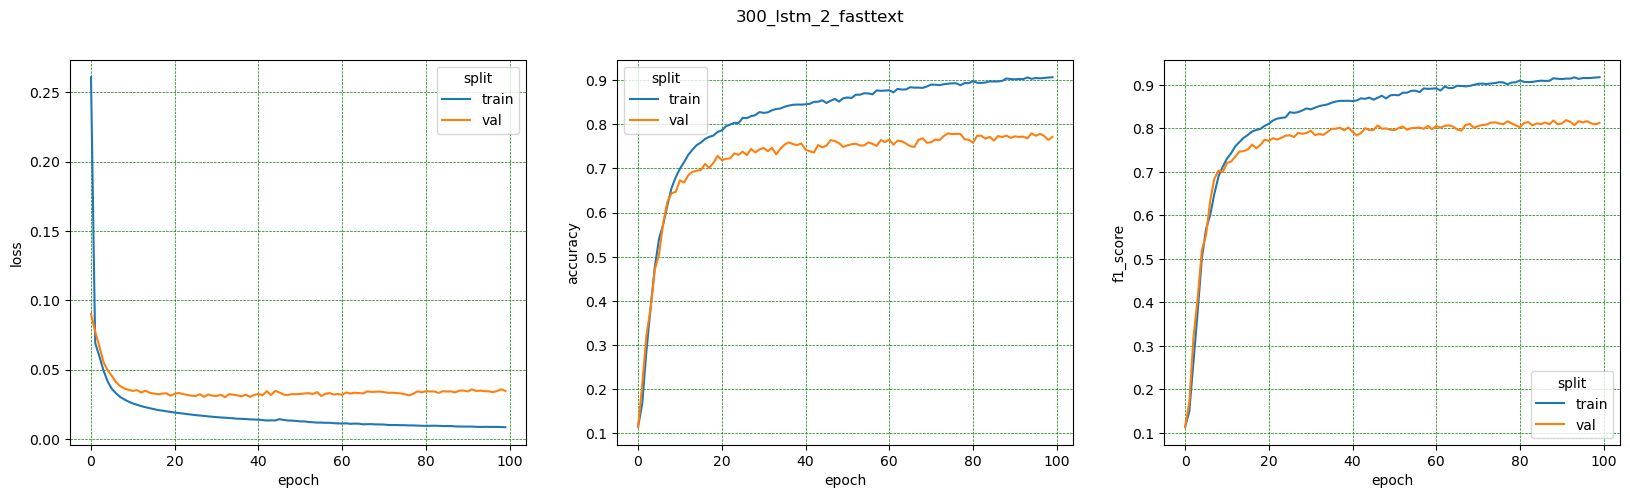

In [94]:
plot_loss_accuracy_f1_score_graph(histories[0])

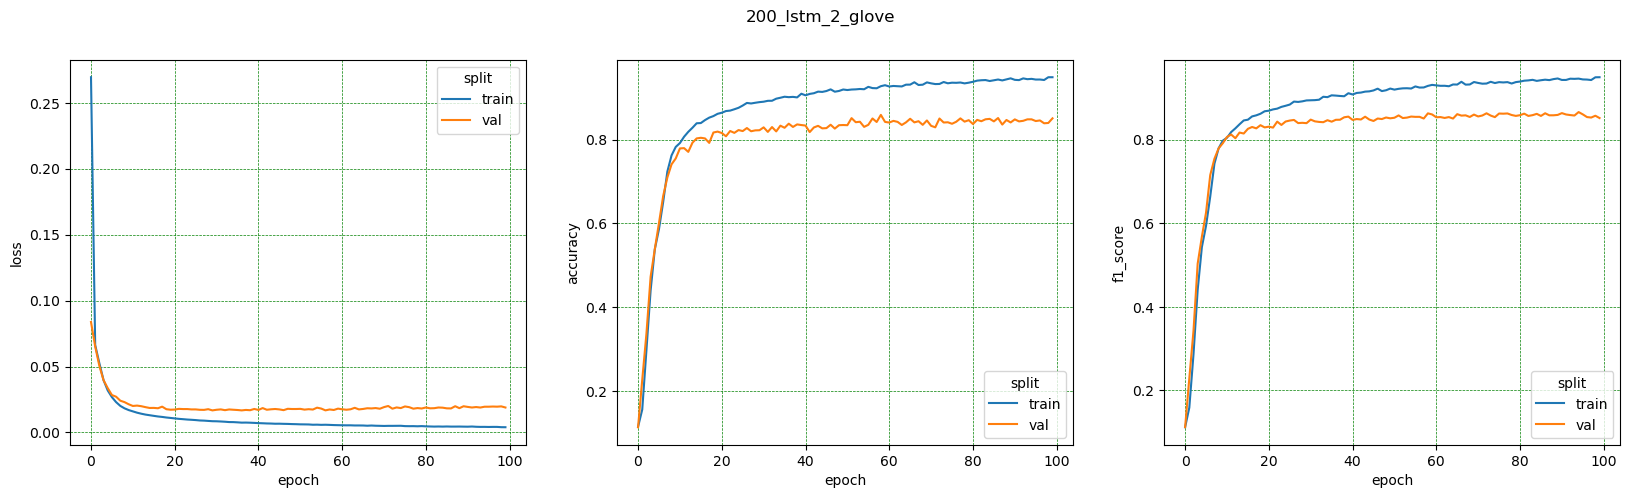

In [95]:
plot_loss_accuracy_f1_score_graph(histories[1])

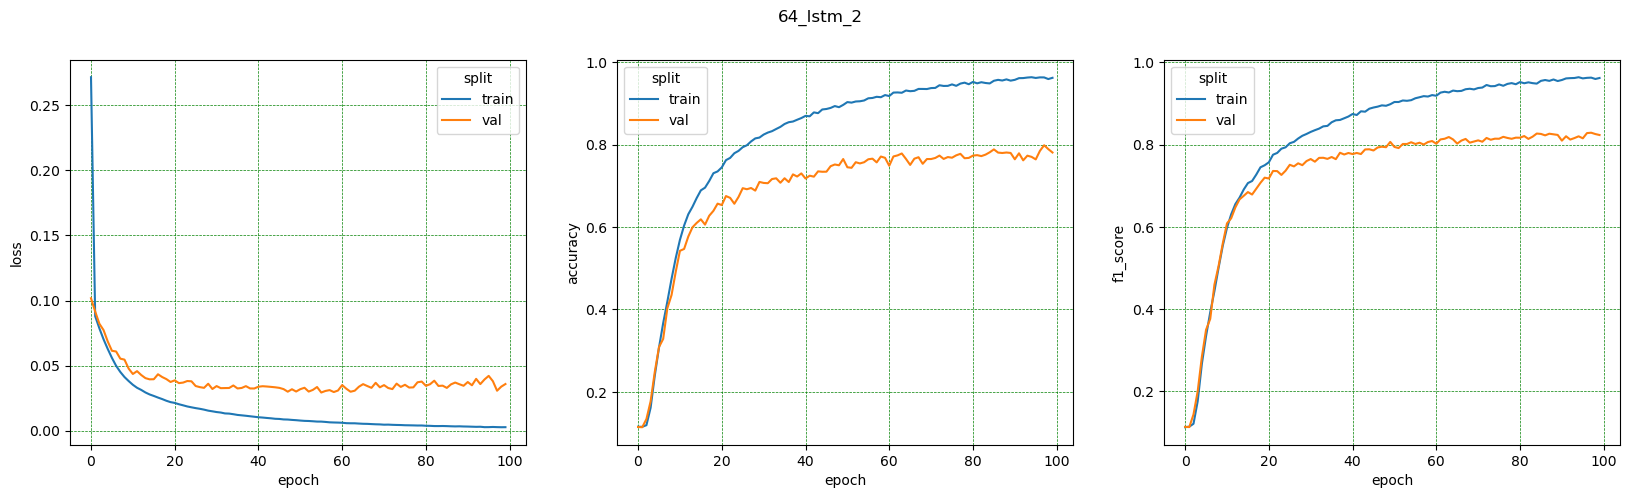

In [96]:
plot_loss_accuracy_f1_score_graph(histories[2])

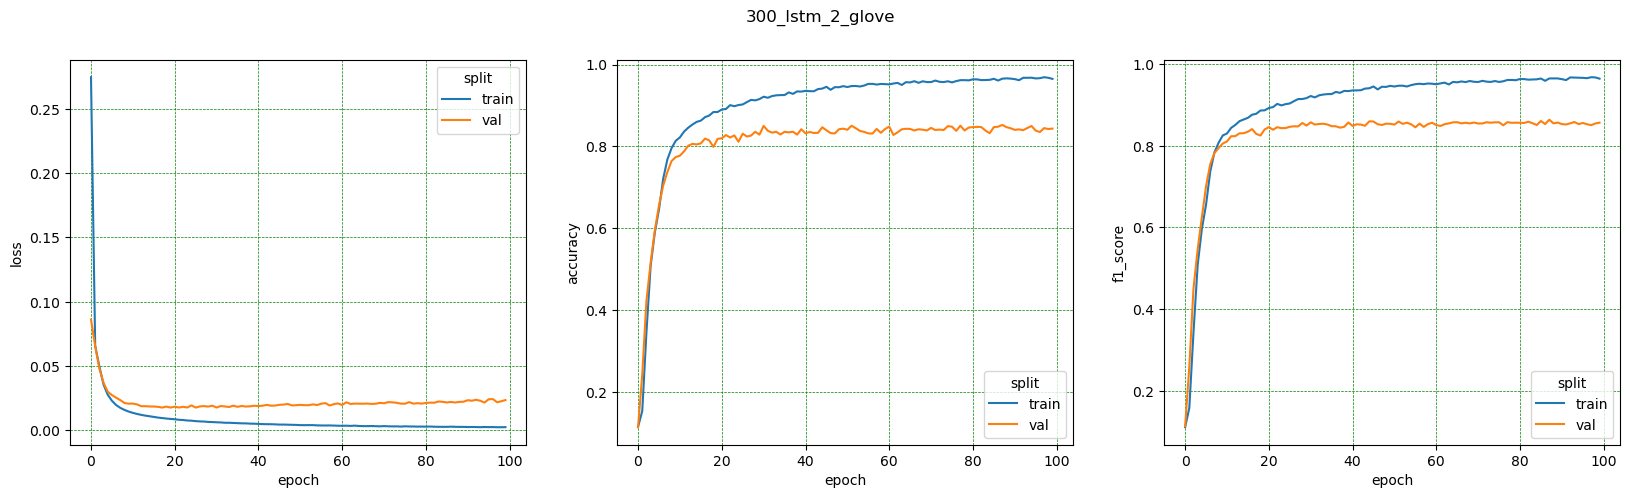

In [97]:
plot_loss_accuracy_f1_score_graph(histories[3])

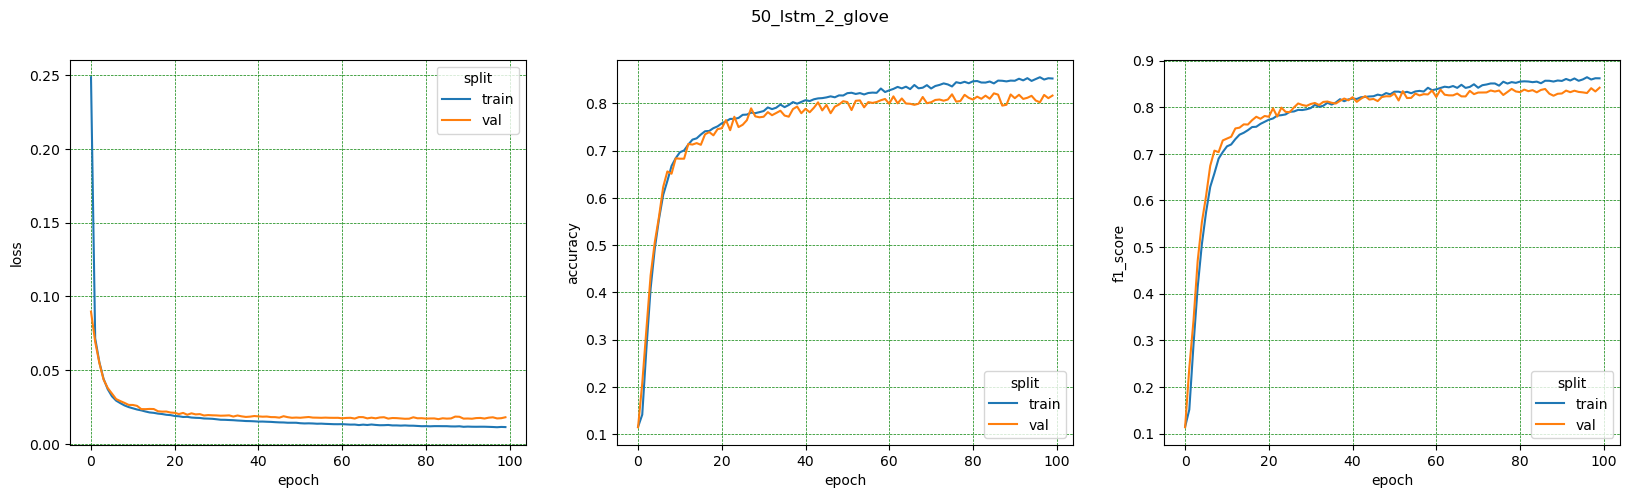

In [98]:
plot_loss_accuracy_f1_score_graph(histories[4])

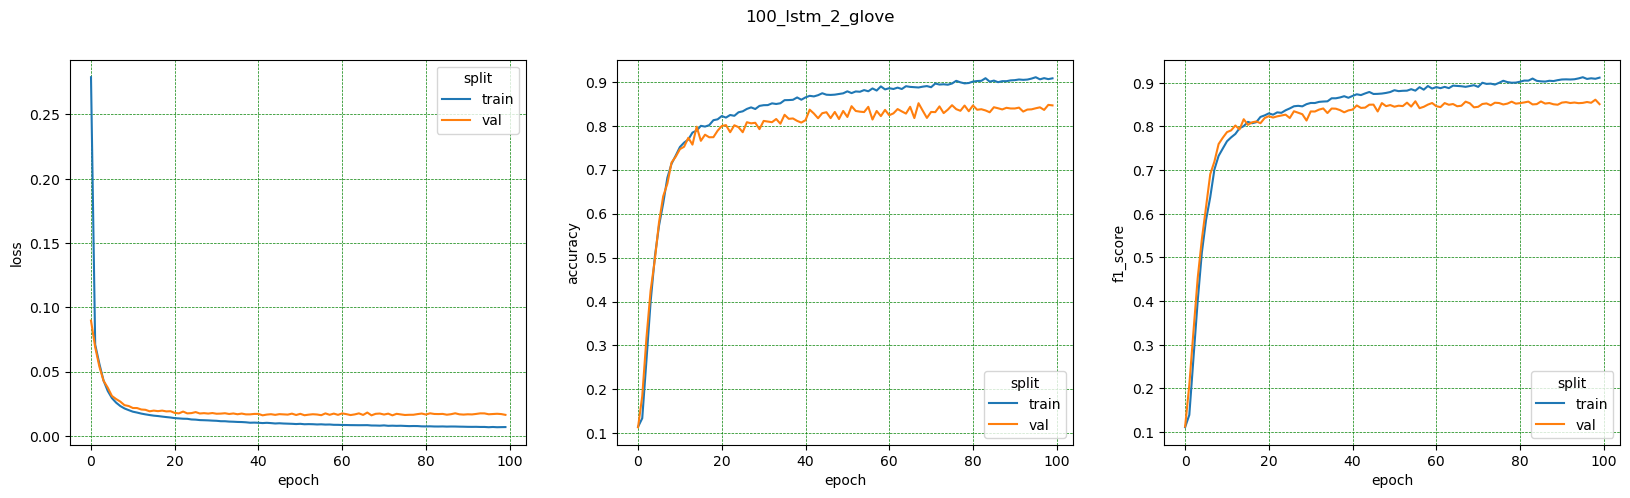

In [99]:
plot_loss_accuracy_f1_score_graph(histories[5])

In [102]:
def merge_histories(dir : str) -> pd.DataFrame:

    files = os.listdir(dir)

    dfs = []

    for file in files:
        name = os.path.splitext(file)[0]
        df_path = os.path.join(dir, file)
        df = pd.read_csv(df_path)
        df['model'] = [name for _ in range(len(df))]
        dfs.append(df)

    return pd.concat(dfs)

In [103]:
df = merge_histories(HISTORIES_DIR)

In [127]:
def compare_models(df : pd.DataFrame, metric : str, split : str, min_x : int = 0, max_x : int = 0.1):

    ax = sns.lineplot(data=df[df['split'] == split],x="epoch",y=metric,hue="model")
    plt.axis([0, 100, min_x,  max_x])

    ax.grid(color = 'green', linestyle = '--', linewidth = 0.5)

    fig_path = os.path.join(FIGURES_DIR, f"{metric}_{split}.png")
    ax.get_figure().savefig(fig_path)

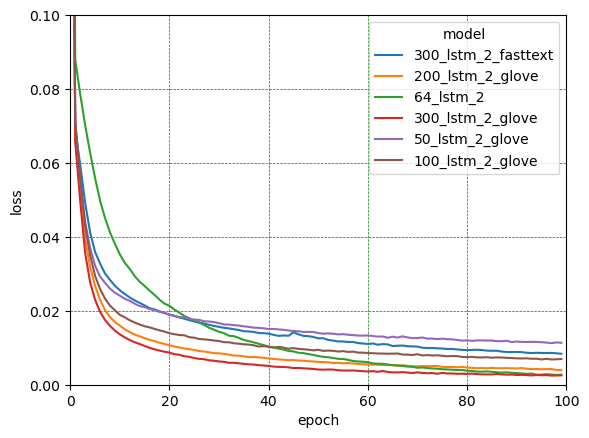

In [128]:
compare_models(df, 'loss', 'train')

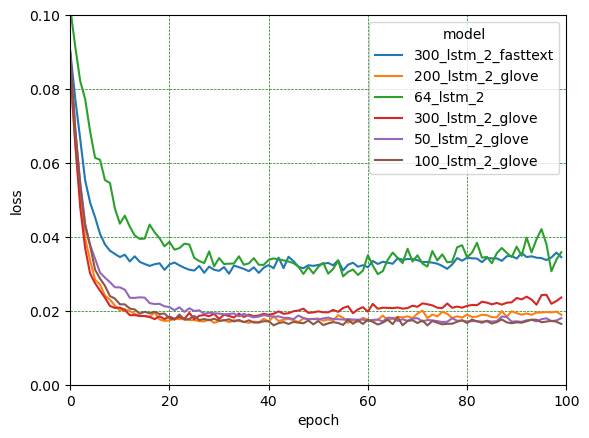

In [129]:
compare_models(df, 'loss', 'val')

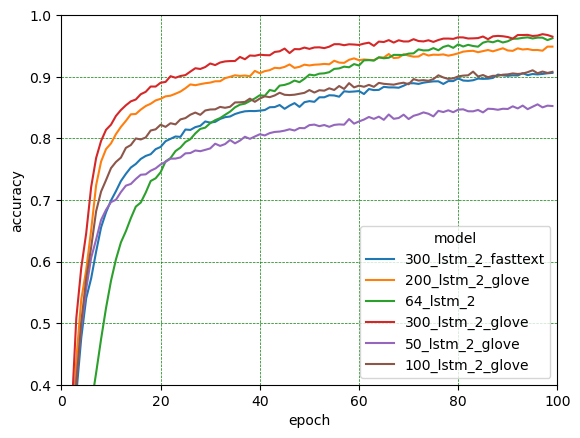

In [130]:
compare_models(df, 'accuracy', 'train', 0.4, 1)

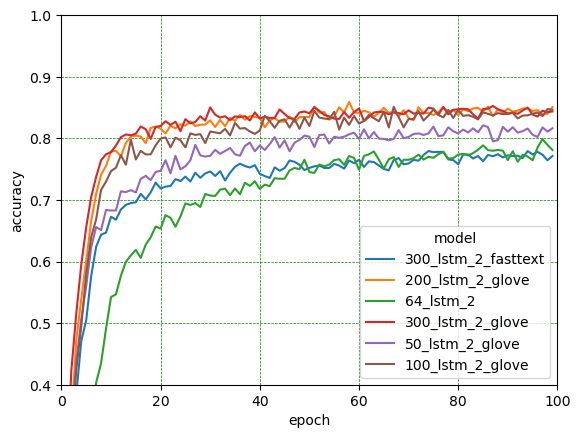

In [131]:
compare_models(df, 'accuracy', 'val', 0.4, 1)

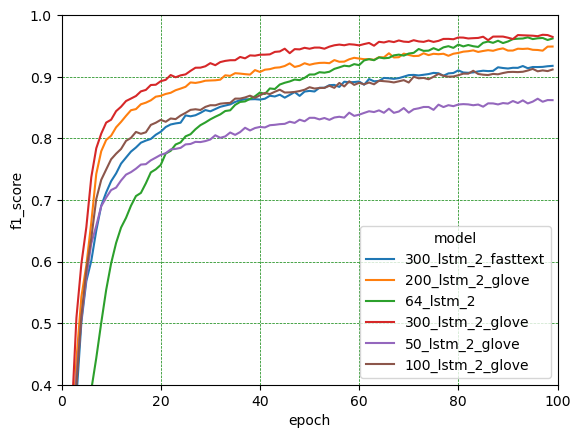

In [132]:
compare_models(df, 'f1_score', 'train', 0.4, 1)

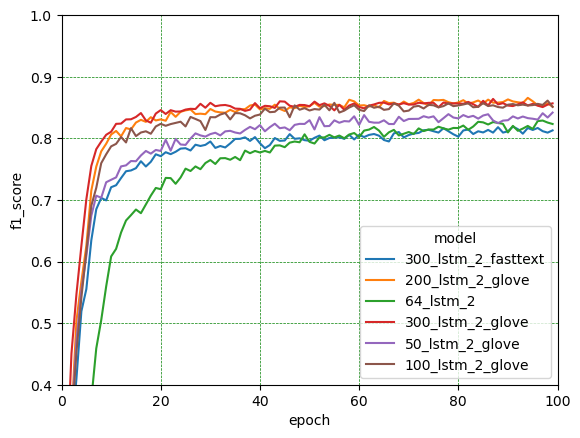

In [133]:
compare_models(df, 'f1_score', 'val', 0.4, 1)

### Evaluation on Test set

In [149]:
metrics = {
    "accuracy" : MulticlassAccuracy(num_classes=NUM_CLASSES).to(DEVICE),
    "f1_score" : MulticlassF1Score(num_classes=NUM_CLASSES).to(DEVICE),
    "auc" : MulticlassAUROC(num_classes=NUM_CLASSES).to(DEVICE),
    "precision" : MulticlassPrecision(num_classes=NUM_CLASSES).to(DEVICE),
    "recall" : MulticlassRecall(num_classes=NUM_CLASSES).to(DEVICE)
}

In [159]:
def load_models(
    dir : str,
    configs : list[dict]
) -> dict:

    models = os.listdir(dir)

    models_dict = {}

    for model in models:

        model_name = os.path.splitext(model)[0]
        model_path = os.path.join(dir, model)

        state_dict = torch.load(model_path)
        config = [config for config in configs if config["name"] == model_name][0]

        model = NamedEntityRecognitionModel(**config).to(DEVICE)
        model.load_state_dict(state_dict)

        models_dict[model_name] = model

    return models_dict

In [160]:
models = load_models(WEIGHTS_DIR, configs)

In [145]:
def predict(
    model : NamedEntityRecognitionModel,
    loader : DataLoader
):
    
    model.eval()

    Y = []
    Y_hat = []

    with torch.inference_mode():

        for x,y in tqdm(loader):

            x,y = x.to(DEVICE), y.to(DEVICE)

            y_hat = model(x)

            Y.append(y)
            Y_hat.append(y_hat)

    Y = torch.cat(Y)
    Y_hat = torch.cat(Y_hat)

    return Y,Y_hat

In [150]:
def compute_metrics(
    model : NamedEntityRecognitionModel,
    loader : DataLoader,
    metrics : dict[str, Metric]
):
    
    y, y_hat = predict(model, loader)

    y = y.reshape(-1)
    y_hat = y_hat.reshape(-1, y_hat.size(-1))

    results = {}

    for name, metric in metrics.items():

        results[name] = metric(y_hat, y).item()

    return pd.Series(results)

In [157]:
def evaluate(
    models : dict[str, NamedEntityRecognitionModel],
    loader : DataLoader,
    metrics : dict[str, Metric]
) -> pd.DataFrame:
    
    df = pd.DataFrame()
    
    for name, model in models.items():
        models_results = compute_metrics(model, loader, metrics)
        df[name] = models_results

    return df

In [161]:
evaluate(models, train_dataloader, metrics)

  0%|          | 0/439 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

,50_lstm_2_glove,300_lstm_2_glove,200_lstm_2_glove,64_lstm_2,300_lstm_2_fasttext,100_lstm_2_glove
accuracy,0.916272,0.996297,0.991528,0.994037,0.957511,0.971522
f1_score,0.937769,0.996606,0.989707,0.995805,0.969772,0.973990
auc,0.999890,0.999999,0.999994,1.000000,0.999898,0.999972
precision,0.961934,0.996919,0.987930,0.997587,0.982938,0.976511
recall,0.916272,0.996297,0.991528,0.994037,0.957511,0.971522


In [162]:
evaluate(models, val_dataloader, metrics)

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

,50_lstm_2_glove,300_lstm_2_glove,200_lstm_2_glove,64_lstm_2,300_lstm_2_fasttext,100_lstm_2_glove
accuracy,0.802946,0.835598,0.844970,0.772931,0.762882,0.842232
f1_score,0.850343,0.867982,0.863488,0.836663,0.825016,0.865197
auc,0.998953,0.998796,0.999150,0.997782,0.995238,0.999104
precision,0.914231,0.907000,0.885699,0.919277,0.904898,0.892466
recall,0.802946,0.835598,0.844970,0.772931,0.762882,0.842232


In [163]:
evaluate(models, test_dataloader, metrics)

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

,50_lstm_2_glove,300_lstm_2_glove,200_lstm_2_glove,64_lstm_2,300_lstm_2_fasttext,100_lstm_2_glove
accuracy,0.758978,0.797065,0.797929,0.694949,0.698199,0.799094
f1_score,0.796783,0.820214,0.807386,0.762526,0.762134,0.812119
auc,0.998839,0.998356,0.998737,0.997229,0.994551,0.998968
precision,0.841402,0.846076,0.819206,0.851110,0.846398,0.826536
recall,0.758978,0.797065,0.797929,0.694949,0.698199,0.799094
